### MLP-pitmodel

test the new feature 'cur_cautionlaps'

base: MLP-pitmodel-plen2

build a pitstop dataset with <cautions_laps, pitage, gap2nextpit>
gluonts interface of Dataset = Iterable[DataEntry], DataEntry = Dict(str, any)

+ input pitstop dataset, remove pitstops with pit_oncaution = 1, refer to lapstatus_dataset-fastrun
+ context_length = 1, prediction_length = 1
+ target : gap to nextpit
+ covariates are: cautions_laps, pitage, (carid, eid)
+ modeling the distribution of nextpit-gap


In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import random
import mxnet as mx
from mxnet import gluon
import pickle
import json
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import inspect
from scipy import stats
from pathlib import Path 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from gluonts.dataset.util import to_pandas
from pathlib import Path
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator, MultivariateEvaluator
from gluonts.model.predictor import Predictor
from gluonts.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.distribution.student_t import StudentTOutput
from gluonts.model.forecast import SampleForecast

from indycar.model.mlp import MLPEstimator

INFO:root:Using GPU


In [2]:
import os
os.getcwd()

'/scratch_hdd/hpda/indycar/notebook/22.PaperFinal'

In [3]:

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def test_flag(a, bitflag):
    return (a & bitflag) ==  bitflag

#
# remove NaN at the tail
# there should be no nans in the middle of the ts
COL_LAPTIME=0
COL_RANK=1
COL_TRACKSTATUS=2
COL_LAPSTATUS=3
COL_TIMEDIFF=4
COL_CAUTION_LAPS_INSTINT=5
COL_LAPS_INSTINT= 6
COL_ELAPSED_TIME= 7
COL_LAP2NEXTPIT = 8


MODE_ORACLE = 0
MODE_NOLAP = 1
MODE_NOTRACK = 2
MODE_TESTZERO = 4
MODE_TESTCURTRACK = 8
#MODE_STR={MODE_ORACLE:'oracle', MODE_NOLAP:'nolap',MODE_NOTRACK:'notrack',MODE_TEST:'test'}

def split_ts(rec, carno, eid, include_end = False):
    """
    input: 
        ts
    output:
        nextpit records
    """
    output = []
    pitstops = np.where(rec[COL_LAPSTATUS,:] == 1)[0]
    
    if len(pitstops)==0:
        print('no pit ts')
        return output
    
    #pit_oncaution = np.zeros_like((pitstops))
    #for pit in pitstops:
    #    if rec[COL_TRACKSTATUS,:] == 1:
    #        pit_oncaution = 1
    pit_oncaution = np.zeros_like((rec[COL_LAP2NEXTPIT,:]))
    stint_len = np.zeros_like((rec[COL_LAP2NEXTPIT,:]))
    pos = 0
    for pit in pitstops:
        if rec[COL_TRACKSTATUS,pit] == 1:
            #next pit is oncaution
            # set pos -> pit as oncaution
            pit_oncaution[pos:pit] = 1
        else:
            pit_oncaution[pos:pit] = 0
            
        stint_len[pos:pit] = pit - pos
        pos = pit
        
        
    # calc cur_cautionlaps
    # accumulate consecutive caution laps
    trackstatus = rec[COL_TRACKSTATUS,:]
    lapstatus = rec[COL_LAPSTATUS,:]
    
    #import pdb; pdb.set_trace()
    
    cur_cautionlaps = np.zeros_like(trackstatus)
    cautionlaps_acc = 0
    for idx in range(len(trackstatus)):
        if (trackstatus[idx] == 0) or (lapstatus[idx] == 1):
            #reset
            cautionlaps_acc = 0
        else:
            cautionlaps_acc += 1
            
        #save state
        cur_cautionlaps[idx] = cautionlaps_acc
        
            
    #prepare output : lap2nextpit, CAUTION_LAPS_INSTINT,LAPS_INSTINT, pit_oncaution, carno, eid, lap, stintlen
    if include_end:
        #rec = rec[:, ~np.isnan(rec[run_ts,:])]
        totallen = len(rec[COL_RANK, ~np.isnan(rec[COL_RANK,:])])
    else:
        totallen = pitstops[-1]
        
    # set the last stint target = 999, an invalid lap2nextpit
    for idx in range(totallen):
        output.append([ rec[COL_LAP2NEXTPIT ,idx] if idx < pitstops[-1] else 999
                        ,rec[COL_CAUTION_LAPS_INSTINT ,idx]
                        ,rec[COL_LAPS_INSTINT ,idx]
                        ,pit_oncaution[idx]
                        ,carno
                        ,eid
                        ,idx
                        ,stint_len[idx]
                        ,cur_cautionlaps[idx]
                      ])
        
    return output

def make_dataset_byevent(test_event = 'Indy500-2018', include_end = False):
    """
    split the ts to train and test part by the ratio
    
    oracle_mode: false to simulate prediction in real by 
        set the covariates of track and lap status as nan in the testset
            
    
    """    
    useeid = False
    run_ts = COL_LAP2NEXTPIT
    train_set = []
    test_set = []
    
    #_data: eventid, carids, datalist[carnumbers, features, lapnumber]->[laptime, rank, track, lap]]
    for _data in laptime_data:
        _train = []
        _test = []
        
        if events[_data[0]] == test_event:
            test_mode = True
        else:
            test_mode = False
            
        # process for each ts
        for rowid in range(_data[2].shape[0]):
            # rec[features, lapnumber] -> [laptime, rank, track_status, lap_status,timediff]]
            rec = _data[2][rowid].copy()
            
            #remove nan(only tails)
            nans, x= nan_helper(rec[run_ts,:])
            nan_count = np.sum(nans)             
            rec = rec[:, ~np.isnan(rec[run_ts,:])]
            
            # remove short ts
            totallen = rec.shape[1]
            
            carno = _data[1][rowid]
            carid = global_carids[_data[1][rowid]]
            
            eid = _data[0]
            
            # all go to train set
            output = split_ts(rec, carno, eid, include_end= include_end)
            #if len(output) == 0:
            #    continue
            
            test_rec_cnt = 0
            if not test_mode:
                _train.extend(output)
                
            else:
                _test.extend(output)
                test_rec_cnt += 1
            
            #add one ts
            print(f'carno:{carno}, totallen:{totallen}, nancount:{nan_count}, test_reccnt:{test_rec_cnt}')

        train_set.extend(_train)
        test_set.extend(_test)

    print(f'train len:{len(train_set)}, test len:{len(test_set)}')
    
    return train_set, test_set

def save_dataset(datafile,freq, prediction_length, cardinality, train_ds, test_ds):
    with open(datafile, 'wb') as f:
        #pack [global_carids, laptime_data]
        savedata = [freq, prediction_length, cardinality, train_ds, test_ds]
        #savedata = [freq, train_set, test_set]
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

In [4]:
#make gluonts
from sklearn.preprocessing import StandardScaler,MinMaxScaler

def makedb(data, scaler='standard', perm = True, feature_cnt=2):
    db = []
    start = pd.Timestamp("01-01-2019", freq='1min')  # can be different for each time series
    
    scalers = {'minmax':MinMaxScaler(), 'standard':StandardScaler()}
    
    if isinstance(scaler, str):
        if scaler in scalers:
            scaler = scalers[scaler]
            scaler.fit(data)
            df = scaler.transform(data)
        else:
            # no scaler
            df = data
    else:
        #use input scaler
        #scaler.fit(data)
        df = scaler.transform(data)
        
    
    #permute
    if perm:
        perm = np.random.permutation(len(df))
        df = df[perm]
    
    for x in df:
        if feature_cnt == 3:
            db.append({'target':np.array([x[0]]), 'feat':np.array([x[1],x[2],x[3]]),
                  "start":start, 'forecast_start':start})
        elif feature_cnt == 2:
            db.append({'target':np.array([x[0]]), 'feat':np.array([x[1],x[2]]),
                  "start":start, 'forecast_start':start})
        else:
            print('error _feature_cnt not support:', feature_cnt)
            break
        
    return db, scaler, df


def make_fulltestdb(scaler, maxgap=60, maxcautionlen=20, feature_cnt=2):
    db = []
    start = pd.Timestamp("01-01-2019", freq='1min')  # can be different for each time series

    data = []
    for caution_lap in range(maxgap):
        for pitage in range(caution_lap, maxgap):
            if feature_cnt == 2:        
                data.append([0.,caution_lap, pitage, 0])
            elif feature_cnt == 3:        
                for cur_cautionlap in range(0, caution_lap+1):
                    data.append([0.,caution_lap, pitage, cur_cautionlap])
    data = np.array(data)
    
    if not isinstance(scaler, str):
        df = scaler.transform(data)
    else:
        df = data
    
    #data
    print(f'make full testdb: {len(df)} records')
    for x in df:
        if feature_cnt == 3:        
            db.append({'target':np.array([x[0]]), 'feat':np.array([x[1],x[2],x[3]]),
                  "start":start, 'forecast_start':start})
        elif feature_cnt == 2:
            db.append({'target':np.array([x[0]]), 'feat':np.array([x[1],x[2]]),
                  "start":start, 'forecast_start':start})
        else:
            print('error _feature_cnt not support:', feature_cnt)
            break

    #reset data, used by PitModel.save_model()
    if feature_cnt == 2:
        data = data[:,:3]            
            
    return db, scaler, df, data

In [5]:
def train_model(epochs, layers=[10,10,5], output = 'student', dropout = .5, id='all', feature_cnt = 2):
    distr_outputs ={'student':StudentTOutput(),  
                    'negbin':NegativeBinomialOutput() 
                   }
    if not output in distr_outputs:
        print(f'distr_output: {output} not found error.')
        return
    
    distr_output = distr_outputs[output]
    
    modelid = 'mlp-d%s-f%d-e%s-l%s-%s-d%s'%(id, feature_cnt,
                                            epochs, '-'.join([str(x) for x in layers]), output, dropout)
    
    estimator = MLPEstimator(
        num_hidden_dimensions=layers,
        prediction_length=1,
        context_length=1,
        freq='1min',
        dropout = dropout,
        distr_output = distr_output,
        trainer=Trainer(ctx="gpu(0)", 
                        batch_size = 32,
                        epochs= epochs,
                        learning_rate=1e-3,
                        hybridize=False,
                        num_batches_per_epoch=100
                       )
    )    

    predictor = estimator.train(train_ds)

    return predictor, modelid

def eval_model(predictor, test_ds):
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset    
        predictor=predictor,  # predictor                                  
        num_samples=1000,  # number of sample paths we want for evaluation 
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)     
    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9]) 
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
    print(json.dumps(agg_metrics, indent=4)) 
    return tss, forecasts, agg_metrics


def raw_eval(tss, forecasts):
    """
    scaler
    """
    #rec = np.zeros((_feature_cnt + 1))
    rec = np.zeros((4))

    truth, pred = [],[]
    #go through the dataset
    for idx in range(len(tss)):
        rec[0] = list(tss[idx].values)[0]
    
        if isinstance(scaler, str):
            truth.append(int(rec[0]))
        else:
            truth.append(int(scaler.inverse_transform(rec)[0]))
    
        rec[0] = np.mean(forecasts[idx].samples)
        
        if isinstance(scaler, str):
            pred.append(int(rec[0]))    
        else:
            pred.append(int(scaler.inverse_transform(rec)[0]))        

    #get mae
    mae = mean_absolute_error(truth, pred)
    print('mae = ', mae)
    return mae

def decode(tss, forecasts):
    """
    scaler
    """
    #rec = np.zeros((_feature_cnt + 1))
    rec = np.zeros((4))

    truth, pred = [],[]
    sampleCnt = forecasts[0].samples.shape[0]
    samples = np.zeros((sampleCnt, len(tss)))
    
    #go through the dataset
    for idx in range(len(tss)):
        rec[0] = list(tss[idx].values)[0]
    
        if isinstance(scaler, str):
            truth.append(int(rec[0]))
        else:
            truth.append(int(scaler.inverse_transform(rec)[0]))
    
        #pred
        rec[0] = np.mean(forecasts[idx].samples)
        
        if isinstance(scaler, str):
            pred.append(int(rec[0]))    
        else:
            pred.append(int(scaler.inverse_transform(rec)[0]))        
            
        #samples
        for sid in range(sampleCnt):
            rec[0] = forecasts[idx].samples[sid]
            if isinstance(scaler, str):
                pred.append(int(rec[0]))    
                samples[sid, idx] = int(rec[0])
            else:
                samples[sid, idx] = int(scaler.inverse_transform(rec)[0])        
    
    return truth, pred, samples

def save_model(predictor, outdir):
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    
    predictor.serialize(Path(outdir)) 


In [6]:
### pitmodel
class PitModel():
    """
     <caution_lap, pitage> -> [distribution]    
     distribution := sorted cdf [val:probability, val2:p2, ...]
         [0,:] -> val
         [1,:] -> cdf p
         
     no scaler, raw feat and target
    
    """
    def __init__(self, modelfile=''):
        self.model = {}
        self.name = ''
        
        if modelfile:
            self.load_model(modelfile)
                
    def load_model(self, modelfile):
        with open(modelfile, 'rb') as f:
            self.name, self.model = pickle.load(f, encoding='latin1')
            print(f'init model:{self.name}')
        
    def save_model(self, modelname, test_ds, forecasts, scaler):
        
        model = {}
        
        #get the sclaer for the first column(lap2nextpit)
        sc, scf = '', ''
        if isinstance(scaler, StandardScaler):
            sc = StandardScaler()
            sc.scale_ = scaler.scale_[0]
            sc.mean_ = scaler.mean_[0]
            sc.var_ = scaler.var_[0]

            scf = StandardScaler()
            scf.scale_ = scaler.scale_[1:]
            scf.mean_ = scaler.mean_[1:]
            scf.var_ = scaler.var_[1:]

        
        for idx, rec in enumerate(test_ds):
            feat = rec[1:]
                
            key = '-'.join([str(int(x)) for x in feat])
            
            if not key in model:
            
                samples = forecasts[idx].samples.reshape(-1)
                
                if not isinstance(sc, str):
                    samples = sc.inverse_transform(samples)
                
                #force to prediction to be valid lap2nextpit
                samples = samples.astype(int)
                samples = samples[samples > 0]

                #
                valset = set(list(samples))
                plen = len(valset)
                distr = np.zeros((2, plen))
                distr[0, :] = sorted(valset)
                smap = {val:id for id, val in enumerate(distr[0, :])}
                for s in samples:
                    distr[1,smap[s]] += 1
                tsum = np.sum(distr[1,:])
                distr[1, :] /= tsum
                distr[1, :] = np.cumsum(distr[1, :])

                model[key] = distr
                
        #save model
        self.model = model
        self.name = modelname
        with open(modelname, 'wb') as f:
            savedata = [self.name, self.model]
            pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)        
        print(f'save model {modelname} with {len(self.model)} keys.')
                
    def predict(self, *args):
        key = '-'.join([str(int(x)) for x in args])
        #if key in self.model:
        try:
            distr = self.model[key]
            
            #[0, 1.)
            p = np.random.random()  
            i = np.sum(distr[1,:] < p)
            
            return distr[0,i]
        except:
            #exception
            #todo, backto special model
            print(f'ERROR: key {key} not found in model')
                       
    def forecast_ds(self, test_ds, forecasts):
        """
        test_ds as testset, the unsclaed input
        forecasts ; the template
        """
        
        plen = len(test_ds)
        sample_cnt = forecasts[0].samples.shape[0]
        assert(plen == len(forecasts))
        

        #build a new forecasts object
        nf = []
        for fc in forecasts:
            nfc = SampleForecast(samples = np.zeros_like(fc.samples), 
                                 freq=fc.freq, start_date=fc.start_date)
            nf.append(nfc)
        
        for idx, rec in enumerate(test_ds):
            feat = rec[1:]
                    
            onecast = np.zeros((sample_cnt))
            for i in range(sample_cnt):
                #onecast[i] = self.predict(feat[0], feat[1],feat[2])
                onecast[i] = self.predict(*feat)
        
            nf[idx].samples = onecast

        return nf
    
    def forecast_onecar(self, test_ds, plen = 2, sample_cnt=100):
        """
        long-prediction for a single car
        
        input:
            test_df ; 'lap2nextpit','caution_laps','pitage','lap'
        """
        
        #assert for one car
        totallen = len(test_ds)
        start = pd.Timestamp("01-01-2019", freq='1min')  # can be different for each time series
        
        #samples
        #onecast = np.zeros((sample_cnt, totallen+plen))
        onecast = np.zeros((sample_cnt, totallen))
        #onecast = np.zeros((sample_cnt, maxlap))
        tss = np.zeros((totallen+plen))
        
        for idx, rec in enumerate(test_ds[:-plen]):
        #for idx in range(maxlap-plen):
            
            #if idx<len(test_ds):
            #    rec = test_ds[idx]
            #else:
            #    #use the last rec
            #    # target, cautionlaps, pitage, cur_curcautionlaps
            #    rec = [0, ] 
                
            target = rec[0]
            feat = rec[1:]
            
            if target == plen:
                tss[idx + plen] = 1
            
            for i in range(sample_cnt):
                nextpit = self.predict(*feat)
                                                    
                if nextpit == plen:
                    onecast[i, idx + plen] = 1
                
        forecast = SampleForecast(samples = onecast, 
                             freq='1min', start_date=start)

        return forecast, tss
    
    
def save_full_pitmodel(mid, scaler, maxgap=60, feature_cnt = 2):
    """
    input:
        p[mid]; predictor
        runid ; 'all' or 'sel' of the trainning set
    """
    
    #get scaler
    #scaler = _data[runid][-1]

    # make full test set
    test_ds, _, _, test_all = make_fulltestdb(scaler, maxgap = maxgap, feature_cnt = feature_cnt)

    tss,forecasts, _ = eval_model(p[mid], test_ds)

    pitmodel = PitModel()

    #pitmodel.save_model(f'pitmodel-m{maxgap}-{mid}.pickle', test_all, forecasts, scaler)
    pitmodel.save_model(f'pitmodel-m{maxgap}-{mid}-1k-{featurecnt_str}.pickle', test_all, forecasts, scaler)

    return pitmodel

### create dbs

In [7]:
def build_datasets(test_event, include_end, feature_cnt=2):
    
    _data = {}
    
    train, test =  make_dataset_byevent(test_event = test_event, include_end = include_end)
    #prepare output : lap2nextpit, CAUTION_LAPS_INSTINT,LAPS_INSTINT, pit_oncaution, carno, eid, lap
    df_train = pd.DataFrame(train,columns=['lap2nextpit', 'caution_laps','pitage', 'pit_oncaution', 
                     'carno','eid','lap','stint_len','cur_cautionlaps'])
    df_test = pd.DataFrame(test,columns=['lap2nextpit', 'caution_laps','pitage', 'pit_oncaution', 
                     'carno','eid','lap','stint_len','cur_cautionlaps'])
    
    # select
    train_sel = df_train[(df_train['pit_oncaution']==0) &(df_train['stint_len']>23)]
    train_sel_2013_2017 = train_sel[train_sel['eid']<5]
    train_all_2013_2017 = df_train[df_train['eid']<5]

    print(len(train_all_2013_2017), len(train_sel_2013_2017))    

    test_sel = df_test[(df_test['pit_oncaution']==0) &(df_test['stint_len']>23)]
    test_all = df_test

    train_sel_noshort = df_train[(df_train['stint_len']>15)]
    train_sel_noshort_2013_2017 = train_sel_noshort[train_sel_noshort['eid']<5]
    test_sel_noshort = df_test[(df_test['stint_len']>15)]    
    
    
    # selected db
    trainset = train_sel_2013_2017[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
    testset = test_sel[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
    train_ds, scaler, _ = makedb(trainset, scaler='standard',feature_cnt=feature_cnt)
    test_ds, _, _ = makedb(testset, scaler, perm=False,feature_cnt=feature_cnt)

    _data['sel'] = [trainset, testset, train_ds, test_ds, scaler]


    # selected db
    trainset = train_all_2013_2017[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
    testset = test_all[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
    train_ds, scaler, _ = makedb(trainset, scaler='standard',feature_cnt=feature_cnt)
    test_ds, _, _ = makedb(testset, scaler, perm=False,feature_cnt=feature_cnt)

    _data['all'] = [trainset, testset, train_ds, test_ds, scaler]


    # selected db
    trainset = train_sel_noshort_2013_2017[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
    testset = test_sel_noshort[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
    train_ds, scaler, _ = makedb(trainset, scaler='standard',feature_cnt=feature_cnt)
    test_ds, _, _ = makedb(testset, scaler, perm=False,feature_cnt=feature_cnt)

    _data['noshort'] = [trainset, testset, train_ds, test_ds, scaler]    

    # add normal (normal pit only, with short pits)
    train_sel_normal = df_train[(df_train['pit_oncaution']==0)]
    train_sel_normal_2013_2017 = train_sel_normal[train_sel_normal['eid']<5]
    test_sel_normal = df_test[(df_test['pit_oncaution']==0)]

    trainset = train_sel_normal_2013_2017[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
    testset = test_sel_normal[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values

    train_ds, scaler, _ = makedb(trainset, scaler='standard',feature_cnt=feature_cnt)
    test_ds, _, _ = makedb(testset, scaler, perm=False,feature_cnt=feature_cnt)

    _data['normal'] = [trainset, testset, train_ds, test_ds, scaler]
    
    # add caution pits
    train_sel_caution = df_train[(df_train['pit_oncaution']==1)]
    train_sel_caution_2013_2017 = train_sel_caution[train_sel_caution['eid']<5]
    test_sel_caution = df_test[(df_test['pit_oncaution']==1)]

    trainset = train_sel_caution_2013_2017[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
    testset = test_sel_caution[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values

    train_ds, scaler, _ = makedb(trainset, scaler='standard',feature_cnt=feature_cnt)
    test_ds, _, _ = makedb(testset, scaler, perm=False,feature_cnt=feature_cnt)

    _data['caution'] = [trainset, testset, train_ds, test_ds, scaler]
    
    # add plen=2
    train_sel_plen2 = df_train[(df_train['lap2nextpit']==2)]
    train_sel_plen2_2013_2017 = train_sel_caution[train_sel_caution['eid']<5]
    test_sel_plen2 = df_test[(df_test['lap2nextpit']==2)]

    trainset = train_sel_plen2_2013_2017[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
    testset = test_sel_plen2[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values

    train_ds, scaler, _ = makedb(trainset, scaler='standard',feature_cnt=feature_cnt)
    test_ds, _, _ = makedb(testset, scaler, perm=False,feature_cnt=feature_cnt)

    _data['plen2'] = [trainset, testset, train_ds, test_ds, scaler]
        
    
    return df_train, df_test, _data

In [21]:
#straight implementation of prisk
def quantile_loss(target, quantile_forecast, q):
    return 2.0 * np.nansum(
        np.abs(
            (quantile_forecast - target)
            * ((target <= quantile_forecast) - q)
        )
    )

def abs_target_sum(target): 
    return np.nansum(np.abs(target)) 

def prisk_direct_bysamples(forecast, target, quantiles=[0.1,0.5,0.9], startid = 0, verbose=False):
    """
    calculate prisk by <samples, tss> directly (equal to gluonts implementation)
    
    target: endrank
    forecast: pred_endrank
    item_id: <carno, startlap>
    """
    
    prisk = np.zeros((len(quantiles)))
    target_sum = 0
    aggrisk = np.zeros((len(quantiles)))
    
    #calc quantiles
    # len(quantiles) x 1
    quantile_forecasts = np.quantile(forecast, quantiles, axis=0)

    for idx, q in enumerate(quantiles):
        q_forecast = quantile_forecasts[idx]
        prisk[idx] = quantile_loss(target[startid:], q_forecast[startid:], q)
        target_sum = abs_target_sum(target[startid:])

    if verbose==True and carno==3:
        print('target:', target[startid:])
        print('forecast:', q_forecast[startid:])
        print('target_sum:', target_sum)

        print('quantile_forecasts:', quantile_forecasts[:,startid:])
        
    #agg
    #aggrisk = np.mean(prisk, axis=0)
    #prisk_sum = np.nansum(prisk, axis=0)
    prisk_sum = prisk
    
    if verbose==True:
        print('prisk:',prisk)
        print('prisk_sum:',prisk_sum)
        print('target_sum:',target_sum)
    for idx, q in enumerate(quantiles):
        aggrisk[idx] = np.divide(prisk_sum[idx], target_sum)
    
    agg_metrics = {}
    for idx, q in enumerate(quantiles):
        agg_metrics[f'wQuantileLoss[{q}]'] = aggrisk[idx]
        
    print(agg_metrics.values())
    
    return agg_metrics, aggrisk

In [8]:
_inlap_status = 0
#years = ['2013','2014','2015','2016','2017','2018','2019']
years = ['2013','2014','2015','2016','2017','2018','2019']
#events = ['Indy500']
events = [f'Indy500-{x}' for x in years]
events_id={key:idx for idx, key in enumerate(events)}
dbid = f'Indy500_{years[0]}_{years[-1]}_v9_p{_inlap_status}'

# start from here
import pickle
#with open('laptime_rank_timediff_fulltest-oracle-%s.pickle'%year, 'rb') as f:
with open(f'laptime_rank_timediff_pit-oracle-{dbid}.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    global_carids, laptime_data = pickle.load(f, encoding='latin1') 

In [9]:
include_end = True
includeend_str = '-includeend' if include_end else ''

In [10]:
#model store
dataset = {}

In [15]:
testevents = ['Indy500-2018','Indy500-2019']

for testevent in testevents:
    for feature_cnt in [2,3]:
        df_train, df_test, _data= build_datasets(testevent, include_end, feature_cnt=feature_cnt)

        key = f'{testevent}-{feature_cnt}'
        dataset[key] = [df_train, df_test, _data]
        featurecnt_str = 'withcurcautionlaps' if (feature_cnt==3) else 'nocurcautionlaps'

        datafile = f'pitstop_nextpit_dataset-{dbid}-t{testevent}-alldata-{featurecnt_str}{includeend_str}.pickle'
        with open(datafile, 'wb') as f:
            print('save data:', datafile)
            savedata = [df_train, df_test, events, testevent, _data]
            pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

carno:1, totallen:200, nancount:0, test_reccnt:0
carno:2, totallen:200, nancount:0, test_reccnt:0
carno:3, totallen:200, nancount:0, test_reccnt:0
no pit ts
carno:4, totallen:0, nancount:200, test_reccnt:0
carno:5, totallen:200, nancount:0, test_reccnt:0
no pit ts
carno:6, totallen:30, nancount:170, test_reccnt:0
carno:7, totallen:177, nancount:23, test_reccnt:0
carno:8, totallen:200, nancount:0, test_reccnt:0
carno:9, totallen:200, nancount:0, test_reccnt:0
carno:10, totallen:187, nancount:13, test_reccnt:0
carno:11, totallen:200, nancount:0, test_reccnt:0
carno:12, totallen:200, nancount:0, test_reccnt:0
carno:14, totallen:200, nancount:0, test_reccnt:0
carno:15, totallen:170, nancount:30, test_reccnt:0
carno:16, totallen:179, nancount:21, test_reccnt:0
carno:18, totallen:200, nancount:0, test_reccnt:0
carno:19, totallen:200, nancount:0, test_reccnt:0
carno:20, totallen:200, nancount:0, test_reccnt:0
carno:21, totallen:170, nancount:30, test_reccnt:0
carno:22, totallen:200, nancount:

save data: pitstop_nextpit_dataset-Indy500_2013_2019_v9_p0-tIndy500-2018-alldata-nocurcautionlaps-includeend.pickle
carno:1, totallen:200, nancount:0, test_reccnt:0
carno:2, totallen:200, nancount:0, test_reccnt:0
carno:3, totallen:200, nancount:0, test_reccnt:0
no pit ts
carno:4, totallen:0, nancount:200, test_reccnt:0
carno:5, totallen:200, nancount:0, test_reccnt:0
no pit ts
carno:6, totallen:30, nancount:170, test_reccnt:0
carno:7, totallen:177, nancount:23, test_reccnt:0
carno:8, totallen:200, nancount:0, test_reccnt:0
carno:9, totallen:200, nancount:0, test_reccnt:0
carno:10, totallen:187, nancount:13, test_reccnt:0
carno:11, totallen:200, nancount:0, test_reccnt:0
carno:12, totallen:200, nancount:0, test_reccnt:0
carno:14, totallen:200, nancount:0, test_reccnt:0
carno:15, totallen:170, nancount:30, test_reccnt:0
carno:16, totallen:179, nancount:21, test_reccnt:0
carno:18, totallen:200, nancount:0, test_reccnt:0
carno:19, totallen:200, nancount:0, test_reccnt:0
carno:20, totallen

save data: pitstop_nextpit_dataset-Indy500_2013_2019_v9_p0-tIndy500-2018-alldata-withcurcautionlaps-includeend.pickle
carno:1, totallen:200, nancount:0, test_reccnt:0
carno:2, totallen:200, nancount:0, test_reccnt:0
carno:3, totallen:200, nancount:0, test_reccnt:0
no pit ts
carno:4, totallen:0, nancount:200, test_reccnt:0
carno:5, totallen:200, nancount:0, test_reccnt:0
no pit ts
carno:6, totallen:30, nancount:170, test_reccnt:0
carno:7, totallen:177, nancount:23, test_reccnt:0
carno:8, totallen:200, nancount:0, test_reccnt:0
carno:9, totallen:200, nancount:0, test_reccnt:0
carno:10, totallen:187, nancount:13, test_reccnt:0
carno:11, totallen:200, nancount:0, test_reccnt:0
carno:12, totallen:200, nancount:0, test_reccnt:0
carno:14, totallen:200, nancount:0, test_reccnt:0
carno:15, totallen:170, nancount:30, test_reccnt:0
carno:16, totallen:179, nancount:21, test_reccnt:0
carno:18, totallen:200, nancount:0, test_reccnt:0
carno:19, totallen:200, nancount:0, test_reccnt:0
carno:20, totall

save data: pitstop_nextpit_dataset-Indy500_2013_2019_v9_p0-tIndy500-2019-alldata-nocurcautionlaps-includeend.pickle
carno:1, totallen:200, nancount:0, test_reccnt:0
carno:2, totallen:200, nancount:0, test_reccnt:0
carno:3, totallen:200, nancount:0, test_reccnt:0
no pit ts
carno:4, totallen:0, nancount:200, test_reccnt:0
carno:5, totallen:200, nancount:0, test_reccnt:0
no pit ts
carno:6, totallen:30, nancount:170, test_reccnt:0
carno:7, totallen:177, nancount:23, test_reccnt:0
carno:8, totallen:200, nancount:0, test_reccnt:0
carno:9, totallen:200, nancount:0, test_reccnt:0
carno:10, totallen:187, nancount:13, test_reccnt:0
carno:11, totallen:200, nancount:0, test_reccnt:0
carno:12, totallen:200, nancount:0, test_reccnt:0
carno:14, totallen:200, nancount:0, test_reccnt:0
carno:15, totallen:170, nancount:30, test_reccnt:0
carno:16, totallen:179, nancount:21, test_reccnt:0
carno:18, totallen:200, nancount:0, test_reccnt:0
carno:19, totallen:200, nancount:0, test_reccnt:0
carno:20, totallen

save data: pitstop_nextpit_dataset-Indy500_2013_2019_v9_p0-tIndy500-2019-alldata-withcurcautionlaps-includeend.pickle


In [25]:
datafile = f'pitstop_nextpit_dataset-{dbid}-alldata-{includeend_str}.pickle'
with open(datafile, 'wb') as f:
    print('save data:', datafile)
    savedata = dataset
    pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

save data: pitstop_nextpit_dataset-Indy500_2013_2019_v9_p0-alldata--includeend.pickle


### train the models

In [12]:
p, t, s, e = {}, {} ,{}, {}

In [18]:
#sync_test_ds = _data['all'][3]
cols = ['Year','Model','MAE','50-Risk','90-Risk']

### run train on all data
allruns = ['sel','all','noshort','normal','caution','plen2']
testevent='Indy500-2018'

retdata = []
for feature_cnt in [2,3]:
    for tid in allruns:
        #train
        key = f'{testevent}-{feature_cnt}'
        df_train, df_test, _data = dataset[key]
        
        trainset, testset, train_ds, test_ds, scaler = _data[tid]
        pm, mid = train_model(500,dropout = 0.1, id=tid, feature_cnt=feature_cnt)

        #test
        sync_testset = _data['normal'][1]
        sync_test_ds, _, _ = makedb(sync_testset, scaler, perm=False, feature_cnt=feature_cnt)
        t[mid],s[mid], e[mid] = eval_model(pm, sync_test_ds)
        p[mid] = pm

        mae = raw_eval(t[mid],s[mid])
        retdata.append([testevent,tid, mae, e[mid]["wQuantileLoss[0.5]"],e[mid]["wQuantileLoss[0.9]"]])

        #run_test(t[mid], s[mid], [31,816,846,856])
        pitmodel = save_full_pitmodel(mid, scaler, maxgap=65,feature_cnt=feature_cnt)
    
pitmodel_result = pd.DataFrame(data=retdata, columns=cols)

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 155.30it/s, avg_epoch_loss=1.23]
INFO:root:Epoch[0] Elapsed time 0.646 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.229652
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 163.78it/s, avg_epoch_loss=0.584]
INFO:root:Epoch[1] Elapsed time 0.612 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.583812
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 167.44it/s, avg_epoch_loss=0.359]
INFO:root:Epoch[2] Elapsed time 0.599 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.359425
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 169.22it/s, avg_epoch_loss=0.339]
INFO:root:Epoch[3] Elapsed time 0.592 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.339150
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 165.66it/

100%|██████████| 100/100 [00:00<00:00, 171.53it/s, avg_epoch_loss=0.0732]
INFO:root:Epoch[36] Elapsed time 0.585 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=0.073234
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 166.67it/s, avg_epoch_loss=0.0513]
INFO:root:Epoch[37] Elapsed time 0.602 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.051306
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 147.23it/s, avg_epoch_loss=0.0397]
INFO:root:Epoch[38] Elapsed time 0.681 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=0.039733
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 162.18it/s, avg_epoch_loss=0.0296]
INFO:root:Epoch[39] Elapsed time 0.618 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.029578
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 169.35it/s, avg_epoch_loss=0.0225]
INFO:root:Epoch[40] Elapsed ti

INFO:root:Epoch[73] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 167.88it/s, avg_epoch_loss=0.00359]
INFO:root:Epoch[73] Elapsed time 0.597 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.003586
INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 171.94it/s, avg_epoch_loss=-.0226]
INFO:root:Epoch[74] Elapsed time 0.583 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-0.022589
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 160.23it/s, avg_epoch_loss=-.0159]
INFO:root:Epoch[75] Elapsed time 0.626 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-0.015922
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 153.68it/s, avg_epoch_loss=0.00553]
INFO:root:Epoch[76] Elapsed time 0.653 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=0.005531
INFO:root:Loading parameters from best epoch (66)
INFO:root:Epoch[77] Learning rate is 0.0005
100%|█

100%|██████████| 100/100 [00:00<00:00, 174.18it/s, avg_epoch_loss=0.0133]
INFO:root:Epoch[108] Elapsed time 0.576 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=0.013295
INFO:root:Epoch[109] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 167.99it/s, avg_epoch_loss=-.0302]
INFO:root:Epoch[109] Elapsed time 0.597 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-0.030171
INFO:root:Epoch[110] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 166.27it/s, avg_epoch_loss=0.00771]
INFO:root:Epoch[110] Elapsed time 0.603 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.007712
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 165.23it/s, avg_epoch_loss=0.00131]
INFO:root:Epoch[111] Elapsed time 0.607 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=0.001315
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 171.72it/s, avg_epoch_loss=-.0107]
INF

INFO:root:Epoch[144] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 151.26it/s, avg_epoch_loss=-.0188]
INFO:root:Epoch[144] Elapsed time 0.663 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=-0.018811
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 146.93it/s, avg_epoch_loss=-.0123]
INFO:root:Epoch[145] Elapsed time 0.682 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=-0.012310
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.74it/s, avg_epoch_loss=0.0158]
INFO:root:Epoch[146] Elapsed time 0.612 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.015750
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.89it/s, avg_epoch_loss=0.00643]
INFO:root:Epoch[147] Elapsed time 0.615 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.006427
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.64

INFO:root:Epoch[180] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.70it/s, avg_epoch_loss=-.0277]
INFO:root:Epoch[180] Elapsed time 0.584 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=-0.027657
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.48it/s, avg_epoch_loss=0.00599]
INFO:root:Epoch[181] Elapsed time 0.592 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.005990
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.32it/s, avg_epoch_loss=-.0112]
INFO:root:Epoch[182] Elapsed time 0.585 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-0.011196
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.65it/s, avg_epoch_loss=0.0292]
INFO:root:Epoch[183] Elapsed time 0.584 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=0.029154
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.22

INFO:root:Epoch[216] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.09it/s, avg_epoch_loss=-.000244]
INFO:root:Epoch[216] Elapsed time 0.586 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=-0.000244
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.41it/s, avg_epoch_loss=-.02]
INFO:root:Epoch[217] Elapsed time 0.578 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=-0.019987
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.80it/s, avg_epoch_loss=-.002]
INFO:root:Epoch[218] Elapsed time 0.577 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=-0.002000
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.69it/s, avg_epoch_loss=-.0118]
INFO:root:Epoch[219] Elapsed time 0.587 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=-0.011804
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.42

INFO:root:Epoch[252] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.46it/s, avg_epoch_loss=-.0156]
INFO:root:Epoch[252] Elapsed time 0.595 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=-0.015638
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.88it/s, avg_epoch_loss=0.000616]
INFO:root:Epoch[253] Elapsed time 0.604 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=0.000616
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.58it/s, avg_epoch_loss=-.00859]
INFO:root:Epoch[254] Elapsed time 0.574 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=-0.008588
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.84it/s, avg_epoch_loss=-.0143]
INFO:root:Epoch[255] Elapsed time 0.564 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=-0.014304
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172

INFO:root:Epoch[288] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.79it/s, avg_epoch_loss=-.01]
INFO:root:Epoch[288] Elapsed time 0.567 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=-0.010048
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.96it/s, avg_epoch_loss=-.0398]
INFO:root:Epoch[289] Elapsed time 0.557 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=-0.039850
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.19it/s, avg_epoch_loss=-.0125]
INFO:root:Epoch[290] Elapsed time 0.566 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=-0.012511
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.11it/s, avg_epoch_loss=0.00301]
INFO:root:Epoch[291] Elapsed time 0.586 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=0.003013
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.89i

INFO:root:Epoch[324] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.06it/s, avg_epoch_loss=-.0336]
INFO:root:Epoch[324] Elapsed time 0.583 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=-0.033576
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.35it/s, avg_epoch_loss=-.0122]
INFO:root:Epoch[325] Elapsed time 0.589 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=-0.012215
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.08it/s, avg_epoch_loss=-.0195]
INFO:root:Epoch[326] Elapsed time 0.597 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=-0.019503
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.85it/s, avg_epoch_loss=-.0037]
INFO:root:Epoch[327] Elapsed time 0.580 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=-0.003701
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.2

INFO:root:Epoch[360] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.67it/s, avg_epoch_loss=-.0168]
INFO:root:Epoch[360] Elapsed time 0.577 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=-0.016803
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.55it/s, avg_epoch_loss=-.0244]
INFO:root:Epoch[361] Elapsed time 0.606 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=-0.024406
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 147.13it/s, avg_epoch_loss=0.00722]
INFO:root:Epoch[362] Elapsed time 0.681 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=0.007221
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.87it/s, avg_epoch_loss=-.0462]
INFO:root:Epoch[363] Elapsed time 0.635 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=-0.046239
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 151.5

INFO:root:Epoch[396] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.11it/s, avg_epoch_loss=-.0273]
INFO:root:Epoch[396] Elapsed time 0.590 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=-0.027348
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.67it/s, avg_epoch_loss=-.005]
INFO:root:Epoch[397] Elapsed time 0.587 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=-0.004995
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.51it/s, avg_epoch_loss=-.0366]
INFO:root:Epoch[398] Elapsed time 0.592 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=-0.036646
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 149.64it/s, avg_epoch_loss=-.018]
INFO:root:Epoch[399] Elapsed time 0.670 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=-0.018033
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.45i

INFO:root:Epoch[432] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 151.16it/s, avg_epoch_loss=-.00708]
INFO:root:Epoch[432] Elapsed time 0.663 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=-0.007075
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.18it/s, avg_epoch_loss=-.0434]
INFO:root:Epoch[433] Elapsed time 0.611 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=-0.043384
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.83it/s, avg_epoch_loss=-.0442]
INFO:root:Epoch[434] Elapsed time 0.605 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=-0.044169
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.42it/s, avg_epoch_loss=-.00216]
INFO:root:Epoch[435] Elapsed time 0.582 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=-0.002155
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176

INFO:root:Epoch[468] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.09it/s, avg_epoch_loss=-.0262]
INFO:root:Epoch[468] Elapsed time 0.615 seconds
INFO:root:Epoch[468] Evaluation metric 'epoch_loss'=-0.026158
INFO:root:Epoch[469] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.62it/s, avg_epoch_loss=-.0104]
INFO:root:Epoch[469] Elapsed time 0.588 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=-0.010403
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.82it/s, avg_epoch_loss=-.00422]
INFO:root:Epoch[470] Elapsed time 0.590 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=-0.004223
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.74it/s, avg_epoch_loss=-.0395]
INFO:root:Epoch[471] Elapsed time 0.581 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=-0.039546
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.

{
    "MSE": 1744.80091327085,
    "abs_error": 71903.1980064345,
    "abs_target_sum": 74109.72916610297,
    "abs_target_mean": 17.11145905474555,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.9175444640196767,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 14826.805142435996,
    "Coverage[0.1]": 0.07642576772108058,
    "QuantileLoss[0.5]": 71903.1980064345,
    "Coverage[0.5]": 0.17663357192334334,
    "QuantileLoss[0.9]": 127437.9720662233,
    "Coverage[0.9]": 0.3966751327637959,
    "RMSE": 41.77081413224849,
    "NRMSE": 2.441101836997595,
    "ND": 0.9702261607956635,
    "wQuantileLoss[0.1]": 0.20006556911312562,
    "wQuantileLoss[0.5]": 0.9702261607956635,
    "wQuantileLoss[0.9]": 1.719584911457376,
    "mean_wQuantileLoss": 0.9632922137887218,
    "MAE_Coverage": 0.2834218425305934
}
mae =  151.5079658277534
make full testdb: 2145 records


Running evaluation: 100%|██████████| 2145/2145 [00:10<00:00, 205.01it/s]


{
    "MSE": 1.5743638153558788,
    "abs_error": 2260.697841412127,
    "abs_target_sum": 3779.5638833230714,
    "abs_target_mean": 1.7620344444396603,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.8380276423581391,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2800.553455544732,
    "Coverage[0.1]": 0.66993006993007,
    "QuantileLoss[0.5]": 2260.697841412127,
    "Coverage[0.5]": 0.6946386946386947,
    "QuantileLoss[0.9]": 1249.1848643440253,
    "Coverage[0.9]": 0.7142191142191142,
    "RMSE": 1.2547365521717613,
    "NRMSE": 0.7120953600715658,
    "ND": 0.5981372219655339,
    "wQuantileLoss[0.1]": 0.7409726471093345,
    "wQuantileLoss[0.5]": 0.5981372219655339,
    "wQuantileLoss[0.9]": 0.33051031889047366,
    "mean_wQuantileLoss": 0.556540062655114,
    "MAE_Coverage": 0.3167832167832168
}


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in MLPTrainingNetwork: 213


save model pitmodel-m65-mlp-dsel-f2-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle with 2145 keys.


100%|██████████| 100/100 [00:00<00:00, 158.62it/s, avg_epoch_loss=0.891]
INFO:root:Epoch[0] Elapsed time 0.632 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.891200
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 161.88it/s, avg_epoch_loss=0.432]
INFO:root:Epoch[1] Elapsed time 0.619 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.431876
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 166.50it/s, avg_epoch_loss=0.147]
INFO:root:Epoch[2] Elapsed time 0.602 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.147416
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 149.86it/s, avg_epoch_loss=-.226]
INFO:root:Epoch[3] Elapsed time 0.669 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-0.226190
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 163.49it/s, avg_epoch_loss=-.377]
INFO:root:Epoch[4] Elapsed time 0.613 seconds


INFO:root:Loading parameters from best epoch (26)
INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 168.70it/s, avg_epoch_loss=-.839]
INFO:root:Epoch[37] Elapsed time 0.594 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-0.838633
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 166.40it/s, avg_epoch_loss=-.875]
INFO:root:Epoch[38] Elapsed time 0.603 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-0.874647
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 162.01it/s, avg_epoch_loss=-.796]
INFO:root:Epoch[39] Elapsed time 0.619 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-0.796444
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 152.36it/s, avg_epoch_loss=-.925]
INFO:root:Epoch[40] Elapsed time 0.658 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=-0.925404
INFO:root:Epoch[41] Learning rate is 0.0005
100%|█

INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 169.17it/s, avg_epoch_loss=-.86]
INFO:root:Epoch[73] Elapsed time 0.592 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-0.860100
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 167.78it/s, avg_epoch_loss=-.933]
INFO:root:Epoch[74] Elapsed time 0.598 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-0.932632
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 168.29it/s, avg_epoch_loss=-.927]
INFO:root:Epoch[75] Elapsed time 0.596 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-0.926695
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 167.16it/s, avg_epoch_loss=-.86]
INFO:root:Epoch[76] Elapsed time 0.600 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=-0.860395
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 165.64it/s, av

100%|██████████| 100/100 [00:00<00:00, 150.89it/s, avg_epoch_loss=-.827]
INFO:root:Epoch[108] Elapsed time 0.665 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=-0.826853
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 155.53it/s, avg_epoch_loss=-.935]
INFO:root:Epoch[109] Elapsed time 0.645 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-0.934782
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.58it/s, avg_epoch_loss=-.866]
INFO:root:Epoch[110] Elapsed time 0.581 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=-0.865904
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.24it/s, avg_epoch_loss=-.918]
INFO:root:Epoch[111] Elapsed time 0.607 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-0.918450
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.61it/s, avg_epoch_loss=-.957]
INFO:root:Epoch[112

100%|██████████| 100/100 [00:00<00:00, 170.68it/s, avg_epoch_loss=-.992]
INFO:root:Epoch[144] Elapsed time 0.587 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=-0.992477
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.86it/s, avg_epoch_loss=-.907]
INFO:root:Epoch[145] Elapsed time 0.583 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=-0.907318
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 142.24it/s, avg_epoch_loss=-.937]
INFO:root:Epoch[146] Elapsed time 0.705 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-0.936569
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.90it/s, avg_epoch_loss=-.913]
INFO:root:Epoch[147] Elapsed time 0.648 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-0.913086
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.54it/s, avg_epoch_loss=-.983]
INFO:root:Epoch[148

100%|██████████| 100/100 [00:00<00:00, 167.29it/s, avg_epoch_loss=-.918]
INFO:root:Epoch[180] Elapsed time 0.599 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=-0.918490
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.67it/s, avg_epoch_loss=-.918]
INFO:root:Epoch[181] Elapsed time 0.598 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=-0.918216
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.31it/s, avg_epoch_loss=-.844]
INFO:root:Epoch[182] Elapsed time 0.603 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-0.843851
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.21it/s, avg_epoch_loss=-1.08]
INFO:root:Epoch[183] Elapsed time 0.586 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=-1.077267
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 155.25it/s, avg_epoch_loss=-.893]
INFO:root:Epoch[184

100%|██████████| 100/100 [00:00<00:00, 170.38it/s, avg_epoch_loss=-.949]
INFO:root:Epoch[216] Elapsed time 0.588 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=-0.949040
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.62it/s, avg_epoch_loss=-.901]
INFO:root:Epoch[217] Elapsed time 0.591 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=-0.901375
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.25it/s, avg_epoch_loss=-.999]
INFO:root:Epoch[218] Elapsed time 0.596 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=-0.999302
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.24it/s, avg_epoch_loss=-.955]
INFO:root:Epoch[219] Elapsed time 0.596 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=-0.955415
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.99it/s, avg_epoch_loss=-1.07]
INFO:root:Epoch[220

100%|██████████| 100/100 [00:00<00:00, 170.57it/s, avg_epoch_loss=-.897]
INFO:root:Epoch[252] Elapsed time 0.588 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=-0.896522
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.04it/s, avg_epoch_loss=-1.02]
INFO:root:Epoch[253] Elapsed time 0.597 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=-1.016971
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.83it/s, avg_epoch_loss=-.892]
INFO:root:Epoch[254] Elapsed time 0.601 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=-0.892421
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.65it/s, avg_epoch_loss=-1.12]
INFO:root:Epoch[255] Elapsed time 0.595 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=-1.123877
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.33it/s, avg_epoch_loss=-1.05]
INFO:root:Epoch[256

100%|██████████| 100/100 [00:00<00:00, 176.19it/s, avg_epoch_loss=-.953]
INFO:root:Epoch[288] Elapsed time 0.570 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=-0.953318
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.16it/s, avg_epoch_loss=-.96]
INFO:root:Epoch[289] Elapsed time 0.560 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=-0.960086
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.81it/s, avg_epoch_loss=-1.08]
INFO:root:Epoch[290] Elapsed time 0.564 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=-1.077862
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.16it/s, avg_epoch_loss=-1.02]
INFO:root:Epoch[291] Elapsed time 0.582 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=-1.018551
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 144.71it/s, avg_epoch_loss=-1.03]
INFO:root:Epoch[292]

100%|██████████| 100/100 [00:00<00:00, 166.70it/s, avg_epoch_loss=-1.06]
INFO:root:Epoch[324] Elapsed time 0.601 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=-1.064750
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.66it/s, avg_epoch_loss=-.936]
INFO:root:Epoch[325] Elapsed time 0.602 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=-0.936297
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 146.46it/s, avg_epoch_loss=-1.12]
INFO:root:Epoch[326] Elapsed time 0.684 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=-1.117511
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.86it/s, avg_epoch_loss=-.989]
INFO:root:Epoch[327] Elapsed time 0.597 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=-0.988679
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.07it/s, avg_epoch_loss=-.869]
INFO:root:Epoch[328

100%|██████████| 100/100 [00:00<00:00, 154.70it/s, avg_epoch_loss=-.95]
INFO:root:Epoch[360] Elapsed time 0.648 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=-0.949797
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.41it/s, avg_epoch_loss=-1.06]
INFO:root:Epoch[361] Elapsed time 0.610 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=-1.063209
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.36it/s, avg_epoch_loss=-1.08]
INFO:root:Epoch[362] Elapsed time 0.592 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=-1.079777
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.72it/s, avg_epoch_loss=-.881]
INFO:root:Epoch[363] Elapsed time 0.616 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=-0.880906
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 148.78it/s, avg_epoch_loss=-.951]
INFO:root:Epoch[364]

100%|██████████| 100/100 [00:00<00:00, 167.24it/s, avg_epoch_loss=-1.12]
INFO:root:Epoch[396] Elapsed time 0.600 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=-1.116471
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 153.38it/s, avg_epoch_loss=-1.12]
INFO:root:Epoch[397] Elapsed time 0.654 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=-1.116379
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.68it/s, avg_epoch_loss=-.871]
INFO:root:Epoch[398] Elapsed time 0.588 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=-0.871026
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.90it/s, avg_epoch_loss=-.922]
INFO:root:Epoch[399] Elapsed time 0.590 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=-0.922062
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.95it/s, avg_epoch_loss=-.917]
INFO:root:Epoch[400

100%|██████████| 100/100 [00:00<00:00, 165.50it/s, avg_epoch_loss=-1.05]
INFO:root:Epoch[432] Elapsed time 0.606 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=-1.047639
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 155.25it/s, avg_epoch_loss=-1.01]
INFO:root:Epoch[433] Elapsed time 0.646 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=-1.007641
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 152.71it/s, avg_epoch_loss=-.877]
INFO:root:Epoch[434] Elapsed time 0.657 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=-0.877493
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 151.49it/s, avg_epoch_loss=-.941]
INFO:root:Epoch[435] Elapsed time 0.662 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=-0.940512
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.10it/s, avg_epoch_loss=-.932]
INFO:root:Epoch[436

100%|██████████| 100/100 [00:00<00:00, 171.77it/s, avg_epoch_loss=-1.01]
INFO:root:Epoch[468] Elapsed time 0.584 seconds
INFO:root:Epoch[468] Evaluation metric 'epoch_loss'=-1.010921
INFO:root:Epoch[469] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.06it/s, avg_epoch_loss=-.89]
INFO:root:Epoch[469] Elapsed time 0.583 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=-0.890316
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.35it/s, avg_epoch_loss=-.976]
INFO:root:Epoch[470] Elapsed time 0.588 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=-0.976089
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.12it/s, avg_epoch_loss=-.929]
INFO:root:Epoch[471] Elapsed time 0.607 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=-0.929315
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.18it/s, avg_epoch_loss=-.953]
INFO:root:Epoch[472]

{
    "MSE": 1.480282690361514,
    "abs_error": 2112.4815222470834,
    "abs_target_sum": 3084.0288643566173,
    "abs_target_mean": 0.7120823976810476,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.3490473929579496,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 455.203136285377,
    "Coverage[0.1]": 0.03117063033941353,
    "QuantileLoss[0.5]": 2112.4815222470834,
    "Coverage[0.5]": 0.2514430847379358,
    "QuantileLoss[0.9]": 3660.2502843410466,
    "Coverage[0.9]": 0.8062803047794966,
    "RMSE": 1.2166686855350202,
    "NRMSE": 1.7086066015635233,
    "ND": 0.6849746273979133,
    "wQuantileLoss[0.1]": 0.14760015431319265,
    "wQuantileLoss[0.5]": 0.6849746273979133,
    "wQuantileLoss[0.9]": 1.1868404756661184,
    "mean_wQuantileLoss": 0.6731384191257415,
    "MAE_Coverage": 0.13703532671438468
}
mae =  152.9549757561764
make full testdb: 2145 records


Running evaluation: 100%|██████████| 2145/2145 [00:10<00:00, 198.07it/s]


{
    "MSE": 0.006561295828693086,
    "abs_error": 130.00856929199813,
    "abs_target_sum": 867.4244591064861,
    "abs_target_mean": 0.40439368722913105,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.17111552679775757,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 94.4158407789381,
    "Coverage[0.1]": 0.22377622377622378,
    "QuantileLoss[0.5]": 130.00856929199813,
    "Coverage[0.5]": 0.848951048951049,
    "QuantileLoss[0.9]": 140.21731941839926,
    "Coverage[0.9]": 0.8717948717948718,
    "RMSE": 0.08100182608245993,
    "NRMSE": 0.20030437823467798,
    "ND": 0.14987883720262737,
    "wQuantileLoss[0.1]": 0.10884618226720709,
    "wQuantileLoss[0.5]": 0.14987883720262737,
    "wQuantileLoss[0.9]": 0.16164787370975667,
    "mean_wQuantileLoss": 0.14012429772653037,
    "MAE_Coverage": 0.166977466977467
}


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in MLPTrainingNetwork: 213


save model pitmodel-m65-mlp-dall-f2-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle with 2145 keys.


100%|██████████| 100/100 [00:00<00:00, 158.60it/s, avg_epoch_loss=1.26]
INFO:root:Epoch[0] Elapsed time 0.632 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.258312
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 164.98it/s, avg_epoch_loss=0.952]
INFO:root:Epoch[1] Elapsed time 0.608 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.951932
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 152.92it/s, avg_epoch_loss=0.907]
INFO:root:Epoch[2] Elapsed time 0.655 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.906718
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 166.76it/s, avg_epoch_loss=0.871]
INFO:root:Epoch[3] Elapsed time 0.601 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.870638
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 161.22it/s, avg_epoch_loss=0.879]
INFO:root:Epoch[4] Elapsed time 0.622 seconds
IN

100%|██████████| 100/100 [00:00<00:00, 169.02it/s, avg_epoch_loss=0.757]
INFO:root:Epoch[37] Elapsed time 0.593 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.757434
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 158.56it/s, avg_epoch_loss=0.748]
INFO:root:Epoch[38] Elapsed time 0.632 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=0.748314
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 158.55it/s, avg_epoch_loss=0.743]
INFO:root:Epoch[39] Elapsed time 0.632 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.743297
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 164.60it/s, avg_epoch_loss=0.753]
INFO:root:Epoch[40] Elapsed time 0.609 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=0.752570
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 163.32it/s, avg_epoch_loss=0.761]
INFO:root:Epoch[41] Elapsed time 0.

100%|██████████| 100/100 [00:00<00:00, 159.36it/s, avg_epoch_loss=0.774]
INFO:root:Epoch[73] Elapsed time 0.629 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.774119
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 170.40it/s, avg_epoch_loss=0.763]
INFO:root:Epoch[74] Elapsed time 0.588 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.763079
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 170.38it/s, avg_epoch_loss=0.747]
INFO:root:Epoch[75] Elapsed time 0.588 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.747433
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 167.22it/s, avg_epoch_loss=0.743]
INFO:root:Epoch[76] Elapsed time 0.599 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=0.743369
INFO:root:Loading parameters from best epoch (46)
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 170.05i

100%|██████████| 100/100 [00:00<00:00, 170.70it/s, avg_epoch_loss=0.747]
INFO:root:Epoch[109] Elapsed time 0.587 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=0.747458
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.31it/s, avg_epoch_loss=0.751]
INFO:root:Epoch[110] Elapsed time 0.589 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.750777
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.74it/s, avg_epoch_loss=0.742]
INFO:root:Epoch[111] Elapsed time 0.628 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=0.741770
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.29it/s, avg_epoch_loss=0.726]
INFO:root:Epoch[112] Elapsed time 0.650 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=0.726218
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.03it/s, avg_epoch_loss=0.751]
INFO:root:Epoch[113] El

100%|██████████| 100/100 [00:00<00:00, 167.08it/s, avg_epoch_loss=0.768]
INFO:root:Epoch[145] Elapsed time 0.600 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.768459
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.53it/s, avg_epoch_loss=0.747]
INFO:root:Epoch[146] Elapsed time 0.591 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.746635
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 143.25it/s, avg_epoch_loss=0.767]
INFO:root:Epoch[147] Elapsed time 0.700 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.767375
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.33it/s, avg_epoch_loss=0.753]
INFO:root:Epoch[148] Elapsed time 0.625 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=0.752833
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 149.75it/s, avg_epoch_loss=0.745]
INFO:root:Epoch[149] El

100%|██████████| 100/100 [00:00<00:00, 165.79it/s, avg_epoch_loss=0.77]
INFO:root:Epoch[181] Elapsed time 0.605 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.770255
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.98it/s, avg_epoch_loss=0.778]
INFO:root:Epoch[182] Elapsed time 0.593 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=0.777685
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.45it/s, avg_epoch_loss=0.747]
INFO:root:Epoch[183] Elapsed time 0.602 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=0.747164
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.71it/s, avg_epoch_loss=0.758]
INFO:root:Epoch[184] Elapsed time 0.587 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=0.757669
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.71it/s, avg_epoch_loss=0.75]
INFO:root:Epoch[185] Elap

100%|██████████| 100/100 [00:00<00:00, 172.01it/s, avg_epoch_loss=0.734]
INFO:root:Epoch[217] Elapsed time 0.583 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=0.734344
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.71it/s, avg_epoch_loss=0.763]
INFO:root:Epoch[218] Elapsed time 0.594 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=0.763250
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.69it/s, avg_epoch_loss=0.769]
INFO:root:Epoch[219] Elapsed time 0.628 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=0.768969
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.76it/s, avg_epoch_loss=0.744]
INFO:root:Epoch[220] Elapsed time 0.624 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=0.744024
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.42it/s, avg_epoch_loss=0.752]
INFO:root:Epoch[221] El

100%|██████████| 100/100 [00:00<00:00, 171.06it/s, avg_epoch_loss=0.736]
INFO:root:Epoch[253] Elapsed time 0.586 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=0.735663
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.27it/s, avg_epoch_loss=0.734]
INFO:root:Epoch[254] Elapsed time 0.603 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=0.734233
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.09it/s, avg_epoch_loss=0.764]
INFO:root:Epoch[255] Elapsed time 0.597 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=0.763877
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.70it/s, avg_epoch_loss=0.774]
INFO:root:Epoch[256] Elapsed time 0.605 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=0.774400
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.41it/s, avg_epoch_loss=0.741]
INFO:root:Epoch[257] El

100%|██████████| 100/100 [00:00<00:00, 168.71it/s, avg_epoch_loss=0.733]
INFO:root:Epoch[289] Elapsed time 0.595 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=0.733036
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.49it/s, avg_epoch_loss=0.726]
INFO:root:Epoch[290] Elapsed time 0.595 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=0.726147
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.23it/s, avg_epoch_loss=0.74]
INFO:root:Epoch[291] Elapsed time 0.592 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=0.739779
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.22it/s, avg_epoch_loss=0.774]
INFO:root:Epoch[292] Elapsed time 0.593 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=0.774424
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.82it/s, avg_epoch_loss=0.772]
INFO:root:Epoch[293] Ela

100%|██████████| 100/100 [00:00<00:00, 170.13it/s, avg_epoch_loss=0.759]
INFO:root:Epoch[325] Elapsed time 0.589 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.758791
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.93it/s, avg_epoch_loss=0.738]
INFO:root:Epoch[326] Elapsed time 0.612 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.738030
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.24it/s, avg_epoch_loss=0.718]
INFO:root:Epoch[327] Elapsed time 0.614 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=0.717578
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.85it/s, avg_epoch_loss=0.727]
INFO:root:Epoch[328] Elapsed time 0.619 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=0.727446
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 151.95it/s, avg_epoch_loss=0.766]
INFO:root:Epoch[329] El

100%|██████████| 100/100 [00:00<00:00, 168.14it/s, avg_epoch_loss=0.736]
INFO:root:Epoch[361] Elapsed time 0.597 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=0.735943
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.21it/s, avg_epoch_loss=0.76]
INFO:root:Epoch[362] Elapsed time 0.586 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=0.760240
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.38it/s, avg_epoch_loss=0.747]
INFO:root:Epoch[363] Elapsed time 0.592 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=0.746832
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.68it/s, avg_epoch_loss=0.725]
INFO:root:Epoch[364] Elapsed time 0.591 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=0.724675
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.12it/s, avg_epoch_loss=0.734]
INFO:root:Epoch[365] Ela

100%|██████████| 100/100 [00:00<00:00, 164.44it/s, avg_epoch_loss=0.764]
INFO:root:Epoch[397] Elapsed time 0.610 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=0.763600
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.83it/s, avg_epoch_loss=0.737]
INFO:root:Epoch[398] Elapsed time 0.590 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=0.737136
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.10it/s, avg_epoch_loss=0.747]
INFO:root:Epoch[399] Elapsed time 0.596 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=0.746889
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.41it/s, avg_epoch_loss=0.744]
INFO:root:Epoch[400] Elapsed time 0.578 seconds
INFO:root:Epoch[400] Evaluation metric 'epoch_loss'=0.744070
INFO:root:Epoch[401] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.30it/s, avg_epoch_loss=0.717]
INFO:root:Epoch[401] El

100%|██████████| 100/100 [00:00<00:00, 145.68it/s, avg_epoch_loss=0.775]
INFO:root:Epoch[433] Elapsed time 0.688 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=0.775183
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.78it/s, avg_epoch_loss=0.779]
INFO:root:Epoch[434] Elapsed time 0.601 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.778964
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.29it/s, avg_epoch_loss=0.757]
INFO:root:Epoch[435] Elapsed time 0.607 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=0.756921
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.53it/s, avg_epoch_loss=0.761]
INFO:root:Epoch[436] Elapsed time 0.606 seconds
INFO:root:Epoch[436] Evaluation metric 'epoch_loss'=0.761059
INFO:root:Epoch[437] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.46it/s, avg_epoch_loss=0.753]
INFO:root:Epoch[437] El

100%|██████████| 100/100 [00:00<00:00, 154.14it/s, avg_epoch_loss=0.736]
INFO:root:Epoch[469] Elapsed time 0.650 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=0.736394
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.82it/s, avg_epoch_loss=0.754]
INFO:root:Epoch[470] Elapsed time 0.612 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=0.753771
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.10it/s, avg_epoch_loss=0.773]
INFO:root:Epoch[471] Elapsed time 0.630 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=0.772719
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.55it/s, avg_epoch_loss=0.735]
INFO:root:Epoch[472] Elapsed time 0.602 seconds
INFO:root:Epoch[472] Evaluation metric 'epoch_loss'=0.735296
INFO:root:Epoch[473] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.46it/s, avg_epoch_loss=0.77]
INFO:root:Epoch[473] Ela

{
    "MSE": 1881.2893372737851,
    "abs_error": 75457.0371216375,
    "abs_target_sum": 76938.02646799861,
    "abs_target_mean": 17.76449468205925,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.106104870341492,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 15695.489007477245,
    "Coverage[0.1]": 0.025167397829600553,
    "QuantileLoss[0.5]": 75457.0371216375,
    "Coverage[0.5]": 0.11821750173170169,
    "QuantileLoss[0.9]": 131633.79317762857,
    "Coverage[0.9]": 0.48164396213345645,
    "RMSE": 43.37383240242652,
    "NRMSE": 2.441602374776846,
    "ND": 0.9807508794500064,
    "wQuantileLoss[0.1]": 0.20400171057163238,
    "wQuantileLoss[0.5]": 0.9807508794500064,
    "wQuantileLoss[0.9]": 1.7109068066930462,
    "mean_wQuantileLoss": 0.965219798904895,
    "MAE_Coverage": 0.2916570461017471
}
mae =  153.52089586700532
make full testdb: 2145 records


Running evaluation: 100%|██████████| 2145/2145 [00:10<00:00, 207.94it/s]


{
    "MSE": 0.8440602225106362,
    "abs_error": 1590.1825362083543,
    "abs_target_sum": 3621.070977480014,
    "abs_target_mean": 1.6881449778461604,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.5714433155686842,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 888.1362495768979,
    "Coverage[0.1]": 0.566899766899767,
    "QuantileLoss[0.5]": 1590.1825362083543,
    "Coverage[0.5]": 0.6764568764568765,
    "QuantileLoss[0.9]": 1019.4450363034821,
    "Coverage[0.9]": 0.7277389277389278,
    "RMSE": 0.9187275017711379,
    "NRMSE": 0.5442231051407133,
    "ND": 0.4391470219992757,
    "wQuantileLoss[0.1]": 0.24526894255880402,
    "wQuantileLoss[0.5]": 0.4391470219992757,
    "wQuantileLoss[0.9]": 0.28153135982242944,
    "mean_wQuantileLoss": 0.32198244146016974,
    "MAE_Coverage": 0.2718725718725719
}


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in MLPTrainingNetwork: 213


save model pitmodel-m65-mlp-dnoshort-f2-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle with 2145 keys.


100%|██████████| 100/100 [00:00<00:00, 142.78it/s, avg_epoch_loss=1.25]
INFO:root:Epoch[0] Elapsed time 0.702 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.246150
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 167.11it/s, avg_epoch_loss=0.831]
INFO:root:Epoch[1] Elapsed time 0.600 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.831071
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 161.40it/s, avg_epoch_loss=0.27]
INFO:root:Epoch[2] Elapsed time 0.621 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.270433
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 158.94it/s, avg_epoch_loss=0.0527]
INFO:root:Epoch[3] Elapsed time 0.631 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.052706
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 159.94it/s, avg_epoch_loss=-.107]
INFO:root:Epoch[4] Elapsed time 0.627 seconds
IN

100%|██████████| 100/100 [00:00<00:00, 177.17it/s, avg_epoch_loss=-.538]
INFO:root:Epoch[36] Elapsed time 0.566 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-0.537538
INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 168.00it/s, avg_epoch_loss=-.577]
INFO:root:Epoch[37] Elapsed time 0.598 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-0.576891
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 156.75it/s, avg_epoch_loss=-.616]
INFO:root:Epoch[38] Elapsed time 0.640 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-0.616427
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 165.56it/s, avg_epoch_loss=-.513]
INFO:root:Epoch[39] Elapsed time 0.606 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-0.512992
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 169.08it/s, avg_epoch_loss=-.505]
INFO:root:Epoch[40] Ela

INFO:root:Epoch[72] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.81it/s, avg_epoch_loss=-.481]
INFO:root:Epoch[72] Elapsed time 0.598 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=-0.480529
INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.40it/s, avg_epoch_loss=-.488]
INFO:root:Epoch[73] Elapsed time 0.595 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-0.488490
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.58it/s, avg_epoch_loss=-.527]
INFO:root:Epoch[74] Elapsed time 0.602 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-0.527286
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 149.87it/s, avg_epoch_loss=-.616]
INFO:root:Epoch[75] Elapsed time 0.669 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-0.616036
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.02it/s, avg_epoch_

100%|██████████| 100/100 [00:00<00:00, 165.04it/s, avg_epoch_loss=-.595]
INFO:root:Epoch[108] Elapsed time 0.607 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=-0.594743
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.80it/s, avg_epoch_loss=-.685]
INFO:root:Epoch[109] Elapsed time 0.590 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-0.684929
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.63it/s, avg_epoch_loss=-.539]
INFO:root:Epoch[110] Elapsed time 0.594 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=-0.538868
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.10it/s, avg_epoch_loss=-.441]
INFO:root:Epoch[111] Elapsed time 0.622 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-0.441174
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.73it/s, avg_epoch_loss=-.636]
INFO:root:Epoch[112

100%|██████████| 100/100 [00:00<00:00, 164.83it/s, avg_epoch_loss=-.46]
INFO:root:Epoch[144] Elapsed time 0.608 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=-0.460192
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.13it/s, avg_epoch_loss=-.639]
INFO:root:Epoch[145] Elapsed time 0.579 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=-0.638512
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.45it/s, avg_epoch_loss=-.54]
INFO:root:Epoch[146] Elapsed time 0.592 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-0.540048
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 149.23it/s, avg_epoch_loss=-.596]
INFO:root:Epoch[147] Elapsed time 0.672 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-0.596445
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.20it/s, avg_epoch_loss=-.681]
INFO:root:Epoch[148] 

100%|██████████| 100/100 [00:00<00:00, 159.73it/s, avg_epoch_loss=-.603]
INFO:root:Epoch[180] Elapsed time 0.628 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=-0.603082
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 150.72it/s, avg_epoch_loss=-.682]
INFO:root:Epoch[181] Elapsed time 0.665 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=-0.681690
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.66it/s, avg_epoch_loss=-.577]
INFO:root:Epoch[182] Elapsed time 0.602 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-0.577114
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.63it/s, avg_epoch_loss=-.439]
INFO:root:Epoch[183] Elapsed time 0.591 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=-0.438533
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 151.14it/s, avg_epoch_loss=-.702]
INFO:root:Epoch[184

100%|██████████| 100/100 [00:00<00:00, 169.28it/s, avg_epoch_loss=-.513]
INFO:root:Epoch[216] Elapsed time 0.592 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=-0.512583
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.06it/s, avg_epoch_loss=-.629]
INFO:root:Epoch[217] Elapsed time 0.612 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=-0.628908
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.49it/s, avg_epoch_loss=-.612]
INFO:root:Epoch[218] Elapsed time 0.621 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=-0.612239
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.30it/s, avg_epoch_loss=-.679]
INFO:root:Epoch[219] Elapsed time 0.618 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=-0.678993
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.63it/s, avg_epoch_loss=-.579]
INFO:root:Epoch[220

100%|██████████| 100/100 [00:00<00:00, 168.04it/s, avg_epoch_loss=-.664]
INFO:root:Epoch[252] Elapsed time 0.597 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=-0.664104
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.56it/s, avg_epoch_loss=-.6]
INFO:root:Epoch[253] Elapsed time 0.602 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=-0.599520
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.58it/s, avg_epoch_loss=-.535]
INFO:root:Epoch[254] Elapsed time 0.595 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=-0.535054
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.30it/s, avg_epoch_loss=-.583]
INFO:root:Epoch[255] Elapsed time 0.596 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=-0.582978
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.81it/s, avg_epoch_loss=-.659]
INFO:root:Epoch[256] 

100%|██████████| 100/100 [00:00<00:00, 168.28it/s, avg_epoch_loss=-.636]
INFO:root:Epoch[288] Elapsed time 0.596 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=-0.636106
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.26it/s, avg_epoch_loss=-.642]
INFO:root:Epoch[289] Elapsed time 0.603 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=-0.642042
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.32it/s, avg_epoch_loss=-.588]
INFO:root:Epoch[290] Elapsed time 0.621 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=-0.587709
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 149.59it/s, avg_epoch_loss=-.765]
INFO:root:Epoch[291] Elapsed time 0.670 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=-0.764934
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.18it/s, avg_epoch_loss=-.485]
INFO:root:Epoch[292

100%|██████████| 100/100 [00:00<00:00, 169.75it/s, avg_epoch_loss=-.731]
INFO:root:Epoch[324] Elapsed time 0.590 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=-0.731134
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.87it/s, avg_epoch_loss=-.527]
INFO:root:Epoch[325] Elapsed time 0.619 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=-0.527059
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.67it/s, avg_epoch_loss=-.575]
INFO:root:Epoch[326] Elapsed time 0.605 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=-0.575379
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.77it/s, avg_epoch_loss=-.645]
INFO:root:Epoch[327] Elapsed time 0.608 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=-0.644627
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.47it/s, avg_epoch_loss=-.59]
INFO:root:Epoch[328]

100%|██████████| 100/100 [00:00<00:00, 159.82it/s, avg_epoch_loss=-.666]
INFO:root:Epoch[360] Elapsed time 0.628 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=-0.665780
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.47it/s, avg_epoch_loss=-.581]
INFO:root:Epoch[361] Elapsed time 0.610 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=-0.580926
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.31it/s, avg_epoch_loss=-.607]
INFO:root:Epoch[362] Elapsed time 0.621 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=-0.607239
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.32it/s, avg_epoch_loss=-.669]
INFO:root:Epoch[363] Elapsed time 0.606 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=-0.669122
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.48it/s, avg_epoch_loss=-.563]
INFO:root:Epoch[364

100%|██████████| 100/100 [00:00<00:00, 167.96it/s, avg_epoch_loss=-.678]
INFO:root:Epoch[396] Elapsed time 0.597 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=-0.677789
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.40it/s, avg_epoch_loss=-.522]
INFO:root:Epoch[397] Elapsed time 0.589 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=-0.522471
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 153.00it/s, avg_epoch_loss=-.59]
INFO:root:Epoch[398] Elapsed time 0.655 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=-0.590319
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 148.37it/s, avg_epoch_loss=-.563]
INFO:root:Epoch[399] Elapsed time 0.676 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=-0.562632
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.21it/s, avg_epoch_loss=-.657]
INFO:root:Epoch[400]

100%|██████████| 100/100 [00:00<00:00, 170.14it/s, avg_epoch_loss=-.659]
INFO:root:Epoch[432] Elapsed time 0.590 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=-0.659047
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.82it/s, avg_epoch_loss=-.647]
INFO:root:Epoch[433] Elapsed time 0.594 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=-0.646673
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.45it/s, avg_epoch_loss=-.725]
INFO:root:Epoch[434] Elapsed time 0.613 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=-0.724593
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.57it/s, avg_epoch_loss=-.556]
INFO:root:Epoch[435] Elapsed time 0.581 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=-0.556283
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.30it/s, avg_epoch_loss=-.533]
INFO:root:Epoch[436

100%|██████████| 100/100 [00:00<00:00, 164.62it/s, avg_epoch_loss=-.616]
INFO:root:Epoch[468] Elapsed time 0.609 seconds
INFO:root:Epoch[468] Evaluation metric 'epoch_loss'=-0.615897
INFO:root:Epoch[469] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.62it/s, avg_epoch_loss=-.545]
INFO:root:Epoch[469] Elapsed time 0.591 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=-0.544712
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.02it/s, avg_epoch_loss=-.706]
INFO:root:Epoch[470] Elapsed time 0.597 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=-0.706140
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.07it/s, avg_epoch_loss=-.609]
INFO:root:Epoch[471] Elapsed time 0.608 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=-0.608762
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.70it/s, avg_epoch_loss=-.633]
INFO:root:Epoch[472

{
    "MSE": 1.0073656683555112,
    "abs_error": 1755.3321769191955,
    "abs_target_sum": 3088.8750755541378,
    "abs_target_mean": 0.7132013566276005,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.3381356517479377,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 778.7241403667014,
    "Coverage[0.1]": 0.025629184945740013,
    "QuantileLoss[0.5]": 1755.3321769191955,
    "Coverage[0.5]": 0.24636342646040174,
    "QuantileLoss[0.9]": 3321.339778193028,
    "Coverage[0.9]": 0.8141306857538675,
    "RMSE": 1.0036760774052111,
    "NRMSE": 1.407282905561385,
    "ND": 0.5682755482120923,
    "wQuantileLoss[0.1]": 0.2521060649327166,
    "wQuantileLoss[0.5]": 0.5682755482120923,
    "wQuantileLoss[0.9]": 1.0752586935220054,
    "mean_wQuantileLoss": 0.6318801022222714,
    "MAE_Coverage": 0.1379589009466636
}
mae =  157.85753867467096
make full testdb: 2145 records


Running evaluation: 100%|██████████| 2145/2145 [00:10<00:00, 207.67it/s]


{
    "MSE": 0.22081238555644417,
    "abs_error": 207.0184631865546,
    "abs_target_sum": 1101.954234419911,
    "abs_target_mean": 0.5137315778181404,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.22556778959187912,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1935.5313422545837,
    "Coverage[0.1]": 0.16177156177156177,
    "QuantileLoss[0.5]": 207.0184631865546,
    "Coverage[0.5]": 0.7146853146853147,
    "QuantileLoss[0.9]": 1974.1293755386826,
    "Coverage[0.9]": 0.9244755244755245,
    "RMSE": 0.4699067839012799,
    "NRMSE": 0.9146932059286915,
    "ND": 0.1878648465791621,
    "wQuantileLoss[0.1]": 1.7564534731095098,
    "wQuantileLoss[0.5]": 0.1878648465791621,
    "wQuantileLoss[0.9]": 1.7914803663129446,
    "mean_wQuantileLoss": 1.2452662286672054,
    "MAE_Coverage": 0.10031080031080031
}


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in MLPTrainingNetwork: 213


save model pitmodel-m65-mlp-dnormal-f2-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle with 2145 keys.


100%|██████████| 100/100 [00:00<00:00, 161.83it/s, avg_epoch_loss=1.55]
INFO:root:Epoch[0] Elapsed time 0.619 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.545300
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 167.56it/s, avg_epoch_loss=1.41]
INFO:root:Epoch[1] Elapsed time 0.598 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=1.407404
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 163.47it/s, avg_epoch_loss=1.29]
INFO:root:Epoch[2] Elapsed time 0.613 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=1.288269
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 163.01it/s, avg_epoch_loss=1.26]
INFO:root:Epoch[3] Elapsed time 0.615 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=1.264113
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 162.76it/s, avg_epoch_loss=1.21]
INFO:root:Epoch[4] Elapsed time 0.616 seconds
INFO:r

100%|██████████| 100/100 [00:00<00:00, 148.53it/s, avg_epoch_loss=1.13]
INFO:root:Epoch[37] Elapsed time 0.675 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=1.125791
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 154.79it/s, avg_epoch_loss=1.12]
INFO:root:Epoch[38] Elapsed time 0.648 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=1.120431
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 160.80it/s, avg_epoch_loss=1.16]
INFO:root:Epoch[39] Elapsed time 0.623 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=1.155042
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 161.43it/s, avg_epoch_loss=1.12]
INFO:root:Epoch[40] Elapsed time 0.621 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=1.115395
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 155.81it/s, avg_epoch_loss=1.13]
INFO:root:Epoch[41] Elapsed time 0.644 s

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=1.103344
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 147.62it/s, avg_epoch_loss=1.12]
INFO:root:Epoch[74] Elapsed time 0.679 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=1.118755
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 163.46it/s, avg_epoch_loss=1.13]
INFO:root:Epoch[75] Elapsed time 0.613 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=1.132824
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 170.18it/s, avg_epoch_loss=1.11]
INFO:root:Epoch[76] Elapsed time 0.589 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=1.106799
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 165.77it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[77] Elapsed time 0.605 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=1.102091
INFO:root:Epoch[78] Learning rate is 0.00025


100%|██████████| 100/100 [00:00<00:00, 159.56it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[109] Elapsed time 0.629 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=1.104674
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.87it/s, avg_epoch_loss=1.11]
INFO:root:Epoch[110] Elapsed time 0.590 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=1.105714
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.16it/s, avg_epoch_loss=1.13]
INFO:root:Epoch[111] Elapsed time 0.593 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=1.131029
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.51it/s, avg_epoch_loss=1.11]
INFO:root:Epoch[112] Elapsed time 0.588 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=1.114578
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.86it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[113] Elapsed t

INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=1.115996
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 149.40it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[146] Elapsed time 0.671 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=1.104201
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.93it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[147] Elapsed time 0.590 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=1.101337
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.38it/s, avg_epoch_loss=1.12]
INFO:root:Epoch[148] Elapsed time 0.585 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=1.122786
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.42it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[149] Elapsed time 0.585 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=1.103004
INFO:root:Epoch[150] Learning rate is 5e-0

100%|██████████| 100/100 [00:00<00:00, 167.40it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[182] Elapsed time 0.599 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=1.102734
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.38it/s, avg_epoch_loss=1.11]
INFO:root:Epoch[183] Elapsed time 0.633 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=1.109233
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 153.29it/s, avg_epoch_loss=1.13]
INFO:root:Epoch[184] Elapsed time 0.654 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=1.126106
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 145.75it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[185] Elapsed time 0.688 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=1.094679
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.41it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[186] Elapsed t

INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=1.104387
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.84it/s, avg_epoch_loss=1.11]
INFO:root:Epoch[219] Elapsed time 0.639 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=1.105146
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.39it/s, avg_epoch_loss=1.12]
INFO:root:Epoch[220] Elapsed time 0.617 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=1.121013
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.65it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[221] Elapsed time 0.591 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=1.101794
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.30it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[222] Elapsed time 0.603 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=1.098937
INFO:root:Epoch[223] Learning rate is 5e-

100%|██████████| 100/100 [00:00<00:00, 153.48it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[255] Elapsed time 0.653 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=1.101322
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.14it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[256] Elapsed time 0.630 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=1.103051
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.92it/s, avg_epoch_loss=1.12]
INFO:root:Epoch[257] Elapsed time 0.608 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=1.115096
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.25it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[258] Elapsed time 0.586 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=1.103931
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.12it/s, avg_epoch_loss=1.12]
INFO:root:Epoch[259] Elapsed ti

INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=1.098925
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.80it/s, avg_epoch_loss=1.12]
INFO:root:Epoch[292] Elapsed time 0.591 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=1.118238
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.73it/s, avg_epoch_loss=1.13]
INFO:root:Epoch[293] Elapsed time 0.574 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=1.131383
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.72it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[294] Elapsed time 0.580 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=1.085139
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.82it/s, avg_epoch_loss=1.12]
INFO:root:Epoch[295] Elapsed time 0.574 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=1.115747
INFO:root:Epoch[296] Learning rate is 5

100%|██████████| 100/100 [00:00<00:00, 167.36it/s, avg_epoch_loss=1.11]
INFO:root:Epoch[328] Elapsed time 0.599 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=1.111040
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.12it/s, avg_epoch_loss=1.12]
INFO:root:Epoch[329] Elapsed time 0.593 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=1.117688
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 153.56it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[330] Elapsed time 0.653 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=1.093403
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.57it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[331] Elapsed time 0.591 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=1.102696
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 151.02it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[332] Elapsed t

INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=1.100639
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.79it/s, avg_epoch_loss=1.11]
INFO:root:Epoch[365] Elapsed time 0.570 seconds
INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=1.105406
INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.78it/s, avg_epoch_loss=1.12]
INFO:root:Epoch[366] Elapsed time 0.554 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=1.120346
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.07it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[367] Elapsed time 0.566 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=1.100191
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.33it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[368] Elapsed time 0.614 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=1.100324
INFO:root:Epoch[369] Learning rate is 5e-

100%|██████████| 100/100 [00:00<00:00, 153.29it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[401] Elapsed time 0.654 seconds
INFO:root:Epoch[401] Evaluation metric 'epoch_loss'=1.098639
INFO:root:Epoch[402] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.65it/s, avg_epoch_loss=1.13]
INFO:root:Epoch[402] Elapsed time 0.621 seconds
INFO:root:Epoch[402] Evaluation metric 'epoch_loss'=1.127450
INFO:root:Epoch[403] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.68it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[403] Elapsed time 0.584 seconds
INFO:root:Epoch[403] Evaluation metric 'epoch_loss'=1.096667
INFO:root:Epoch[404] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.65it/s, avg_epoch_loss=1.11]
INFO:root:Epoch[404] Elapsed time 0.591 seconds
INFO:root:Epoch[404] Evaluation metric 'epoch_loss'=1.111138
INFO:root:Epoch[405] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.24it/s, avg_epoch_loss=1.12]
INFO:root:Epoch[405] Elapsed t

INFO:root:Epoch[437] Evaluation metric 'epoch_loss'=1.101439
INFO:root:Epoch[438] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 149.72it/s, avg_epoch_loss=1.11]
INFO:root:Epoch[438] Elapsed time 0.670 seconds
INFO:root:Epoch[438] Evaluation metric 'epoch_loss'=1.111821
INFO:root:Epoch[439] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.95it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[439] Elapsed time 0.615 seconds
INFO:root:Epoch[439] Evaluation metric 'epoch_loss'=1.098545
INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.50it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[440] Elapsed time 0.585 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=1.098153
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.14it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[441] Elapsed time 0.596 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=1.101084
INFO:root:Epoch[442] Learning rate is 5e-0

100%|██████████| 100/100 [00:00<00:00, 148.97it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[474] Elapsed time 0.673 seconds
INFO:root:Epoch[474] Evaluation metric 'epoch_loss'=1.099721
INFO:root:Epoch[475] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.78it/s, avg_epoch_loss=1.11]
INFO:root:Epoch[475] Elapsed time 0.609 seconds
INFO:root:Epoch[475] Evaluation metric 'epoch_loss'=1.114635
INFO:root:Epoch[476] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.14it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[476] Elapsed time 0.600 seconds
INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=1.091257
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.78it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[477] Elapsed time 0.605 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=1.087577
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.19it/s, avg_epoch_loss=1.12]
INFO:root:Epoch[478] Elapsed 

{
    "MSE": 2259.533749508731,
    "abs_error": 84025.61860473224,
    "abs_target_sum": 84431.86946694281,
    "abs_target_mean": 19.49477475570141,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.4062610569852474,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 17477.9885609581,
    "Coverage[0.1]": 0.023782036481182173,
    "QuantileLoss[0.5]": 84025.61860473224,
    "Coverage[0.5]": 0.10713461094435466,
    "QuantileLoss[0.9]": 145477.7626080504,
    "Coverage[0.9]": 0.30131609328099745,
    "RMSE": 47.534553216673146,
    "NRMSE": 2.4383227717350913,
    "ND": 0.9951884180135366,
    "wQuantileLoss[0.1]": 0.2070070066114214,
    "wQuantileLoss[0.5]": 0.9951884180135366,
    "wQuantileLoss[0.9]": 1.7230195603451441,
    "mean_wQuantileLoss": 0.9750716616567008,
    "MAE_Coverage": 0.3559224197644886
}
mae =  156.7000692680674
make full testdb: 2145 records


Running evaluation: 100%|██████████| 2145/2145 [00:10<00:00, 207.15it/s]


{
    "MSE": 3.093244913763392,
    "abs_error": 2723.1647569343004,
    "abs_target_sum": 3282.838098998321,
    "abs_target_mean": 1.5304606522136694,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.9557676721575763,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2349.858258552928,
    "Coverage[0.1]": 0.7244755244755244,
    "QuantileLoss[0.5]": 2723.1647569343004,
    "Coverage[0.5]": 0.8,
    "QuantileLoss[0.9]": 983.7262118585442,
    "Coverage[0.9]": 0.8321678321678322,
    "RMSE": 1.7587623244098083,
    "NRMSE": 1.1491718665657438,
    "ND": 0.8295153994238121,
    "wQuantileLoss[0.1]": 0.7158008368642762,
    "wQuantileLoss[0.5]": 0.8295153994238121,
    "wQuantileLoss[0.9]": 0.2996572423595012,
    "mean_wQuantileLoss": 0.6149911595491965,
    "MAE_Coverage": 0.33076923076923076
}


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in MLPTrainingNetwork: 213


save model pitmodel-m65-mlp-dcaution-f2-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle with 2145 keys.


100%|██████████| 100/100 [00:00<00:00, 158.92it/s, avg_epoch_loss=1.45]
INFO:root:Epoch[0] Elapsed time 0.631 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.453548
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 163.41it/s, avg_epoch_loss=1.29]
INFO:root:Epoch[1] Elapsed time 0.614 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=1.294343
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 159.00it/s, avg_epoch_loss=1.25]
INFO:root:Epoch[2] Elapsed time 0.631 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=1.249523
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 147.63it/s, avg_epoch_loss=1.21]
INFO:root:Epoch[3] Elapsed time 0.679 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=1.214783
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 164.41it/s, avg_epoch_loss=1.23]
INFO:root:Epoch[4] Elapsed time 0.610 seconds
INFO:r

100%|██████████| 100/100 [00:00<00:00, 169.37it/s, avg_epoch_loss=1.13]
INFO:root:Epoch[37] Elapsed time 0.593 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=1.130790
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 175.89it/s, avg_epoch_loss=1.14]
INFO:root:Epoch[38] Elapsed time 0.570 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=1.135678
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 173.80it/s, avg_epoch_loss=1.14]
INFO:root:Epoch[39] Elapsed time 0.578 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=1.136146
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 179.82it/s, avg_epoch_loss=1.13]
INFO:root:Epoch[40] Elapsed time 0.558 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=1.131672
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 173.38it/s, avg_epoch_loss=1.13]
INFO:root:Epoch[41] Elapsed time 0.578 s

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 153.11it/s, avg_epoch_loss=1.11]
INFO:root:Epoch[74] Elapsed time 0.655 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=1.108402
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 139.07it/s, avg_epoch_loss=1.12]
INFO:root:Epoch[75] Elapsed time 0.721 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=1.121294
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 169.25it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[76] Elapsed time 0.593 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=1.096409
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 167.63it/s, avg_epoch_loss=1.11]
INFO:root:Epoch[77] Elapsed time 0.598 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=1.107354
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 170.43it/s, avg_epoch_loss

INFO:root:Epoch[110] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 163.21it/s, avg_epoch_loss=1.12]
INFO:root:Epoch[110] Elapsed time 0.614 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=1.118863
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 168.30it/s, avg_epoch_loss=1.12]
INFO:root:Epoch[111] Elapsed time 0.596 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=1.117961
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 155.03it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[112] Elapsed time 0.647 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=1.095590
INFO:root:Epoch[113] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 147.72it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[113] Elapsed time 0.678 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=1.103806
INFO:root:Epoch[114] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 161.

100%|██████████| 100/100 [00:00<00:00, 157.87it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[146] Elapsed time 0.635 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=1.104616
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.94it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[147] Elapsed time 0.605 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=1.101720
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.13it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[148] Elapsed time 0.589 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=1.100062
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.77it/s, avg_epoch_loss=1.11]
INFO:root:Epoch[149] Elapsed time 0.605 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=1.105022
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 147.09it/s, avg_epoch_loss=1.12]
INFO:root:Epoch[150] Elapsed ti

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=1.106521
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.91it/s, avg_epoch_loss=1.11]
INFO:root:Epoch[183] Elapsed time 0.608 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=1.106236
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.20it/s, avg_epoch_loss=1.12]
INFO:root:Epoch[184] Elapsed time 0.607 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=1.116613
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.49it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[185] Elapsed time 0.595 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=1.092667
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.09it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[186] Elapsed time 0.604 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=1.104322
INFO:root:Epoch[187] Learning rate is 5e

100%|██████████| 100/100 [00:00<00:00, 149.10it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[219] Elapsed time 0.672 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=1.102748
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 148.97it/s, avg_epoch_loss=1.12]
INFO:root:Epoch[220] Elapsed time 0.673 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=1.115939
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.13it/s, avg_epoch_loss=1.11]
INFO:root:Epoch[221] Elapsed time 0.623 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=1.107055
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.27it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[222] Elapsed time 0.600 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=1.100900
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.93it/s, avg_epoch_loss=1.11]
INFO:root:Epoch[223] Elapsed t

INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=1.100062
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.10it/s, avg_epoch_loss=1.11]
INFO:root:Epoch[256] Elapsed time 0.604 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=1.107928
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.59it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[257] Elapsed time 0.588 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=1.091616
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.78it/s, avg_epoch_loss=1.12]
INFO:root:Epoch[258] Elapsed time 0.590 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=1.117112
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.27it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[259] Elapsed time 0.589 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=1.102141
INFO:root:Epoch[260] Learning rate is 5e

100%|██████████| 100/100 [00:00<00:00, 168.56it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[292] Elapsed time 0.595 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=1.096924
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.81it/s, avg_epoch_loss=1.11]
INFO:root:Epoch[293] Elapsed time 0.590 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=1.108747
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.48it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[294] Elapsed time 0.613 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=1.104691
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.79it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[295] Elapsed time 0.616 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=1.099305
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.39it/s, avg_epoch_loss=1.11]
INFO:root:Epoch[296] Elapsed ti

INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=1.094984
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.11it/s, avg_epoch_loss=1.13]
INFO:root:Epoch[329] Elapsed time 0.604 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=1.125117
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.68it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[330] Elapsed time 0.612 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=1.094781
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.37it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[331] Elapsed time 0.588 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=1.101740
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.53it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[332] Elapsed time 0.595 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=1.104580
INFO:root:Epoch[333] Learning rate is 5e-

100%|██████████| 100/100 [00:00<00:00, 170.69it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[365] Elapsed time 0.587 seconds
INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=1.101308
INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.86it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[366] Elapsed time 0.608 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=1.093165
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.07it/s, avg_epoch_loss=1.11]
INFO:root:Epoch[367] Elapsed time 0.615 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=1.107001
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.70it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[368] Elapsed time 0.584 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=1.096600
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.77it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[369] Elapsed ti

INFO:root:Epoch[401] Evaluation metric 'epoch_loss'=1.090979
INFO:root:Epoch[402] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 137.84it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[402] Elapsed time 0.727 seconds
INFO:root:Epoch[402] Evaluation metric 'epoch_loss'=1.104587
INFO:root:Epoch[403] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.97it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[403] Elapsed time 0.635 seconds
INFO:root:Epoch[403] Evaluation metric 'epoch_loss'=1.095479
INFO:root:Epoch[404] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.57it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[404] Elapsed time 0.591 seconds
INFO:root:Epoch[404] Evaluation metric 'epoch_loss'=1.092089
INFO:root:Epoch[405] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.32it/s, avg_epoch_loss=1.11]
INFO:root:Epoch[405] Elapsed time 0.606 seconds
INFO:root:Epoch[405] Evaluation metric 'epoch_loss'=1.106786
INFO:root:Epoch[406] Learning rate is 5e-

100%|██████████| 100/100 [00:00<00:00, 156.41it/s, avg_epoch_loss=1.11]
INFO:root:Epoch[438] Elapsed time 0.641 seconds
INFO:root:Epoch[438] Evaluation metric 'epoch_loss'=1.105695
INFO:root:Epoch[439] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.06it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[439] Elapsed time 0.597 seconds
INFO:root:Epoch[439] Evaluation metric 'epoch_loss'=1.093734
INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.08it/s, avg_epoch_loss=1.11]
INFO:root:Epoch[440] Elapsed time 0.586 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=1.114452
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.38it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[441] Elapsed time 0.582 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=1.103293
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 149.77it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[442] Elapsed 

INFO:root:Epoch[474] Evaluation metric 'epoch_loss'=1.106049
INFO:root:Epoch[475] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.65it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[475] Elapsed time 0.581 seconds
INFO:root:Epoch[475] Evaluation metric 'epoch_loss'=1.097073
INFO:root:Epoch[476] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 145.70it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[476] Elapsed time 0.688 seconds
INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=1.100974
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.16it/s, avg_epoch_loss=1.11]
INFO:root:Epoch[477] Elapsed time 0.603 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=1.106331
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.51it/s, avg_epoch_loss=1.11]
INFO:root:Epoch[478] Elapsed time 0.599 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=1.106654
INFO:root:Epoch[479] Learning rate is 5e-

{
    "MSE": 2260.0436970274577,
    "abs_error": 84152.82532456753,
    "abs_target_sum": 84431.86946694281,
    "abs_target_mean": 19.49477475570141,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.4542435957427458,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 17537.437105941655,
    "Coverage[0.1]": 0.040868159778342183,
    "QuantileLoss[0.5]": 84152.82532456753,
    "Coverage[0.5]": 0.12629877626414224,
    "QuantileLoss[0.9]": 145566.81756921115,
    "Coverage[0.9]": 0.32371276841376123,
    "RMSE": 47.539916880737785,
    "NRMSE": 2.4385979051558078,
    "ND": 0.9966950377370889,
    "wQuantileLoss[0.1]": 0.20771110738946744,
    "wQuantileLoss[0.5]": 0.9966950377370889,
    "wQuantileLoss[0.9]": 1.7240743156374645,
    "mean_wQuantileLoss": 0.976160153588007,
    "MAE_Coverage": 0.3363734318479182
}
mae =  156.90810436388824
make full testdb: 2145 records


Running evaluation: 100%|██████████| 2145/2145 [00:10<00:00, 206.58it/s]


{
    "MSE": 9.837175517893193,
    "abs_error": 5033.673349511457,
    "abs_target_sum": 3282.838098998321,
    "abs_target_mean": 1.5304606522136694,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.270854274095329,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 4630.627542141567,
    "Coverage[0.1]": 0.7384615384615385,
    "QuantileLoss[0.5]": 5033.673349511457,
    "Coverage[0.5]": 0.8,
    "QuantileLoss[0.9]": 1772.3161381760447,
    "Coverage[0.9]": 0.8284382284382285,
    "RMSE": 3.1364271899556657,
    "NRMSE": 2.049335398083652,
    "ND": 1.5333297584938352,
    "wQuantileLoss[0.1]": 1.4105561719764648,
    "wQuantileLoss[0.5]": 1.5333297584938352,
    "wQuantileLoss[0.9]": 0.5398731477853946,
    "mean_wQuantileLoss": 1.1612530260852314,
    "MAE_Coverage": 0.3366744366744367
}


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in MLPTrainingNetwork: 223


save model pitmodel-m65-mlp-dplen2-f2-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle with 2145 keys.


100%|██████████| 100/100 [00:00<00:00, 161.74it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[0] Elapsed time 0.620 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.092788
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 162.91it/s, avg_epoch_loss=0.643]
INFO:root:Epoch[1] Elapsed time 0.615 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.643398
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 161.47it/s, avg_epoch_loss=0.395]
INFO:root:Epoch[2] Elapsed time 0.621 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.394600
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 142.96it/s, avg_epoch_loss=0.321]
INFO:root:Epoch[3] Elapsed time 0.701 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.321079
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 163.60it/s, avg_epoch_loss=0.285]
INFO:root:Epoch[4] Elapsed time 0.613 seconds
IN

100%|██████████| 100/100 [00:00<00:00, 163.28it/s, avg_epoch_loss=0.0672]
INFO:root:Epoch[37] Elapsed time 0.614 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.067215
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 162.47it/s, avg_epoch_loss=0.0364]
INFO:root:Epoch[38] Elapsed time 0.617 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=0.036434
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 161.38it/s, avg_epoch_loss=0.0247]
INFO:root:Epoch[39] Elapsed time 0.621 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.024694
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 164.10it/s, avg_epoch_loss=0.0315]
INFO:root:Epoch[40] Elapsed time 0.611 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=0.031506
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 146.86it/s, avg_epoch_loss=0.0535]
INFO:root:Epoch[41] Elapsed ti

100%|██████████| 100/100 [00:00<00:00, 162.40it/s, avg_epoch_loss=0.0229]
INFO:root:Epoch[73] Elapsed time 0.617 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.022865
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 162.51it/s, avg_epoch_loss=0.0126]
INFO:root:Epoch[74] Elapsed time 0.617 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.012607
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 162.31it/s, avg_epoch_loss=0.0334]
INFO:root:Epoch[75] Elapsed time 0.618 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.033441
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 154.23it/s, avg_epoch_loss=0.0364]
INFO:root:Epoch[76] Elapsed time 0.650 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=0.036414
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 167.42it/s, avg_epoch_loss=0.0177]
INFO:root:Epoch[77] Elapse

INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=0.002853
INFO:root:Epoch[109] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 160.85it/s, avg_epoch_loss=0.0212]
INFO:root:Epoch[109] Elapsed time 0.623 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=0.021181
INFO:root:Epoch[110] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 151.61it/s, avg_epoch_loss=0.0463]
INFO:root:Epoch[110] Elapsed time 0.661 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.046298
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 174.79it/s, avg_epoch_loss=0.027]
INFO:root:Epoch[111] Elapsed time 0.574 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=0.026976
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 145.12it/s, avg_epoch_loss=0.0153]
INFO:root:Epoch[112] Elapsed time 0.691 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=0.015255
INFO:root:Epoch[113]

100%|██████████| 100/100 [00:00<00:00, 166.01it/s, avg_epoch_loss=0.0116]
INFO:root:Epoch[144] Elapsed time 0.604 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=0.011642
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.90it/s, avg_epoch_loss=0.0341]
INFO:root:Epoch[145] Elapsed time 0.594 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.034112
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.09it/s, avg_epoch_loss=0.0435]
INFO:root:Epoch[146] Elapsed time 0.638 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.043471
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.08it/s, avg_epoch_loss=0.0135]
INFO:root:Epoch[147] Elapsed time 0.593 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.013546
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.71it/s, avg_epoch_loss=0.00283]
INFO:root:Epoch[1

100%|██████████| 100/100 [00:00<00:00, 164.24it/s, avg_epoch_loss=0.043]
INFO:root:Epoch[180] Elapsed time 0.611 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=0.042996
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.18it/s, avg_epoch_loss=0.0328]
INFO:root:Epoch[181] Elapsed time 0.600 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.032803
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.21it/s, avg_epoch_loss=-.00408]
INFO:root:Epoch[182] Elapsed time 0.611 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-0.004079
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.57it/s, avg_epoch_loss=-.0105]
INFO:root:Epoch[183] Elapsed time 0.602 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=-0.010467
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.70it/s, avg_epoch_loss=0.0089]
INFO:root:Epoch[

100%|██████████| 100/100 [00:00<00:00, 168.70it/s, avg_epoch_loss=0.0287]
INFO:root:Epoch[216] Elapsed time 0.595 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=0.028728
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 131.38it/s, avg_epoch_loss=0.03]
INFO:root:Epoch[217] Elapsed time 0.764 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=0.030022
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.28it/s, avg_epoch_loss=-5.08e-5]
INFO:root:Epoch[218] Elapsed time 0.634 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=-0.000051
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.46it/s, avg_epoch_loss=0.000663]
INFO:root:Epoch[219] Elapsed time 0.595 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=0.000663
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.00it/s, avg_epoch_loss=0.0285]
INFO:root:Epoch

100%|██████████| 100/100 [00:00<00:00, 169.96it/s, avg_epoch_loss=0.0565]
INFO:root:Epoch[252] Elapsed time 0.590 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=0.056544
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.00it/s, avg_epoch_loss=-.0157]
INFO:root:Epoch[253] Elapsed time 0.580 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=-0.015690
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 147.74it/s, avg_epoch_loss=0.0266]
INFO:root:Epoch[254] Elapsed time 0.678 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=0.026556
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 149.19it/s, avg_epoch_loss=0.00399]
INFO:root:Epoch[255] Elapsed time 0.672 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=0.003991
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.68it/s, avg_epoch_loss=0.0382]
INFO:root:Epoch[

100%|██████████| 100/100 [00:00<00:00, 166.32it/s, avg_epoch_loss=0.0178]
INFO:root:Epoch[288] Elapsed time 0.603 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=0.017807
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.42it/s, avg_epoch_loss=-.00465]
INFO:root:Epoch[289] Elapsed time 0.603 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=-0.004648
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.14it/s, avg_epoch_loss=0.033]
INFO:root:Epoch[290] Elapsed time 0.589 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=0.033032
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.46it/s, avg_epoch_loss=0.00984]
INFO:root:Epoch[291] Elapsed time 0.588 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=0.009835
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.10it/s, avg_epoch_loss=0.0339]
INFO:root:Epoch[

100%|██████████| 100/100 [00:00<00:00, 167.93it/s, avg_epoch_loss=0.0149]
INFO:root:Epoch[324] Elapsed time 0.597 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=0.014934
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.23it/s, avg_epoch_loss=0.0175]
INFO:root:Epoch[325] Elapsed time 0.579 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.017460
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.43it/s, avg_epoch_loss=0.00682]
INFO:root:Epoch[326] Elapsed time 0.578 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.006821
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.60it/s, avg_epoch_loss=0.031]
INFO:root:Epoch[327] Elapsed time 0.578 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=0.031038
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.08it/s, avg_epoch_loss=0.0226]
INFO:root:Epoch[32

100%|██████████| 100/100 [00:00<00:00, 133.61it/s, avg_epoch_loss=0.018]
INFO:root:Epoch[360] Elapsed time 0.750 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=0.018029
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 143.46it/s, avg_epoch_loss=0.0111]
INFO:root:Epoch[361] Elapsed time 0.699 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=0.011094
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 143.97it/s, avg_epoch_loss=-.00196]
INFO:root:Epoch[362] Elapsed time 0.696 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=-0.001958
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.96it/s, avg_epoch_loss=0.014]
INFO:root:Epoch[363] Elapsed time 0.597 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=0.014031
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.76it/s, avg_epoch_loss=0.0395]
INFO:root:Epoch[36

100%|██████████| 100/100 [00:00<00:00, 163.04it/s, avg_epoch_loss=0.0106]
INFO:root:Epoch[396] Elapsed time 0.615 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=0.010617
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.97it/s, avg_epoch_loss=-.00325]
INFO:root:Epoch[397] Elapsed time 0.601 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=-0.003246
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.25it/s, avg_epoch_loss=0.0289]
INFO:root:Epoch[398] Elapsed time 0.603 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=0.028918
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.33it/s, avg_epoch_loss=0.0338]
INFO:root:Epoch[399] Elapsed time 0.606 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=0.033759
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.64it/s, avg_epoch_loss=0.0506]
INFO:root:Epoch[

100%|██████████| 100/100 [00:00<00:00, 171.02it/s, avg_epoch_loss=0.011]
INFO:root:Epoch[432] Elapsed time 0.586 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=0.011039
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.72it/s, avg_epoch_loss=0.0405]
INFO:root:Epoch[433] Elapsed time 0.587 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=0.040453
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.44it/s, avg_epoch_loss=0.0169]
INFO:root:Epoch[434] Elapsed time 0.582 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.016885
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.53it/s, avg_epoch_loss=0.0122]
INFO:root:Epoch[435] Elapsed time 0.636 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=0.012226
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.33it/s, avg_epoch_loss=0.00929]
INFO:root:Epoch[43

100%|██████████| 100/100 [00:00<00:00, 165.71it/s, avg_epoch_loss=0.0139]
INFO:root:Epoch[468] Elapsed time 0.605 seconds
INFO:root:Epoch[468] Evaluation metric 'epoch_loss'=0.013942
INFO:root:Epoch[469] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.83it/s, avg_epoch_loss=0.00221]
INFO:root:Epoch[469] Elapsed time 0.587 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=0.002214
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.98it/s, avg_epoch_loss=0.0128]
INFO:root:Epoch[470] Elapsed time 0.604 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=0.012845
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 148.67it/s, avg_epoch_loss=0.0283]
INFO:root:Epoch[471] Elapsed time 0.674 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=0.028279
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.48it/s, avg_epoch_loss=0.0348]
INFO:root:Epoch[4

{
    "MSE": 1743.2679405591564,
    "abs_error": 71804.73505839675,
    "abs_target_sum": 74109.72916610297,
    "abs_target_mean": 17.11145905474555,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.882433335744596,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 14820.677165898887,
    "Coverage[0.1]": 0.08196721311475409,
    "QuantileLoss[0.5]": 71804.73505839675,
    "Coverage[0.5]": 0.1987993534980374,
    "QuantileLoss[0.9]": 127201.610170481,
    "Coverage[0.9]": 0.4253059339644424,
    "RMSE": 41.75246029348637,
    "NRMSE": 2.4400292318676997,
    "ND": 0.9688975505153984,
    "wQuantileLoss[0.1]": 0.1999828812311692,
    "wQuantileLoss[0.5]": 0.9688975505153984,
    "wQuantileLoss[0.9]": 1.7163955610387214,
    "mean_wQuantileLoss": 0.9617586642617629,
    "MAE_Coverage": 0.2646424998075887
}
mae =  151.26575848533827
make full testdb: 47905 records


Running evaluation: 100%|██████████| 47905/47905 [03:51<00:00, 207.11it/s]


{
    "MSE": 4.557088735406442,
    "abs_error": 86458.68757147568,
    "abs_target_sum": 84410.26006088193,
    "abs_target_mean": 1.7620344444396605,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.3278232334090034,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 129358.66243549256,
    "Coverage[0.1]": 0.8416657968896775,
    "QuantileLoss[0.5]": 86458.68757147568,
    "Coverage[0.5]": 0.870848554430644,
    "QuantileLoss[0.9]": 24603.98634832521,
    "Coverage[0.9]": 0.8882788852938107,
    "RMSE": 2.1347338792941946,
    "NRMSE": 1.211516543294961,
    "ND": 1.024267518061386,
    "wQuantileLoss[0.1]": 1.5324992760618323,
    "wQuantileLoss[0.5]": 1.024267518061386,
    "wQuantileLoss[0.9]": 0.2914809921279627,
    "mean_wQuantileLoss": 0.9494159287503937,
    "MAE_Coverage": 0.3747451553421703
}


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in MLPTrainingNetwork: 223


save model pitmodel-m65-mlp-dsel-f3-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle with 47905 keys.


100%|██████████| 100/100 [00:00<00:00, 151.72it/s, avg_epoch_loss=0.891]
INFO:root:Epoch[0] Elapsed time 0.665 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.891314
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 168.55it/s, avg_epoch_loss=0.23]
INFO:root:Epoch[1] Elapsed time 0.595 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.229880
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 168.81it/s, avg_epoch_loss=-.0673]
INFO:root:Epoch[2] Elapsed time 0.594 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-0.067253
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 164.67it/s, avg_epoch_loss=-.382]
INFO:root:Epoch[3] Elapsed time 0.609 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-0.382472
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 164.16it/s, avg_epoch_loss=-.616]
INFO:root:Epoch[4] Elapsed time 0.611 seconds

INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 164.70it/s, avg_epoch_loss=-.757]
INFO:root:Epoch[37] Elapsed time 0.609 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-0.756749
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 158.72it/s, avg_epoch_loss=-.847]
INFO:root:Epoch[38] Elapsed time 0.632 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-0.847230
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 162.94it/s, avg_epoch_loss=-1.04]
INFO:root:Epoch[39] Elapsed time 0.615 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-1.041025
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 157.57it/s, avg_epoch_loss=-.881]
INFO:root:Epoch[40] Elapsed time 0.636 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=-0.880991
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 152.75it/s, avg_epoch_

INFO:root:Epoch[73] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 160.14it/s, avg_epoch_loss=-.862]
INFO:root:Epoch[73] Elapsed time 0.626 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-0.861726
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 166.63it/s, avg_epoch_loss=-.992]
INFO:root:Epoch[74] Elapsed time 0.602 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-0.991923
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 170.31it/s, avg_epoch_loss=-.972]
INFO:root:Epoch[75] Elapsed time 0.589 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-0.971728
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 151.02it/s, avg_epoch_loss=-.956]
INFO:root:Epoch[76] Elapsed time 0.664 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=-0.955659
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 168.65i

INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=-0.879300
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.13it/s, avg_epoch_loss=-1.04]
INFO:root:Epoch[109] Elapsed time 0.615 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-1.040027
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.40it/s, avg_epoch_loss=-.98]
INFO:root:Epoch[110] Elapsed time 0.614 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=-0.980313
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 153.48it/s, avg_epoch_loss=-.894]
INFO:root:Epoch[111] Elapsed time 0.653 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-0.893951
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.24it/s, avg_epoch_loss=-1.12]
INFO:root:Epoch[112] Elapsed time 0.607 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=-1.123095
INFO:root:Epoch[113] Learning r

INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.59it/s, avg_epoch_loss=-1.05]
INFO:root:Epoch[145] Elapsed time 0.571 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=-1.054226
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.26it/s, avg_epoch_loss=-.947]
INFO:root:Epoch[146] Elapsed time 0.569 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-0.946725
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.60it/s, avg_epoch_loss=-1.04]
INFO:root:Epoch[147] Elapsed time 0.571 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-1.038007
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.21it/s, avg_epoch_loss=-1.11]
INFO:root:Epoch[148] Elapsed time 0.569 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=-1.107977
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.85it/

100%|██████████| 100/100 [00:00<00:00, 169.90it/s, avg_epoch_loss=-.985]
INFO:root:Epoch[181] Elapsed time 0.590 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=-0.984565
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.33it/s, avg_epoch_loss=-.975]
INFO:root:Epoch[182] Elapsed time 0.599 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-0.975166
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.97it/s, avg_epoch_loss=-1.12]
INFO:root:Epoch[183] Elapsed time 0.580 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=-1.119262
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 146.55it/s, avg_epoch_loss=-.989]
INFO:root:Epoch[184] Elapsed time 0.684 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=-0.988652
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.56it/s, avg_epoch_loss=-1.01]
INFO:root:Epoch[185

100%|██████████| 100/100 [00:00<00:00, 161.94it/s, avg_epoch_loss=-.959]
INFO:root:Epoch[217] Elapsed time 0.619 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=-0.959328
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.44it/s, avg_epoch_loss=-1.2]
INFO:root:Epoch[218] Elapsed time 0.618 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=-1.196938
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.31it/s, avg_epoch_loss=-1.03]
INFO:root:Epoch[219] Elapsed time 0.622 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=-1.026911
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.05it/s, avg_epoch_loss=-1.01]
INFO:root:Epoch[220] Elapsed time 0.604 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=-1.005552
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.64it/s, avg_epoch_loss=-1.05]
INFO:root:Epoch[221]

100%|██████████| 100/100 [00:00<00:00, 165.60it/s, avg_epoch_loss=-1.19]
INFO:root:Epoch[253] Elapsed time 0.605 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=-1.188971
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 151.09it/s, avg_epoch_loss=-1.05]
INFO:root:Epoch[254] Elapsed time 0.663 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=-1.049124
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.84it/s, avg_epoch_loss=-1.03]
INFO:root:Epoch[255] Elapsed time 0.577 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=-1.031637
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.10it/s, avg_epoch_loss=-1.04]
INFO:root:Epoch[256] Elapsed time 0.593 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=-1.040537
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.23it/s, avg_epoch_loss=-.886]
INFO:root:Epoch[257

100%|██████████| 100/100 [00:00<00:00, 167.04it/s, avg_epoch_loss=-1.09]
INFO:root:Epoch[289] Elapsed time 0.600 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=-1.087464
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.56it/s, avg_epoch_loss=-1.01]
INFO:root:Epoch[290] Elapsed time 0.628 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=-1.013027
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.32it/s, avg_epoch_loss=-1.08]
INFO:root:Epoch[291] Elapsed time 0.622 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=-1.083672
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 155.80it/s, avg_epoch_loss=-.898]
INFO:root:Epoch[292] Elapsed time 0.643 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=-0.897567
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.67it/s, avg_epoch_loss=-.9]
INFO:root:Epoch[293] 

100%|██████████| 100/100 [00:00<00:00, 143.15it/s, avg_epoch_loss=-1.03]
INFO:root:Epoch[325] Elapsed time 0.700 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=-1.027874
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 141.21it/s, avg_epoch_loss=-1.05]
INFO:root:Epoch[326] Elapsed time 0.710 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=-1.048945
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.99it/s, avg_epoch_loss=-1.02]
INFO:root:Epoch[327] Elapsed time 0.587 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=-1.022655
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.50it/s, avg_epoch_loss=-.888]
INFO:root:Epoch[328] Elapsed time 0.578 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=-0.888480
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.32it/s, avg_epoch_loss=-.973]
INFO:root:Epoch[329

100%|██████████| 100/100 [00:00<00:00, 166.29it/s, avg_epoch_loss=-1.05]
INFO:root:Epoch[361] Elapsed time 0.603 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=-1.045330
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 147.40it/s, avg_epoch_loss=-1.03]
INFO:root:Epoch[362] Elapsed time 0.680 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=-1.025119
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.51it/s, avg_epoch_loss=-.842]
INFO:root:Epoch[363] Elapsed time 0.602 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=-0.841878
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 141.21it/s, avg_epoch_loss=-.945]
INFO:root:Epoch[364] Elapsed time 0.710 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=-0.945141
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.18it/s, avg_epoch_loss=-1.11]
INFO:root:Epoch[365

100%|██████████| 100/100 [00:00<00:00, 168.50it/s, avg_epoch_loss=-1.05]
INFO:root:Epoch[397] Elapsed time 0.595 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=-1.045602
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.56it/s, avg_epoch_loss=-.924]
INFO:root:Epoch[398] Elapsed time 0.595 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=-0.923634
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.43it/s, avg_epoch_loss=-.856]
INFO:root:Epoch[399] Elapsed time 0.592 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=-0.856252
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.16it/s, avg_epoch_loss=-1.09]
INFO:root:Epoch[400] Elapsed time 0.603 seconds
INFO:root:Epoch[400] Evaluation metric 'epoch_loss'=-1.091854
INFO:root:Epoch[401] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.51it/s, avg_epoch_loss=-.965]
INFO:root:Epoch[401

100%|██████████| 100/100 [00:00<00:00, 165.43it/s, avg_epoch_loss=-.916]
INFO:root:Epoch[433] Elapsed time 0.606 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=-0.916330
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.04it/s, avg_epoch_loss=-.933]
INFO:root:Epoch[434] Elapsed time 0.597 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=-0.933291
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.35it/s, avg_epoch_loss=-1.04]
INFO:root:Epoch[435] Elapsed time 0.603 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=-1.038566
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.79it/s, avg_epoch_loss=-1.02]
INFO:root:Epoch[436] Elapsed time 0.639 seconds
INFO:root:Epoch[436] Evaluation metric 'epoch_loss'=-1.023508
INFO:root:Epoch[437] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.45it/s, avg_epoch_loss=-.923]
INFO:root:Epoch[437

100%|██████████| 100/100 [00:00<00:00, 172.15it/s, avg_epoch_loss=-.871]
INFO:root:Epoch[469] Elapsed time 0.582 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=-0.870856
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.82it/s, avg_epoch_loss=-.998]
INFO:root:Epoch[470] Elapsed time 0.580 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=-0.998296
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.68it/s, avg_epoch_loss=-1.09]
INFO:root:Epoch[471] Elapsed time 0.587 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=-1.091356
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.07it/s, avg_epoch_loss=-.919]
INFO:root:Epoch[472] Elapsed time 0.586 seconds
INFO:root:Epoch[472] Evaluation metric 'epoch_loss'=-0.919463
INFO:root:Epoch[473] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.21it/s, avg_epoch_loss=-1.07]
INFO:root:Epoch[473

{
    "MSE": 1.4851759334014003,
    "abs_error": 2124.66862543982,
    "abs_target_sum": 3084.0288643566173,
    "abs_target_mean": 0.7120823976810476,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.3548238675742887,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 455.09059861755793,
    "Coverage[0.1]": 0.01500808127453244,
    "QuantileLoss[0.5]": 2124.66862543982,
    "Coverage[0.5]": 0.15377510967444008,
    "QuantileLoss[0.9]": 3665.45117999405,
    "Coverage[0.9]": 0.770953590394828,
    "RMSE": 1.2186779449064467,
    "NRMSE": 1.71142826851944,
    "ND": 0.6889263099951768,
    "wQuantileLoss[0.1]": 0.14756366384155029,
    "wQuantileLoss[0.5]": 0.6889263099951768,
    "wQuantileLoss[0.9]": 1.1885268722213234,
    "mean_wQuantileLoss": 0.6750056153526834,
    "MAE_Coverage": 0.18675440621873318
}
mae =  153.8854767951974
make full testdb: 47905 records


Running evaluation: 100%|██████████| 47905/47905 [03:51<00:00, 206.61it/s]


{
    "MSE": 0.0028582385457682755,
    "abs_error": 2090.4182877034477,
    "abs_target_sum": 19372.479586711524,
    "abs_target_mean": 0.4043936872291311,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.1175341521873929,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1170.2776646546872,
    "Coverage[0.1]": 0.28999060640851687,
    "QuantileLoss[0.5]": 2090.4182877034477,
    "Coverage[0.5]": 0.9015969105521344,
    "QuantileLoss[0.9]": 1097.9675271988783,
    "Coverage[0.9]": 0.9297568103538253,
    "RMSE": 0.053462496628648715,
    "NRMSE": 0.1322040830928121,
    "ND": 0.10790659390537502,
    "wQuantileLoss[0.1]": 0.06040928624632205,
    "wQuantileLoss[0.5]": 0.10790659390537502,
    "wQuantileLoss[0.9]": 0.05667666455831626,
    "mean_wQuantileLoss": 0.07499751490333778,
    "MAE_Coverage": 0.20711477577149218
}


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in MLPTrainingNetwork: 223


save model pitmodel-m65-mlp-dall-f3-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle with 47905 keys.


100%|██████████| 100/100 [00:00<00:00, 164.94it/s, avg_epoch_loss=1.46]
INFO:root:Epoch[0] Elapsed time 0.608 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.456858
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 167.42it/s, avg_epoch_loss=1.14]
INFO:root:Epoch[1] Elapsed time 0.599 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=1.141333
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 166.44it/s, avg_epoch_loss=0.963]
INFO:root:Epoch[2] Elapsed time 0.602 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.963416
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 166.18it/s, avg_epoch_loss=0.893]
INFO:root:Epoch[3] Elapsed time 0.603 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.892643
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 170.65it/s, avg_epoch_loss=0.857]
INFO:root:Epoch[4] Elapsed time 0.587 seconds
INF

100%|██████████| 100/100 [00:00<00:00, 163.20it/s, avg_epoch_loss=0.722]
INFO:root:Epoch[37] Elapsed time 0.615 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.722386
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 145.23it/s, avg_epoch_loss=0.73]
INFO:root:Epoch[38] Elapsed time 0.690 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=0.730165
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 162.26it/s, avg_epoch_loss=0.731]
INFO:root:Epoch[39] Elapsed time 0.618 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.731003
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 159.67it/s, avg_epoch_loss=0.72]
INFO:root:Epoch[40] Elapsed time 0.628 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=0.719577
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 165.17it/s, avg_epoch_loss=0.717]
INFO:root:Epoch[41] Elapsed time 0.60

100%|██████████| 100/100 [00:00<00:00, 150.08it/s, avg_epoch_loss=0.724]
INFO:root:Epoch[73] Elapsed time 0.668 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.724335
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 126.29it/s, avg_epoch_loss=0.697]
INFO:root:Epoch[74] Elapsed time 0.793 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.697106
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 136.52it/s, avg_epoch_loss=0.728]
INFO:root:Epoch[75] Elapsed time 0.734 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.728398
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 149.47it/s, avg_epoch_loss=0.734]
INFO:root:Epoch[76] Elapsed time 0.671 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=0.733597
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 161.18it/s, avg_epoch_loss=0.716]
INFO:root:Epoch[77] Elapsed

100%|██████████| 100/100 [00:00<00:00, 139.43it/s, avg_epoch_loss=0.741]
INFO:root:Epoch[109] Elapsed time 0.719 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=0.741151
INFO:root:Epoch[110] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 163.92it/s, avg_epoch_loss=0.716]
INFO:root:Epoch[110] Elapsed time 0.612 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.716245
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 156.45it/s, avg_epoch_loss=0.709]
INFO:root:Epoch[111] Elapsed time 0.641 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=0.709183
INFO:root:Loading parameters from best epoch (81)
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.55it/s, avg_epoch_loss=0.724]
INFO:root:Epoch[112] Elapsed time 0.641 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=0.723543
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 1

100%|██████████| 100/100 [00:00<00:00, 159.50it/s, avg_epoch_loss=0.708]
INFO:root:Epoch[145] Elapsed time 0.629 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.707702
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 139.53it/s, avg_epoch_loss=0.738]
INFO:root:Epoch[146] Elapsed time 0.718 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.738454
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 150.17it/s, avg_epoch_loss=0.715]
INFO:root:Epoch[147] Elapsed time 0.667 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.715023
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.06it/s, avg_epoch_loss=0.703]
INFO:root:Epoch[148] Elapsed time 0.638 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=0.702545
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.40it/s, avg_epoch_loss=0.72]
INFO:root:Epoch[149] Ela

100%|██████████| 100/100 [00:00<00:00, 158.68it/s, avg_epoch_loss=0.718]
INFO:root:Epoch[181] Elapsed time 0.632 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.718481
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 152.06it/s, avg_epoch_loss=0.708]
INFO:root:Epoch[182] Elapsed time 0.659 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=0.708238
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 155.79it/s, avg_epoch_loss=0.732]
INFO:root:Epoch[183] Elapsed time 0.643 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=0.731852
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.14it/s, avg_epoch_loss=0.716]
INFO:root:Epoch[184] Elapsed time 0.626 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=0.716339
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 155.24it/s, avg_epoch_loss=0.7]
INFO:root:Epoch[185] Elap

100%|██████████| 100/100 [00:00<00:00, 140.48it/s, avg_epoch_loss=0.695]
INFO:root:Epoch[217] Elapsed time 0.713 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=0.695404
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.66it/s, avg_epoch_loss=0.715]
INFO:root:Epoch[218] Elapsed time 0.620 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=0.715019
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.49it/s, avg_epoch_loss=0.687]
INFO:root:Epoch[219] Elapsed time 0.637 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=0.687300
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.96it/s, avg_epoch_loss=0.723]
INFO:root:Epoch[220] Elapsed time 0.604 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=0.723415
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.34it/s, avg_epoch_loss=0.713]
INFO:root:Epoch[221] El

100%|██████████| 100/100 [00:00<00:00, 155.39it/s, avg_epoch_loss=0.734]
INFO:root:Epoch[253] Elapsed time 0.646 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=0.733590
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.01it/s, avg_epoch_loss=0.699]
INFO:root:Epoch[254] Elapsed time 0.631 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=0.698588
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.34it/s, avg_epoch_loss=0.724]
INFO:root:Epoch[255] Elapsed time 0.621 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=0.723599
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.00it/s, avg_epoch_loss=0.697]
INFO:root:Epoch[256] Elapsed time 0.615 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=0.697155
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.20it/s, avg_epoch_loss=0.72]
INFO:root:Epoch[257] Ela

100%|██████████| 100/100 [00:00<00:00, 167.66it/s, avg_epoch_loss=0.71]
INFO:root:Epoch[289] Elapsed time 0.598 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=0.709673
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.47it/s, avg_epoch_loss=0.726]
INFO:root:Epoch[290] Elapsed time 0.606 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=0.725895
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.28it/s, avg_epoch_loss=0.707]
INFO:root:Epoch[291] Elapsed time 0.596 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=0.707322
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 155.37it/s, avg_epoch_loss=0.711]
INFO:root:Epoch[292] Elapsed time 0.645 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=0.710714
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 152.22it/s, avg_epoch_loss=0.691]
INFO:root:Epoch[293] Ela

100%|██████████| 100/100 [00:00<00:00, 161.72it/s, avg_epoch_loss=0.719]
INFO:root:Epoch[325] Elapsed time 0.620 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.718651
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.86it/s, avg_epoch_loss=0.716]
INFO:root:Epoch[326] Elapsed time 0.590 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.715786
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.71it/s, avg_epoch_loss=0.727]
INFO:root:Epoch[327] Elapsed time 0.620 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=0.726781
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.90it/s, avg_epoch_loss=0.696]
INFO:root:Epoch[328] Elapsed time 0.620 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=0.696291
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.27it/s, avg_epoch_loss=0.7]
INFO:root:Epoch[329] Elap

100%|██████████| 100/100 [00:00<00:00, 161.12it/s, avg_epoch_loss=0.716]
INFO:root:Epoch[361] Elapsed time 0.622 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=0.715941
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.16it/s, avg_epoch_loss=0.714]
INFO:root:Epoch[362] Elapsed time 0.642 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=0.714374
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 139.13it/s, avg_epoch_loss=0.711]
INFO:root:Epoch[363] Elapsed time 0.720 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=0.711445
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.85it/s, avg_epoch_loss=0.717]
INFO:root:Epoch[364] Elapsed time 0.616 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=0.717180
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.81it/s, avg_epoch_loss=0.696]
INFO:root:Epoch[365] El

100%|██████████| 100/100 [00:00<00:00, 141.54it/s, avg_epoch_loss=0.718]
INFO:root:Epoch[397] Elapsed time 0.708 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=0.718252
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.13it/s, avg_epoch_loss=0.704]
INFO:root:Epoch[398] Elapsed time 0.638 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=0.704271
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.09it/s, avg_epoch_loss=0.713]
INFO:root:Epoch[399] Elapsed time 0.642 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=0.713248
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 150.85it/s, avg_epoch_loss=0.694]
INFO:root:Epoch[400] Elapsed time 0.665 seconds
INFO:root:Epoch[400] Evaluation metric 'epoch_loss'=0.694315
INFO:root:Epoch[401] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 152.84it/s, avg_epoch_loss=0.733]
INFO:root:Epoch[401] El

100%|██████████| 100/100 [00:00<00:00, 174.07it/s, avg_epoch_loss=0.696]
INFO:root:Epoch[433] Elapsed time 0.576 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=0.695886
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.69it/s, avg_epoch_loss=0.713]
INFO:root:Epoch[434] Elapsed time 0.571 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.713188
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 148.60it/s, avg_epoch_loss=0.717]
INFO:root:Epoch[435] Elapsed time 0.675 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=0.716966
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.32it/s, avg_epoch_loss=0.713]
INFO:root:Epoch[436] Elapsed time 0.621 seconds
INFO:root:Epoch[436] Evaluation metric 'epoch_loss'=0.713303
INFO:root:Epoch[437] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.19it/s, avg_epoch_loss=0.703]
INFO:root:Epoch[437] El

100%|██████████| 100/100 [00:00<00:00, 157.08it/s, avg_epoch_loss=0.711]
INFO:root:Epoch[469] Elapsed time 0.638 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=0.711260
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.38it/s, avg_epoch_loss=0.689]
INFO:root:Epoch[470] Elapsed time 0.641 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=0.689391
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 133.83it/s, avg_epoch_loss=0.716]
INFO:root:Epoch[471] Elapsed time 0.749 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=0.715880
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 155.37it/s, avg_epoch_loss=0.691]
INFO:root:Epoch[472] Elapsed time 0.645 seconds
INFO:root:Epoch[472] Evaluation metric 'epoch_loss'=0.690714
INFO:root:Epoch[473] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 153.96it/s, avg_epoch_loss=0.709]
INFO:root:Epoch[473] El

{
    "MSE": 1882.2153864139125,
    "abs_error": 75449.63988574754,
    "abs_target_sum": 76938.02646799861,
    "abs_target_mean": 17.76449468205925,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.106474428748228,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 15682.166913086423,
    "Coverage[0.1]": 0.025860078503809742,
    "QuantileLoss[0.5]": 75449.63988574754,
    "Coverage[0.5]": 0.11359963057030709,
    "QuantileLoss[0.9]": 131756.16699058414,
    "Coverage[0.9]": 0.4717155391364581,
    "RMSE": 43.38450629445854,
    "NRMSE": 2.4422032301472383,
    "ND": 0.9806547340687228,
    "wQuantileLoss[0.1]": 0.20382855699592475,
    "wQuantileLoss[0.5]": 0.9806547340687228,
    "wQuantileLoss[0.9]": 1.7124973571473974,
    "mean_wQuantileLoss": 0.9656602160706816,
    "MAE_Coverage": 0.2962749172631417
}
mae =  153.49849919187255
make full testdb: 47905 records


Running evaluation: 100%|██████████| 47905/47905 [03:52<00:00, 206.28it/s]


{
    "MSE": 1.2669208426763632,
    "abs_error": 43015.733063046144,
    "abs_target_sum": 80870.58516372032,
    "abs_target_mean": 1.6881449778461604,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.46630703730303225,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 11199.009462677257,
    "Coverage[0.1]": 0.12528963573739693,
    "QuantileLoss[0.5]": 43015.733063046144,
    "Coverage[0.5]": 0.3467487736144453,
    "QuantileLoss[0.9]": 54447.308956033245,
    "Coverage[0.9]": 0.4510385137250809,
    "RMSE": 1.125575782733603,
    "NRMSE": 0.6667530321771784,
    "ND": 0.5319082701820688,
    "wQuantileLoss[0.1]": 0.1384806285252563,
    "wQuantileLoss[0.5]": 0.5319082701820688,
    "wQuantileLoss[0.9]": 0.6732646838873014,
    "mean_wQuantileLoss": 0.4478845275315422,
    "MAE_Coverage": 0.20916744946595692
}


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in MLPTrainingNetwork: 223


save model pitmodel-m65-mlp-dnoshort-f3-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle with 47905 keys.


100%|██████████| 100/100 [00:00<00:00, 154.67it/s, avg_epoch_loss=1.29]
INFO:root:Epoch[0] Elapsed time 0.653 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.289668
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 169.20it/s, avg_epoch_loss=0.96]
INFO:root:Epoch[1] Elapsed time 0.593 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.959575
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 171.76it/s, avg_epoch_loss=0.334]
INFO:root:Epoch[2] Elapsed time 0.584 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.334252
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 171.78it/s, avg_epoch_loss=0.0492]
INFO:root:Epoch[3] Elapsed time 0.584 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.049224
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 171.70it/s, avg_epoch_loss=-.0992]
INFO:root:Epoch[4] Elapsed time 0.584 seconds
I

INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 172.09it/s, avg_epoch_loss=-.647]
INFO:root:Epoch[37] Elapsed time 0.583 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-0.647337
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 167.11it/s, avg_epoch_loss=-.629]
INFO:root:Epoch[38] Elapsed time 0.600 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-0.628940
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 163.62it/s, avg_epoch_loss=-.764]
INFO:root:Epoch[39] Elapsed time 0.613 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-0.763986
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 163.75it/s, avg_epoch_loss=-.651]
INFO:root:Epoch[40] Elapsed time 0.612 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=-0.651284
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 161.99it/s, avg_epoch_

INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 165.42it/s, avg_epoch_loss=-.756]
INFO:root:Epoch[73] Elapsed time 0.606 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-0.755757
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 163.59it/s, avg_epoch_loss=-.783]
INFO:root:Epoch[74] Elapsed time 0.613 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-0.782517
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 160.86it/s, avg_epoch_loss=-.733]
INFO:root:Epoch[75] Elapsed time 0.623 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-0.732730
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 160.27it/s, avg_epoch_loss=-.656]
INFO:root:Epoch[76] Elapsed time 0.626 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=-0.655854
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 159.67it/s, 

INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=-0.800409
INFO:root:Epoch[109] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 166.17it/s, avg_epoch_loss=-.701]
INFO:root:Epoch[109] Elapsed time 0.604 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-0.700884
INFO:root:Epoch[110] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 166.51it/s, avg_epoch_loss=-.745]
INFO:root:Epoch[110] Elapsed time 0.602 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=-0.745037
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 167.12it/s, avg_epoch_loss=-.841]
INFO:root:Epoch[111] Elapsed time 0.600 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-0.841309
INFO:root:Loading parameters from best epoch (91)
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.70it/s, avg_epoch_loss=-.681]
INFO:root:Epoch[112] Elapsed time 0.624 seconds
INFO:root:Epoch[112] Evaluation m

INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=-0.827698
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.44it/s, avg_epoch_loss=-.702]
INFO:root:Epoch[145] Elapsed time 0.588 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=-0.702098
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.27it/s, avg_epoch_loss=-.831]
INFO:root:Epoch[146] Elapsed time 0.600 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-0.830753
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 151.95it/s, avg_epoch_loss=-.727]
INFO:root:Epoch[147] Elapsed time 0.660 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-0.727153
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.14it/s, avg_epoch_loss=-.615]
INFO:root:Epoch[148] Elapsed time 0.614 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=-0.615317
INFO:root:Epoch[149] Learning 

INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 155.38it/s, avg_epoch_loss=-.587]
INFO:root:Epoch[181] Elapsed time 0.645 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=-0.586557
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 128.79it/s, avg_epoch_loss=-.93]
INFO:root:Epoch[182] Elapsed time 0.778 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-0.929637
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 140.40it/s, avg_epoch_loss=-.813]
INFO:root:Epoch[183] Elapsed time 0.714 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=-0.813060
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.45it/s, avg_epoch_loss=-.726]
INFO:root:Epoch[184] Elapsed time 0.625 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=-0.726097
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.11it/s

100%|██████████| 100/100 [00:00<00:00, 157.89it/s, avg_epoch_loss=-.727]
INFO:root:Epoch[217] Elapsed time 0.635 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=-0.726749
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.00it/s, avg_epoch_loss=-.804]
INFO:root:Epoch[218] Elapsed time 0.604 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=-0.804192
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.29it/s, avg_epoch_loss=-.701]
INFO:root:Epoch[219] Elapsed time 0.629 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=-0.700747
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.58it/s, avg_epoch_loss=-.761]
INFO:root:Epoch[220] Elapsed time 0.588 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=-0.761331
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.60it/s, avg_epoch_loss=-.883]
INFO:root:Epoch[221

100%|██████████| 100/100 [00:00<00:00, 160.68it/s, avg_epoch_loss=-.807]
INFO:root:Epoch[253] Elapsed time 0.624 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=-0.807011
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 145.22it/s, avg_epoch_loss=-.873]
INFO:root:Epoch[254] Elapsed time 0.690 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=-0.872596
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.64it/s, avg_epoch_loss=-.733]
INFO:root:Epoch[255] Elapsed time 0.620 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=-0.732784
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.19it/s, avg_epoch_loss=-.818]
INFO:root:Epoch[256] Elapsed time 0.630 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=-0.818437
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.88it/s, avg_epoch_loss=-.737]
INFO:root:Epoch[257

100%|██████████| 100/100 [00:00<00:00, 166.09it/s, avg_epoch_loss=-.816]
INFO:root:Epoch[289] Elapsed time 0.604 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=-0.816409
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.14it/s, avg_epoch_loss=-.762]
INFO:root:Epoch[290] Elapsed time 0.623 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=-0.762079
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.92it/s, avg_epoch_loss=-.679]
INFO:root:Epoch[291] Elapsed time 0.608 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=-0.679021
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.31it/s, avg_epoch_loss=-.93]
INFO:root:Epoch[292] Elapsed time 0.610 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=-0.930218
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 148.40it/s, avg_epoch_loss=-.758]
INFO:root:Epoch[293]

100%|██████████| 100/100 [00:00<00:00, 156.59it/s, avg_epoch_loss=-.959]
INFO:root:Epoch[325] Elapsed time 0.640 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=-0.958557
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.83it/s, avg_epoch_loss=-.741]
INFO:root:Epoch[326] Elapsed time 0.612 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=-0.740640
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.92it/s, avg_epoch_loss=-.766]
INFO:root:Epoch[327] Elapsed time 0.616 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=-0.765910
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.94it/s, avg_epoch_loss=-.799]
INFO:root:Epoch[328] Elapsed time 0.619 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=-0.799028
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 146.74it/s, avg_epoch_loss=-.786]
INFO:root:Epoch[329

100%|██████████| 100/100 [00:00<00:00, 156.59it/s, avg_epoch_loss=-.869]
INFO:root:Epoch[361] Elapsed time 0.640 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=-0.868517
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.66it/s, avg_epoch_loss=-.734]
INFO:root:Epoch[362] Elapsed time 0.632 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=-0.734223
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 155.01it/s, avg_epoch_loss=-.734]
INFO:root:Epoch[363] Elapsed time 0.647 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=-0.734330
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 139.97it/s, avg_epoch_loss=-.901]
INFO:root:Epoch[364] Elapsed time 0.716 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=-0.900835
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.82it/s, avg_epoch_loss=-.755]
INFO:root:Epoch[365

100%|██████████| 100/100 [00:00<00:00, 163.50it/s, avg_epoch_loss=-.856]
INFO:root:Epoch[397] Elapsed time 0.613 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=-0.856144
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.91it/s, avg_epoch_loss=-.8]
INFO:root:Epoch[398] Elapsed time 0.604 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=-0.799941
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.35it/s, avg_epoch_loss=-.784]
INFO:root:Epoch[399] Elapsed time 0.610 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=-0.784140
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.53it/s, avg_epoch_loss=-.79]
INFO:root:Epoch[400] Elapsed time 0.632 seconds
INFO:root:Epoch[400] Evaluation metric 'epoch_loss'=-0.789616
INFO:root:Epoch[401] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 149.84it/s, avg_epoch_loss=-.676]
INFO:root:Epoch[401] E

100%|██████████| 100/100 [00:00<00:00, 144.51it/s, avg_epoch_loss=-.822]
INFO:root:Epoch[433] Elapsed time 0.694 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=-0.822333
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.68it/s, avg_epoch_loss=-.695]
INFO:root:Epoch[434] Elapsed time 0.605 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=-0.694524
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.59it/s, avg_epoch_loss=-.846]
INFO:root:Epoch[435] Elapsed time 0.637 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=-0.845887
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.07it/s, avg_epoch_loss=-.858]
INFO:root:Epoch[436] Elapsed time 0.615 seconds
INFO:root:Epoch[436] Evaluation metric 'epoch_loss'=-0.857869
INFO:root:Epoch[437] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.03it/s, avg_epoch_loss=-.708]
INFO:root:Epoch[437

100%|██████████| 100/100 [00:00<00:00, 147.15it/s, avg_epoch_loss=-.869]
INFO:root:Epoch[469] Elapsed time 0.681 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=-0.868917
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.68it/s, avg_epoch_loss=-.699]
INFO:root:Epoch[470] Elapsed time 0.628 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=-0.699155
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.40it/s, avg_epoch_loss=-.912]
INFO:root:Epoch[471] Elapsed time 0.614 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=-0.911947
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.85it/s, avg_epoch_loss=-.767]
INFO:root:Epoch[472] Elapsed time 0.594 seconds
INFO:root:Epoch[472] Evaluation metric 'epoch_loss'=-0.767317
INFO:root:Epoch[473] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.84it/s, avg_epoch_loss=-.676]
INFO:root:Epoch[473

{
    "MSE": 1.0002035984950801,
    "abs_error": 1773.4198807645785,
    "abs_target_sum": 3088.8750755541378,
    "abs_target_mean": 0.7132013566276005,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.35193771670914864,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1027.1655295726853,
    "Coverage[0.1]": 0.0727314707919649,
    "QuantileLoss[0.5]": 1773.4198807645785,
    "Coverage[0.5]": 0.3758947125375202,
    "QuantileLoss[0.9]": 3491.04755881052,
    "Coverage[0.9]": 0.8330639575155853,
    "RMSE": 1.000101794066524,
    "NRMSE": 1.4022713007663683,
    "ND": 0.5741313058594416,
    "wQuantileLoss[0.1]": 0.3325370901859519,
    "wQuantileLoss[0.5]": 0.5741313058594416,
    "wQuantileLoss[0.9]": 1.1302003070435709,
    "mean_wQuantileLoss": 0.6789562343629881,
    "MAE_Coverage": 0.07276995305164322
}
mae =  156.61602401293004
make full testdb: 47905 records


Running evaluation: 100%|██████████| 47905/47905 [03:52<00:00, 206.39it/s]


{
    "MSE": 0.1940510360808002,
    "abs_error": 16122.822287844603,
    "abs_target_sum": 24610.311235378,
    "abs_target_mean": 0.51373157781814,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.612418972603069,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 128984.27466054549,
    "Coverage[0.1]": 0.048074313745955534,
    "QuantileLoss[0.5]": 16122.822287844603,
    "Coverage[0.5]": 0.6211668928086839,
    "QuantileLoss[0.9]": 129601.97499390418,
    "Coverage[0.9]": 0.9949274605991024,
    "RMSE": 0.44051224282737045,
    "NRMSE": 0.8574755024759465,
    "ND": 0.6551246806122306,
    "wQuantileLoss[0.1]": 5.241066373639641,
    "wQuantileLoss[0.5]": 0.6551246806122306,
    "wQuantileLoss[0.9]": 5.266165622789758,
    "mean_wQuantileLoss": 3.7207855590138763,
    "MAE_Coverage": 0.08934001322061025
}


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in MLPTrainingNetwork: 223


save model pitmodel-m65-mlp-dnormal-f3-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle with 47905 keys.


100%|██████████| 100/100 [00:00<00:00, 152.58it/s, avg_epoch_loss=1.41]
INFO:root:Epoch[0] Elapsed time 0.658 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.407287
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 172.38it/s, avg_epoch_loss=1.3]
INFO:root:Epoch[1] Elapsed time 0.582 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=1.295803
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 146.42it/s, avg_epoch_loss=1.27]
INFO:root:Epoch[2] Elapsed time 0.684 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=1.273153
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 165.74it/s, avg_epoch_loss=1.25]
INFO:root:Epoch[3] Elapsed time 0.605 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=1.245880
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 163.41it/s, avg_epoch_loss=1.22]
INFO:root:Epoch[4] Elapsed time 0.614 seconds
INFO:ro

100%|██████████| 100/100 [00:00<00:00, 160.88it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[37] Elapsed time 0.623 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=1.099419
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 137.89it/s, avg_epoch_loss=1.12]
INFO:root:Epoch[38] Elapsed time 0.727 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=1.123898
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 153.85it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[39] Elapsed time 0.652 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=1.096592
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 161.59it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[40] Elapsed time 0.621 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=1.094982
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 165.28it/s, avg_epoch_loss=1.12]
INFO:root:Epoch[41] Elapsed time 0.607 sec

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 140.65it/s, avg_epoch_loss=1.12]
INFO:root:Epoch[74] Elapsed time 0.713 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=1.118541
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 165.39it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[75] Elapsed time 0.606 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=1.093558
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 155.06it/s, avg_epoch_loss=1.08]
INFO:root:Epoch[76] Elapsed time 0.647 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=1.080684
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 156.26it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[77] Elapsed time 0.641 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=1.093634
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 156.11it/s, avg_epoch_los

INFO:root:Epoch[110] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 157.47it/s, avg_epoch_loss=1.08]
INFO:root:Epoch[110] Elapsed time 0.637 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=1.082234
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 145.66it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[111] Elapsed time 0.688 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=1.091053
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 159.10it/s, avg_epoch_loss=1.07]
INFO:root:Epoch[112] Elapsed time 0.630 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=1.071341
INFO:root:Epoch[113] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 155.80it/s, avg_epoch_loss=1.08]
INFO:root:Epoch[113] Elapsed time 0.643 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=1.083999
INFO:root:Loading parameters from best epoch (73)
INFO:root:Epoch[114] Learning rate is 

100%|██████████| 100/100 [00:00<00:00, 155.08it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[146] Elapsed time 0.647 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=1.087182
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 153.07it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[147] Elapsed time 0.655 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=1.103722
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 146.16it/s, avg_epoch_loss=1.08]
INFO:root:Epoch[148] Elapsed time 0.686 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=1.077519
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.00it/s, avg_epoch_loss=1.07]
INFO:root:Epoch[149] Elapsed time 0.638 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=1.066495
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.49it/s, avg_epoch_loss=1.12]
INFO:root:Epoch[150] Elapsed 

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=1.062886
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 149.47it/s, avg_epoch_loss=1.11]
INFO:root:Epoch[183] Elapsed time 0.671 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=1.111342
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 152.60it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[184] Elapsed time 0.657 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=1.087564
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 153.73it/s, avg_epoch_loss=1.07]
INFO:root:Epoch[185] Elapsed time 0.652 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=1.073671
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.03it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[186] Elapsed time 0.579 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=1.090882
INFO:root:Epoch[187] Learning rate is 5

100%|██████████| 100/100 [00:00<00:00, 143.83it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[219] Elapsed time 0.697 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=1.086981
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 155.18it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[220] Elapsed time 0.647 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=1.092817
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.14it/s, avg_epoch_loss=1.08]
INFO:root:Epoch[221] Elapsed time 0.596 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=1.080295
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 145.44it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[222] Elapsed time 0.689 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=1.088013
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.66it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[223] Elapsed 

INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=1.078483
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.56it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[256] Elapsed time 0.640 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=1.086633
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.52it/s, avg_epoch_loss=1.08]
INFO:root:Epoch[257] Elapsed time 0.631 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=1.081746
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.54it/s, avg_epoch_loss=1.06]
INFO:root:Epoch[258] Elapsed time 0.617 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=1.058828
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 144.71it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[259] Elapsed time 0.695 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=1.104070
INFO:root:Epoch[260] Learning rate is 5e

100%|██████████| 100/100 [00:00<00:00, 166.23it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[292] Elapsed time 0.603 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=1.098278
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.05it/s, avg_epoch_loss=1.08]
INFO:root:Epoch[293] Elapsed time 0.634 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=1.083625
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.05it/s, avg_epoch_loss=1.07]
INFO:root:Epoch[294] Elapsed time 0.639 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=1.069940
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.23it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[295] Elapsed time 0.650 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=1.092890
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.82it/s, avg_epoch_loss=1.07]
INFO:root:Epoch[296] Elapsed 

INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=1.091161
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 151.67it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[329] Elapsed time 0.668 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=1.089533
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.85it/s, avg_epoch_loss=1.08]
INFO:root:Epoch[330] Elapsed time 0.631 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=1.084577
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.58it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[331] Elapsed time 0.605 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=1.085628
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.27it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[332] Elapsed time 0.596 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=1.092179
INFO:root:Epoch[333] Learning rate is 5

100%|██████████| 100/100 [00:00<00:00, 164.15it/s, avg_epoch_loss=1.08]
INFO:root:Epoch[365] Elapsed time 0.611 seconds
INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=1.084107
INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.27it/s, avg_epoch_loss=1.06]
INFO:root:Epoch[366] Elapsed time 0.596 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=1.063728
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.37it/s, avg_epoch_loss=1.05]
INFO:root:Epoch[367] Elapsed time 0.641 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=1.050655
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 130.46it/s, avg_epoch_loss=1.11]
INFO:root:Epoch[368] Elapsed time 0.768 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=1.107966
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.94it/s, avg_epoch_loss=1.08]
INFO:root:Epoch[369] Elapsed

INFO:root:Epoch[401] Evaluation metric 'epoch_loss'=1.091433
INFO:root:Epoch[402] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 148.57it/s, avg_epoch_loss=1.08]
INFO:root:Epoch[402] Elapsed time 0.675 seconds
INFO:root:Epoch[402] Evaluation metric 'epoch_loss'=1.077732
INFO:root:Epoch[403] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 152.59it/s, avg_epoch_loss=1.07]
INFO:root:Epoch[403] Elapsed time 0.657 seconds
INFO:root:Epoch[403] Evaluation metric 'epoch_loss'=1.068722
INFO:root:Epoch[404] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.65it/s, avg_epoch_loss=1.08]
INFO:root:Epoch[404] Elapsed time 0.594 seconds
INFO:root:Epoch[404] Evaluation metric 'epoch_loss'=1.081293
INFO:root:Epoch[405] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 149.32it/s, avg_epoch_loss=1.08]
INFO:root:Epoch[405] Elapsed time 0.671 seconds
INFO:root:Epoch[405] Evaluation metric 'epoch_loss'=1.075755
INFO:root:Epoch[406] Learning rate is 5

100%|██████████| 100/100 [00:00<00:00, 156.77it/s, avg_epoch_loss=1.08]
INFO:root:Epoch[438] Elapsed time 0.640 seconds
INFO:root:Epoch[438] Evaluation metric 'epoch_loss'=1.082547
INFO:root:Epoch[439] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.07it/s, avg_epoch_loss=1.08]
INFO:root:Epoch[439] Elapsed time 0.651 seconds
INFO:root:Epoch[439] Evaluation metric 'epoch_loss'=1.078696
INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.59it/s, avg_epoch_loss=1.07]
INFO:root:Epoch[440] Elapsed time 0.628 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=1.072529
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 152.63it/s, avg_epoch_loss=1.08]
INFO:root:Epoch[441] Elapsed time 0.657 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=1.083893
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 124.36it/s, avg_epoch_loss=1.07]
INFO:root:Epoch[442] Elapsed

INFO:root:Epoch[474] Evaluation metric 'epoch_loss'=1.092701
INFO:root:Epoch[475] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.92it/s, avg_epoch_loss=1.06]
INFO:root:Epoch[475] Elapsed time 0.623 seconds
INFO:root:Epoch[475] Evaluation metric 'epoch_loss'=1.062835
INFO:root:Epoch[476] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 149.62it/s, avg_epoch_loss=1.05]
INFO:root:Epoch[476] Elapsed time 0.670 seconds
INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=1.053466
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.74it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[477] Elapsed time 0.640 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=1.090539
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 146.89it/s, avg_epoch_loss=1.07]
INFO:root:Epoch[478] Elapsed time 0.682 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=1.071553
INFO:root:Epoch[479] Learning rate is 5

{
    "MSE": 2258.328613558029,
    "abs_error": 83960.00076162015,
    "abs_target_sum": 84431.86946694281,
    "abs_target_mean": 19.49477475570141,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.4102541428974662,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 17467.359088194127,
    "Coverage[0.1]": 0.055414453936735164,
    "QuantileLoss[0.5]": 83960.00076162015,
    "Coverage[0.5]": 0.15585315169706765,
    "QuantileLoss[0.9]": 145270.45945941724,
    "Coverage[0.9]": 0.3604248441468483,
    "RMSE": 47.521875105660854,
    "NRMSE": 2.437672437931743,
    "ND": 0.9944112488767359,
    "wQuantileLoss[0.1]": 0.20688111252864105,
    "wQuantileLoss[0.5]": 0.9944112488767359,
    "wQuantileLoss[0.9]": 1.720564289012862,
    "mean_wQuantileLoss": 0.9739522168060798,
    "MAE_Coverage": 0.3094358500731163
}
mae =  156.53636573539598
make full testdb: 47905 records


Running evaluation: 100%|██████████| 47905/47905 [03:51<00:00, 206.99it/s]


{
    "MSE": 25.584938829920908,
    "abs_error": 191993.40007854602,
    "abs_target_sum": 73316.71754429584,
    "abs_target_mean": 1.5304606522136694,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.5765097332670168,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 96617.77039131161,
    "Coverage[0.1]": 0.8672163657238284,
    "QuantileLoss[0.5]": 191993.40007854602,
    "Coverage[0.5]": 0.9953240789061685,
    "QuantileLoss[0.9]": 67071.14071537538,
    "Coverage[0.9]": 0.9975367915666423,
    "RMSE": 5.058155674741625,
    "NRMSE": 3.3049890354420235,
    "ND": 2.6186851581639505,
    "wQuantileLoss[0.1]": 1.317813639610065,
    "wQuantileLoss[0.5]": 2.6186851581639505,
    "wQuantileLoss[0.9]": 0.914813741829794,
    "mean_wQuantileLoss": 1.6171041798679366,
    "MAE_Coverage": 0.45335907873221304
}


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in MLPTrainingNetwork: 223


save model pitmodel-m65-mlp-dcaution-f3-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle with 47905 keys.


100%|██████████| 100/100 [00:00<00:00, 148.54it/s, avg_epoch_loss=1.47]
INFO:root:Epoch[0] Elapsed time 0.676 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.465087
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 169.18it/s, avg_epoch_loss=1.35]
INFO:root:Epoch[1] Elapsed time 0.593 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=1.352262
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 169.47it/s, avg_epoch_loss=1.29]
INFO:root:Epoch[2] Elapsed time 0.591 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=1.288021
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 170.96it/s, avg_epoch_loss=1.23]
INFO:root:Epoch[3] Elapsed time 0.586 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=1.228630
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 160.69it/s, avg_epoch_loss=1.24]
INFO:root:Epoch[4] Elapsed time 0.624 seconds
INFO:r

100%|██████████| 100/100 [00:00<00:00, 144.11it/s, avg_epoch_loss=1.11]
INFO:root:Epoch[37] Elapsed time 0.696 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=1.110394
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 162.41it/s, avg_epoch_loss=1.11]
INFO:root:Epoch[38] Elapsed time 0.618 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=1.113723
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 158.58it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[39] Elapsed time 0.632 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=1.098969
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 161.92it/s, avg_epoch_loss=1.11]
INFO:root:Epoch[40] Elapsed time 0.619 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=1.106798
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 153.13it/s, avg_epoch_loss=1.13]
INFO:root:Epoch[41] Elapsed time 0.655 se

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 151.42it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[74] Elapsed time 0.662 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=1.095322
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 157.65it/s, avg_epoch_loss=1.07]
INFO:root:Epoch[75] Elapsed time 0.636 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=1.072333
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 159.20it/s, avg_epoch_loss=1.08]
INFO:root:Epoch[76] Elapsed time 0.630 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=1.082619
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 164.62it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[77] Elapsed time 0.609 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=1.090872
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 148.48it/s, avg_epoch_loss

INFO:root:Epoch[110] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 144.71it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[110] Elapsed time 0.696 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=1.099585
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 154.03it/s, avg_epoch_loss=1.07]
INFO:root:Epoch[111] Elapsed time 0.651 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=1.071244
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 156.43it/s, avg_epoch_loss=1.07]
INFO:root:Epoch[112] Elapsed time 0.641 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=1.072067
INFO:root:Loading parameters from best epoch (62)
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 148.39it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[113] Elapsed time 0.676 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=1.093041
INFO:root:Epoch[114] Learning rate is 5e-0

100%|██████████| 100/100 [00:00<00:00, 153.10it/s, avg_epoch_loss=1.08]
INFO:root:Epoch[146] Elapsed time 0.655 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=1.077589
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.57it/s, avg_epoch_loss=1.07]
INFO:root:Epoch[147] Elapsed time 0.636 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=1.071727
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.42it/s, avg_epoch_loss=1.07]
INFO:root:Epoch[148] Elapsed time 0.637 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=1.068169
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.10it/s, avg_epoch_loss=1.08]
INFO:root:Epoch[149] Elapsed time 0.627 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=1.078749
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.94it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[150] Elapsed 

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=1.078454
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.46it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[183] Elapsed time 0.613 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=1.096924
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 155.48it/s, avg_epoch_loss=1.07]
INFO:root:Epoch[184] Elapsed time 0.645 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=1.074662
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.86it/s, avg_epoch_loss=1.08]
INFO:root:Epoch[185] Elapsed time 0.635 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=1.077237
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 152.07it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[186] Elapsed time 0.659 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=1.092505
INFO:root:Epoch[187] Learning rate is 5e

100%|██████████| 100/100 [00:00<00:00, 158.77it/s, avg_epoch_loss=1.08]
INFO:root:Epoch[219] Elapsed time 0.632 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=1.081753
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 150.64it/s, avg_epoch_loss=1.07]
INFO:root:Epoch[220] Elapsed time 0.665 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=1.070701
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 149.70it/s, avg_epoch_loss=1.07]
INFO:root:Epoch[221] Elapsed time 0.671 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=1.068519
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 142.24it/s, avg_epoch_loss=1.08]
INFO:root:Epoch[222] Elapsed time 0.705 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=1.082579
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 145.01it/s, avg_epoch_loss=1.07]
INFO:root:Epoch[223] Elapsed

INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=1.076343
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.89it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[256] Elapsed time 0.615 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=1.090641
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.91it/s, avg_epoch_loss=1.06]
INFO:root:Epoch[257] Elapsed time 0.635 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=1.064656
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.75it/s, avg_epoch_loss=1.08]
INFO:root:Epoch[258] Elapsed time 0.635 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=1.078811
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.75it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[259] Elapsed time 0.656 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=1.093508
INFO:root:Epoch[260] Learning rate is 5

100%|██████████| 100/100 [00:00<00:00, 153.18it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[292] Elapsed time 0.654 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=1.092025
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 146.30it/s, avg_epoch_loss=1.06]
INFO:root:Epoch[293] Elapsed time 0.685 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=1.056318
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.49it/s, avg_epoch_loss=1.1]
INFO:root:Epoch[294] Elapsed time 0.606 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=1.098729
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.53it/s, avg_epoch_loss=1.07]
INFO:root:Epoch[295] Elapsed time 0.599 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=1.070866
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 150.25it/s, avg_epoch_loss=1.06]
INFO:root:Epoch[296] Elapsed 

INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=1.084022
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 152.92it/s, avg_epoch_loss=1.07]
INFO:root:Epoch[329] Elapsed time 0.656 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=1.067677
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.48it/s, avg_epoch_loss=1.06]
INFO:root:Epoch[330] Elapsed time 0.641 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=1.064766
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 143.27it/s, avg_epoch_loss=1.08]
INFO:root:Epoch[331] Elapsed time 0.699 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=1.081362
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 144.26it/s, avg_epoch_loss=1.08]
INFO:root:Epoch[332] Elapsed time 0.695 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=1.080440
INFO:root:Epoch[333] Learning rate is 5

100%|██████████| 100/100 [00:00<00:00, 141.43it/s, avg_epoch_loss=1.07]
INFO:root:Epoch[365] Elapsed time 0.709 seconds
INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=1.073751
INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.61it/s, avg_epoch_loss=1.06]
INFO:root:Epoch[366] Elapsed time 0.624 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=1.061322
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.39it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[367] Elapsed time 0.641 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=1.088053
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.69it/s, avg_epoch_loss=1.08]
INFO:root:Epoch[368] Elapsed time 0.648 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=1.078670
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.67it/s, avg_epoch_loss=1.05]
INFO:root:Epoch[369] Elapsed

INFO:root:Epoch[401] Evaluation metric 'epoch_loss'=1.090216
INFO:root:Epoch[402] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 144.40it/s, avg_epoch_loss=1.05]
INFO:root:Epoch[402] Elapsed time 0.694 seconds
INFO:root:Epoch[402] Evaluation metric 'epoch_loss'=1.047903
INFO:root:Epoch[403] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 136.60it/s, avg_epoch_loss=1.08]
INFO:root:Epoch[403] Elapsed time 0.734 seconds
INFO:root:Epoch[403] Evaluation metric 'epoch_loss'=1.083475
INFO:root:Epoch[404] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 145.46it/s, avg_epoch_loss=1.07]
INFO:root:Epoch[404] Elapsed time 0.690 seconds
INFO:root:Epoch[404] Evaluation metric 'epoch_loss'=1.074393
INFO:root:Epoch[405] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.79it/s, avg_epoch_loss=1.06]
INFO:root:Epoch[405] Elapsed time 0.609 seconds
INFO:root:Epoch[405] Evaluation metric 'epoch_loss'=1.060070
INFO:root:Epoch[406] Learning rate is 5

100%|██████████| 100/100 [00:00<00:00, 161.70it/s, avg_epoch_loss=1.06]
INFO:root:Epoch[438] Elapsed time 0.620 seconds
INFO:root:Epoch[438] Evaluation metric 'epoch_loss'=1.060715
INFO:root:Epoch[439] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 142.68it/s, avg_epoch_loss=1.06]
INFO:root:Epoch[439] Elapsed time 0.702 seconds
INFO:root:Epoch[439] Evaluation metric 'epoch_loss'=1.058876
INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.05it/s, avg_epoch_loss=1.08]
INFO:root:Epoch[440] Elapsed time 0.607 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=1.083213
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 133.08it/s, avg_epoch_loss=1.07]
INFO:root:Epoch[441] Elapsed time 0.753 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=1.068058
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.67it/s, avg_epoch_loss=1.06]
INFO:root:Epoch[442] Elapsed

INFO:root:Epoch[474] Evaluation metric 'epoch_loss'=1.065202
INFO:root:Epoch[475] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.34it/s, avg_epoch_loss=1.06]
INFO:root:Epoch[475] Elapsed time 0.622 seconds
INFO:root:Epoch[475] Evaluation metric 'epoch_loss'=1.058169
INFO:root:Epoch[476] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.19it/s, avg_epoch_loss=1.07]
INFO:root:Epoch[476] Elapsed time 0.650 seconds
INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=1.068310
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.22it/s, avg_epoch_loss=1.07]
INFO:root:Epoch[477] Elapsed time 0.611 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=1.068352
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.84it/s, avg_epoch_loss=1.05]
INFO:root:Epoch[478] Elapsed time 0.631 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=1.054265
INFO:root:Epoch[479] Learning rate is 5

{
    "MSE": 2260.6832726339267,
    "abs_error": 84011.51344952182,
    "abs_target_sum": 84431.86946694281,
    "abs_target_mean": 19.49477475570141,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.4109447895167444,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 17490.120749824262,
    "Coverage[0.1]": 0.05679981528515354,
    "QuantileLoss[0.5]": 84011.51344952182,
    "Coverage[0.5]": 0.1438466866774417,
    "QuantileLoss[0.9]": 145561.7133712831,
    "Coverage[0.9]": 0.3320249365042715,
    "RMSE": 47.546643126869924,
    "NRMSE": 2.438942933309066,
    "ND": 0.9950213584032322,
    "wQuantileLoss[0.1]": 0.20715069866683555,
    "wQuantileLoss[0.5]": 0.9950213584032322,
    "wQuantileLoss[0.9]": 1.7240138621859389,
    "mean_wQuantileLoss": 0.9753953064186689,
    "MAE_Coverage": 0.32244285384437776
}
mae =  156.63057030708842
make full testdb: 47905 records


Running evaluation: 100%|██████████| 47905/47905 [03:52<00:00, 205.86it/s]


{
    "MSE": 2.1260705551156662,
    "abs_error": 53644.2536886816,
    "abs_target_sum": 73316.71754429584,
    "abs_target_mean": 1.5304606522136694,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.9657105921891368,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 48277.97399980351,
    "Coverage[0.1]": 0.6211251435132032,
    "QuantileLoss[0.5]": 53644.2536886816,
    "Coverage[0.5]": 0.711700240058449,
    "QuantileLoss[0.9]": 23369.121893162086,
    "Coverage[0.9]": 0.7522179313224089,
    "RMSE": 1.4581051248506283,
    "NRMSE": 0.9527230397864946,
    "ND": 0.7316783332024008,
    "wQuantileLoss[0.1]": 0.6584852079695924,
    "wQuantileLoss[0.5]": 0.7316783332024008,
    "wQuantileLoss[0.9]": 0.31874206423716583,
    "mean_wQuantileLoss": 0.569635201803053,
    "MAE_Coverage": 0.2935358174164145
}
save model pitmodel-m65-mlp-dplen2-f3-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle with 47905 keys.


In [ ]:
#savedata('mlp-train-savedata.pickle',[p,t,s,e])
p.keys()

In [19]:
pitmodel_result

,Year,Model,MAE,50-Risk,90-Risk
0,Indy500-2018,sel,151.507966,0.970226,1.719585
1,Indy500-2018,all,152.954976,0.684975,1.186840
2,Indy500-2018,noshort,153.520896,0.980751,1.710907
3,Indy500-2018,normal,157.857539,0.568276,1.075259
4,Indy500-2018,caution,156.700069,0.995188,1.723020
5,Indy500-2018,plen2,156.908104,0.996695,1.724074
6,Indy500-2018,sel,151.265758,0.968898,1.716396
7,Indy500-2018,all,153.885477,0.688926,1.188527
8,Indy500-2018,noshort,153.498499,0.980655,1.712497
9,Indy500-2018,normal,156.616024,0.574131,1.130200


## evaluate 

In [22]:
#testid = 'sel'
retdata = []
truth, pred, samples = {}, {}, {}     
#cols = ['Year','Model','MAE','50-Risk','90-Risk','50-Risk','90-Risk']
cols = ['Year','Model','MAE','50-Risk','90-Risk']

trainruns = ['sel','all','normal']
testruns = ['sel','all','normal','caution','plen2']

for feature_cnt in [2,3]:
    for tid in trainruns:
        mid = f"mlp-d{tid}-f{feature_cnt}-e500-l10-10-5-student-d0.1"

        for testevent in ['Indy500-2018','Indy500-2019']:
            key = f'{testevent}-{feature_cnt}'
            df_train, df_test, _data = dataset[key]
            scaler = _data[tid][-1]

            for testid in testruns:
                #trainset, testset, train_ds, test_ds, scaler
                sync_testset = _data[testid][1]
                test_ds, _, _ = makedb(sync_testset, scaler, perm=False,feature_cnt=feature_cnt)

                tx,sx, ex = eval_model(p[mid], test_ds)
                mae = raw_eval(tx,sx)
                print(mid, 'mae=', mae,ex["wQuantileLoss[0.5]"],ex["wQuantileLoss[0.9]"] )

                # prisk direct
                truth[mid], pred[mid], samples[mid] = decode(tx,sx)
                idx = np.where(samples[mid] < 0)
                samples[mid][idx] = 0

                _, prisk_vals = prisk_direct_bysamples(samples[mid],truth[mid])
                print(prisk_vals[1], prisk_vals[2])        

                retdata.append([testevent,tid + '-' + testid, mae, 
                               #ex["wQuantileLoss[0.5]"],ex["wQuantileLoss[0.9]"],
                               prisk_vals[1], prisk_vals[2]])
        
test_result = pd.DataFrame(data=retdata, columns=cols) 

Running evaluation: 100%|██████████| 3638/3638 [00:17<00:00, 207.78it/s]


{
    "MSE": 0.38192176987894233,
    "abs_error": 1684.8331227843044,
    "abs_target_sum": 3779.0495181689503,
    "abs_target_mean": 1.03877117046975,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.7145678797075458,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 626.009026756688,
    "Coverage[0.1]": 0.0788894997251237,
    "QuantileLoss[0.5]": 1684.8331227843044,
    "Coverage[0.5]": 0.19846069268829028,
    "QuantileLoss[0.9]": 1531.486102389168,
    "Coverage[0.9]": 0.45904343045629464,
    "RMSE": 0.6179981956923032,
    "NRMSE": 0.5949319862360388,
    "ND": 0.44583515370305354,
    "wQuantileLoss[0.1]": 0.16565250699863968,
    "wQuantileLoss[0.5]": 0.44583515370305354,
    "wQuantileLoss[0.9]": 0.4052569554926641,
    "mean_wQuantileLoss": 0.3389148720647858,
    "MAE_Coverage": 0.2545354590434305
}
mae =  4.543980208905992
mlp-dsel-f2-e500-l10-10-5-student-d0.1 mae= 4.543980208905992 0.44583515370305354 0.4052569554926641
dict_values([0.08509361427397583, 0.2424360253

Running evaluation: 100%|██████████| 5571/5571 [00:26<00:00, 207.94it/s]


{
    "MSE": 1356.8304030363458,
    "abs_error": 73375.6291424373,
    "abs_target_sum": 75159.55936117936,
    "abs_target_mean": 13.491215107014783,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.071892828876715,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 16789.21101151064,
    "Coverage[0.1]": 0.23424878836833601,
    "QuantileLoss[0.5]": 73375.6291424373,
    "Coverage[0.5]": 0.3211272661999641,
    "QuantileLoss[0.9]": 127856.21383714752,
    "Coverage[0.9]": 0.5052952791240352,
    "RMSE": 36.83517887884279,
    "NRMSE": 2.730308470116251,
    "ND": 0.976264759480968,
    "wQuantileLoss[0.1]": 0.22338091327584914,
    "wQuantileLoss[0.5]": 0.976264759480968,
    "wQuantileLoss[0.9]": 1.701130434024158,
    "mean_wQuantileLoss": 0.9669253689269918,
    "MAE_Coverage": 0.2359420810147789
}
mae =  120.1139831269072
mlp-dsel-f2-e500-l10-10-5-student-d0.1 mae= 120.1139831269072 0.976264759480968 1.701130434024158
dict_values([0.20761524303807488, 0.9129600750936966, 1.5914

Running evaluation: 100%|██████████| 4331/4331 [00:20<00:00, 206.57it/s]


{
    "MSE": 1744.8146995012044,
    "abs_error": 71903.10618741997,
    "abs_target_sum": 74109.72916610297,
    "abs_target_mean": 17.11145905474555,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.9179800452655575,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 14827.367856977078,
    "Coverage[0.1]": 0.07550219348880166,
    "QuantileLoss[0.5]": 71903.10618741997,
    "Coverage[0.5]": 0.17755714615562226,
    "QuantileLoss[0.9]": 127436.35309479739,
    "Coverage[0.9]": 0.3959824520895867,
    "RMSE": 41.770979154207105,
    "NRMSE": 2.44111148094193,
    "ND": 0.9702249218353332,
    "wQuantileLoss[0.1]": 0.2000731621045913,
    "wQuantileLoss[0.5]": 0.9702249218353332,
    "wQuantileLoss[0.9]": 1.7195630658583687,
    "mean_wQuantileLoss": 0.9632870499327644,
    "MAE_Coverage": 0.28365273608866315
}
mae =  151.51212191179866
mlp-dsel-f2-e500-l10-10-5-student-d0.1 mae= 151.51212191179866 0.9702249218353332 1.7195630658583687
dict_values([0.1879954808925794, 0.91299883404802

Running evaluation: 100%|██████████| 1240/1240 [00:05<00:00, 206.68it/s]


{
    "MSE": 1.77382532155297,
    "abs_error": 1472.3412254341692,
    "abs_target_sum": 1049.8301950763753,
    "abs_target_mean": 0.846637254093851,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.608057997547551,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1962.1873125041704,
    "Coverage[0.1]": 0.7862903225806451,
    "QuantileLoss[0.5]": 1472.3412254341692,
    "Coverage[0.5]": 0.8233870967741935,
    "QuantileLoss[0.9]": 417.74685889764316,
    "Coverage[0.9]": 0.8887096774193548,
    "RMSE": 1.3318503375203123,
    "NRMSE": 1.5731062282934631,
    "ND": 1.402456542343075,
    "wQuantileLoss[0.1]": 1.869052082619343,
    "wQuantileLoss[0.5]": 1.402456542343075,
    "wQuantileLoss[0.9]": 0.3979185023033673,
    "mean_wQuantileLoss": 1.2231423757552617,
    "MAE_Coverage": 0.3403225806451613
}
mae =  10.461290322580645
mlp-dsel-f2-e500-l10-10-5-student-d0.1 mae= 10.461290322580645 1.402456542343075 0.3979185023033673
dict_values([1.1978305799648508, 0.9125483304042179, 0

Running evaluation: 100%|██████████| 175/175 [00:00<00:00, 208.76it/s]


{
    "MSE": 1.5058635618602927,
    "abs_error": 148.38533418799528,
    "abs_target_sum": 269.91518338631795,
    "abs_target_mean": 1.5423724764932454,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.8298353786174084,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 208.33980302202508,
    "Coverage[0.1]": 0.6514285714285715,
    "QuantileLoss[0.5]": 148.38533418799528,
    "Coverage[0.5]": 0.8457142857142858,
    "QuantileLoss[0.9]": 37.456914020212665,
    "Coverage[0.9]": 0.9657142857142857,
    "RMSE": 1.2271363257031767,
    "NRMSE": 0.795616068365799,
    "ND": 0.5497480072309151,
    "wQuantileLoss[0.1]": 0.7718713723630631,
    "wQuantileLoss[0.5]": 0.5497480072309151,
    "wQuantileLoss[0.9]": 0.13877290469651796,
    "mean_wQuantileLoss": 0.4867974280968321,
    "MAE_Coverage": 0.320952380952381
}
mae =  7.3428571428571425
mlp-dsel-f2-e500-l10-10-5-student-d0.1 mae= 7.3428571428571425 0.5497480072309151 0.13877290469651796
dict_values([5.183485714285715, 3.682857142857

Running evaluation: 100%|██████████| 3990/3990 [00:20<00:00, 198.21it/s]


{
    "MSE": 0.13933818510526136,
    "abs_error": 1181.1378536145035,
    "abs_target_sum": 3779.6978793239105,
    "abs_target_mean": 0.94729270158494,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.5213587703401549,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 474.1786175660143,
    "Coverage[0.1]": 0.09047619047619047,
    "QuantileLoss[0.5]": 1181.1378536145035,
    "Coverage[0.5]": 0.2661654135338346,
    "QuantileLoss[0.9]": 673.0119681235242,
    "Coverage[0.9]": 0.6526315789473685,
    "RMSE": 0.3732803036663753,
    "NRMSE": 0.3940495931635812,
    "ND": 0.3124953081767949,
    "wQuantileLoss[0.1]": 0.1254541057791721,
    "wQuantileLoss[0.5]": 0.3124953081767949,
    "wQuantileLoss[0.9]": 0.17805972583287755,
    "mean_wQuantileLoss": 0.20533637992961484,
    "MAE_Coverage": 0.16357560568086885
}
mae =  2.9596491228070176
mlp-dsel-f2-e500-l10-10-5-student-d0.1 mae= 2.9596491228070176 0.3124953081767949 0.17805972583287755
dict_values([0.06291809044507671, 0.16915202

Running evaluation: 100%|██████████| 5843/5843 [00:28<00:00, 207.20it/s]


{
    "MSE": 1048.91727365705,
    "abs_error": 59396.58050782541,
    "abs_target_sum": 62574.95187380822,
    "abs_target_mean": 10.709387621736816,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.7616837554555098,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 13183.454104605287,
    "Coverage[0.1]": 0.1276741399965771,
    "QuantileLoss[0.5]": 59396.58050782541,
    "Coverage[0.5]": 0.26168064350504877,
    "QuantileLoss[0.9]": 103597.2332602825,
    "Coverage[0.9]": 0.5716241656683211,
    "RMSE": 32.38699235274943,
    "NRMSE": 3.0241684675801292,
    "ND": 0.9492069706678725,
    "wQuantileLoss[0.1]": 0.21068260877278341,
    "wQuantileLoss[0.5]": 0.9492069706678725,
    "wQuantileLoss[0.9]": 1.65557032259812,
    "mean_wQuantileLoss": 0.9384866340129253,
    "MAE_Coverage": 0.1981231102744024
}
mae =  92.81430771863769
mlp-dsel-f2-e500-l10-10-5-student-d0.1 mae= 92.81430771863769 0.9492069706678725 1.65557032259812
dict_values([0.19313535317751065, 0.8733528715549794, 1.5

Running evaluation: 100%|██████████| 4607/4607 [00:22<00:00, 206.09it/s]


{
    "MSE": 1329.9564165215945,
    "abs_error": 58388.26140639995,
    "abs_target_sum": 61288.54619504899,
    "abs_target_mean": 13.303352766453004,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.7110826714408547,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 12090.399462974852,
    "Coverage[0.1]": 0.09724332537443021,
    "QuantileLoss[0.5]": 58388.26140639995,
    "Coverage[0.5]": 0.24962014326025614,
    "QuantileLoss[0.9]": 103166.98734681515,
    "Coverage[0.9]": 0.5864988061645322,
    "RMSE": 36.468567513978314,
    "NRMSE": 2.7413065077805734,
    "ND": 0.9526781924404117,
    "wQuantileLoss[0.1]": 0.19727012979713227,
    "wQuantileLoss[0.5]": 0.9526781924404117,
    "wQuantileLoss[0.9]": 1.683299633482727,
    "mean_wQuantileLoss": 0.9444159852400903,
    "MAE_Coverage": 0.18887924173359383
}
mae =  115.67527675276753
mlp-dsel-f2-e500-l10-10-5-student-d0.1 mae= 115.67527675276753 0.9526781924404117 1.683299633482727
dict_values([0.18290625228324908, 0.88491013131

Running evaluation: 100%|██████████| 1236/1236 [00:06<00:00, 205.07it/s]


{
    "MSE": 1.413208730229478,
    "abs_error": 1008.0038121854186,
    "abs_target_sum": 1286.4056787592249,
    "abs_target_mean": 1.0407812934945184,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.9500795854375054,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1092.473492549884,
    "Coverage[0.1]": 0.24110032362459546,
    "QuantileLoss[0.5]": 1008.0038121854186,
    "Coverage[0.5]": 0.3179611650485437,
    "QuantileLoss[0.9]": 432.52636366420666,
    "Coverage[0.9]": 0.5210355987055016,
    "RMSE": 1.188784560056816,
    "NRMSE": 1.1422040033649752,
    "ND": 0.7835815939165218,
    "wQuantileLoss[0.1]": 0.8492449237347941,
    "wQuantileLoss[0.5]": 0.7835815939165218,
    "wQuantileLoss[0.9]": 0.3362285869892853,
    "mean_wQuantileLoss": 0.6563517015468671,
    "MAE_Coverage": 0.23403451995685
}
mae =  7.625404530744337
mlp-dsel-f2-e500-l10-10-5-student-d0.1 mae= 7.625404530744337 0.7835815939165218 0.3362285869892853
dict_values([0.5209322620124515, 0.5011174373436919,

Running evaluation: 100%|██████████| 194/194 [00:00<00:00, 205.88it/s]


{
    "MSE": 1.7456467714841124,
    "abs_error": 153.77518055804268,
    "abs_target_sum": 299.2202604396895,
    "abs_target_mean": 1.542372476493245,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.5947905001087627,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 209.0873350554284,
    "Coverage[0.1]": 0.5927835051546392,
    "QuantileLoss[0.5]": 153.77518055804268,
    "Coverage[0.5]": 0.9484536082474226,
    "QuantileLoss[0.9]": 39.305541833912415,
    "Coverage[0.9]": 1.0,
    "RMSE": 1.3212292652995967,
    "NRMSE": 0.8566213968648858,
    "ND": 0.5139196802117529,
    "wQuantileLoss[0.1]": 0.6987739892619063,
    "wQuantileLoss[0.5]": 0.5139196802117529,
    "wQuantileLoss[0.9]": 0.13135989446755658,
    "mean_wQuantileLoss": 0.4480178546470719,
    "MAE_Coverage": 0.3470790378006872
}
mae =  6.72680412371134
mlp-dsel-f2-e500-l10-10-5-student-d0.1 mae= 6.72680412371134 0.5139196802117529 0.13135989446755658
dict_values([4.694896907216495, 3.365979381443299, 0.8728350515463

Running evaluation: 100%|██████████| 3638/3638 [00:17<00:00, 208.30it/s]


{
    "MSE": 0.0006587194194736787,
    "abs_error": 67.63706325026884,
    "abs_target_sum": 1253.4714016855708,
    "abs_target_mean": 0.344549588148865,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.05581715531427153,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 40.69636876141489,
    "Coverage[0.1]": 0.029411764705882353,
    "QuantileLoss[0.5]": 67.63706325026884,
    "Coverage[0.5]": 0.2869708631115998,
    "QuantileLoss[0.9]": 26.742850249137298,
    "Coverage[0.9]": 0.9499725123694338,
    "RMSE": 0.02566552979140853,
    "NRMSE": 0.07449008988604439,
    "ND": 0.05395979769408044,
    "wQuantileLoss[0.1]": 0.03246693040358925,
    "wQuantileLoss[0.5]": 0.05395979769408044,
    "wQuantileLoss[0.9]": 0.021335030231384295,
    "mean_wQuantileLoss": 0.03592058610968466,
    "MAE_Coverage": 0.11119662818398386
}
mae =  6.006322155030237
mlp-dall-f2-e500-l10-10-5-student-d0.1 mae= 6.006322155030237 0.05395979769408044 0.021335030231384295
dict_values([0.15755727891958834, 

Running evaluation: 100%|██████████| 5571/5571 [00:27<00:00, 204.89it/s]


{
    "MSE": 1.1509709549454903,
    "abs_error": 2148.1497300205524,
    "abs_target_sum": 3540.0350092631643,
    "abs_target_mean": 0.6354397790815229,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.2892981209167441,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 468.2872629595319,
    "Coverage[0.1]": 0.08669897684437264,
    "QuantileLoss[0.5]": 2148.1497300205524,
    "Coverage[0.5]": 0.37982408903248965,
    "QuantileLoss[0.9]": 3677.8384646249924,
    "Coverage[0.9]": 0.8486806677436726,
    "RMSE": 1.072833144037548,
    "NRMSE": 1.6883317339500559,
    "ND": 0.6068159564522714,
    "wQuantileLoss[0.1]": 0.13228322932800682,
    "wQuantileLoss[0.5]": 0.6068159564522714,
    "wQuantileLoss[0.9]": 1.0389271447884667,
    "mean_wQuantileLoss": 0.592675443522915,
    "MAE_Coverage": 0.06159875545982172
}
mae =  120.8449111470113
mlp-dall-f2-e500-l10-10-5-student-d0.1 mae= 120.8449111470113 0.6068159564522714 1.0389271447884667
dict_values([0.1964134375955616, 0.918813616705

Running evaluation: 100%|██████████| 4331/4331 [00:20<00:00, 207.46it/s]


{
    "MSE": 1.4802837642101385,
    "abs_error": 2112.382532670982,
    "abs_target_sum": 3084.0288643566173,
    "abs_target_mean": 0.7120823976810476,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.34895042336256693,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 455.19359603080693,
    "Coverage[0.1]": 0.03232509812976218,
    "QuantileLoss[0.5]": 2112.382532670982,
    "Coverage[0.5]": 0.2514430847379358,
    "QuantileLoss[0.9]": 3660.2887576237117,
    "Coverage[0.9]": 0.8067420918956361,
    "RMSE": 1.216669126841862,
    "NRMSE": 1.7086072213047825,
    "ND": 0.684942529911004,
    "wQuantileLoss[0.1]": 0.14759706087438593,
    "wQuantileLoss[0.5]": 0.684942529911004,
    "wQuantileLoss[0.9]": 1.1868529506734407,
    "mean_wQuantileLoss": 0.6731308471529435,
    "MAE_Coverage": 0.13649657507888865
}
mae =  152.91780189332718
mlp-dall-f2-e500-l10-10-5-student-d0.1 mae= 152.91780189332718 0.684942529911004 1.1868529506734407
dict_values([0.19538649992483256, 0.921800093541

Running evaluation: 100%|██████████| 1240/1240 [00:06<00:00, 205.54it/s]


{
    "MSE": 0.001069385124490503,
    "abs_error": 35.62869857161712,
    "abs_target_sum": 456.0061449065473,
    "abs_target_mean": 0.3677468910536672,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.08045815053683343,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 13.07708505803503,
    "Coverage[0.1]": 0.27741935483870966,
    "QuantileLoss[0.5]": 35.62869857161712,
    "Coverage[0.5]": 0.8266129032258065,
    "QuantileLoss[0.9]": 17.277297720541974,
    "Coverage[0.9]": 0.9943548387096774,
    "RMSE": 0.03270145447056603,
    "NRMSE": 0.08892380946272564,
    "ND": 0.0781320580206628,
    "wQuantileLoss[0.1]": 0.02867743166205581,
    "wQuantileLoss[0.5]": 0.0781320580206628,
    "wQuantileLoss[0.9]": 0.037888300220346234,
    "mean_wQuantileLoss": 0.048232596634354946,
    "MAE_Coverage": 0.19946236559139785
}
mae =  8.737903225806452
mlp-dall-f2-e500-l10-10-5-student-d0.1 mae= 8.737903225806452 0.0781320580206628 0.037888300220346234
dict_values([0.2500991782374611, 0.766

Running evaluation: 100%|██████████| 175/175 [00:00<00:00, 204.86it/s]


{
    "MSE": 0.0011799062659353576,
    "abs_error": 4.61157243691746,
    "abs_target_sum": 69.65081375085177,
    "abs_target_mean": 0.39800465000486723,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.07001722787646276,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1.4223684810789603,
    "Coverage[0.1]": 0.3657142857142857,
    "QuantileLoss[0.5]": 4.61157243691746,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 2.0098311528421706,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.03434976369548061,
    "NRMSE": 0.08630493059581225,
    "ND": 0.06620988598085209,
    "wQuantileLoss[0.1]": 0.020421419427588038,
    "wQuantileLoss[0.5]": 0.06620988598085209,
    "wQuantileLoss[0.9]": 0.028855817249049617,
    "mean_wQuantileLoss": 0.03849570755249659,
    "MAE_Coverage": 0.28857142857142853
}
mae =  7.822857142857143
mlp-dall-f2-e500-l10-10-5-student-d0.1 mae= 7.822857142857143 0.06620988598085209 0.028855817249049617
dict_values([0.9550285714285716, 3.837142857142857, 1.74988571428

Running evaluation: 100%|██████████| 3990/3990 [00:19<00:00, 207.85it/s]


{
    "MSE": 0.0003163347570516661,
    "abs_error": 55.43042919850967,
    "abs_target_sum": 1390.0965967558968,
    "abs_target_mean": 0.3483951370315531,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.04114158799673162,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 37.267109049206184,
    "Coverage[0.1]": 0.04160401002506266,
    "QuantileLoss[0.5]": 55.43042919850967,
    "Coverage[0.5]": 0.2729323308270677,
    "QuantileLoss[0.9]": 19.871256311399687,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.017785802119996332,
    "NRMSE": 0.051050661244980367,
    "ND": 0.03987523552526425,
    "wQuantileLoss[0.1]": 0.026809006752607962,
    "wQuantileLoss[0.5]": 0.03987523552526425,
    "wQuantileLoss[0.9]": 0.014294874440937223,
    "mean_wQuantileLoss": 0.026993038906269817,
    "MAE_Coverage": 0.1284878863826232
}
mae =  4.575438596491228
mlp-dall-f2-e500-l10-10-5-student-d0.1 mae= 4.575438596491228 0.03987523552526425 0.014294874440937223
dict_values([0.16086840328165636, 0.261181913

Running evaluation: 100%|██████████| 5843/5843 [00:28<00:00, 207.49it/s]


{
    "MSE": 0.8955513772619007,
    "abs_error": 1755.490340839975,
    "abs_target_sum": 3344.354236046044,
    "abs_target_mean": 0.572369371221298,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.22587957804733802,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 388.4950957830458,
    "Coverage[0.1]": 0.0605853157624508,
    "QuantileLoss[0.5]": 1755.490340839975,
    "Coverage[0.5]": 0.2791374294027041,
    "QuantileLoss[0.9]": 2979.887576759122,
    "Coverage[0.9]": 0.9010782132466199,
    "RMSE": 0.946335763490898,
    "NRMSE": 1.6533654857730173,
    "ND": 0.5249116023413394,
    "wQuantileLoss[0.1]": 0.11616445757921713,
    "wQuantileLoss[0.5]": 0.5249116023413394,
    "wQuantileLoss[0.9]": 0.891020318553987,
    "mean_wQuantileLoss": 0.5106987928248478,
    "MAE_Coverage": 0.08711848936048831
}
mae =  94.26236522334418
mlp-dall-f2-e500-l10-10-5-student-d0.1 mae= 94.26236522334418 0.5249116023413394 0.891020318553987
dict_values([0.194811933265759, 0.8874218235084627, 1.

Running evaluation: 100%|██████████| 4607/4607 [00:22<00:00, 207.40it/s]


{
    "MSE": 1.1354886034535463,
    "abs_error": 1726.222162508185,
    "abs_target_sum": 2904.5582269086317,
    "abs_target_mean": 0.6304662962684245,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.2682823608821799,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 377.77916548459643,
    "Coverage[0.1]": 0.043629259822009984,
    "QuantileLoss[0.5]": 1726.222162508185,
    "Coverage[0.5]": 0.2511395702192316,
    "QuantileLoss[0.9]": 2970.6955052690128,
    "Coverage[0.9]": 0.8845235511178641,
    "RMSE": 1.065593075922299,
    "NRMSE": 1.690166599276255,
    "ND": 0.5943148760165952,
    "wQuantileLoss[0.1]": 0.13006424246714893,
    "wQuantileLoss[0.5]": 0.5943148760165952,
    "wQuantileLoss[0.9]": 1.0227701678512302,
    "mean_wQuantileLoss": 0.5823830954449914,
    "MAE_Coverage": 0.10690253961363146
}
mae =  117.54742782721945
mlp-dall-f2-e500-l10-10-5-student-d0.1 mae= 117.54742782721945 0.5943148760165952 1.0227701678512302
dict_values([0.1954228634186299, 0.89957731104

Running evaluation: 100%|██████████| 1236/1236 [00:05<00:00, 207.38it/s]


{
    "MSE": 0.0010010006574385335,
    "abs_error": 29.276667161854988,
    "abs_target_sum": 439.7960091374126,
    "abs_target_mean": 0.35582201386522055,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.06797825119293219,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 10.630559675001784,
    "Coverage[0.1]": 0.13106796116504854,
    "QuantileLoss[0.5]": 29.276667161854988,
    "Coverage[0.5]": 0.37216828478964403,
    "QuantileLoss[0.9]": 9.112428519691553,
    "Coverage[0.9]": 0.9644012944983819,
    "RMSE": 0.03163859442893337,
    "NRMSE": 0.08891691125360653,
    "ND": 0.06656874222045886,
    "wQuantileLoss[0.1]": 0.024171569214217915,
    "wQuantileLoss[0.5]": 0.06656874222045886,
    "wQuantileLoss[0.9]": 0.02071967078001476,
    "mean_wQuantileLoss": 0.03715332740489718,
    "MAE_Coverage": 0.07443365695792878
}
mae =  7.538834951456311
mlp-dall-f2-e500-l10-10-5-student-d0.1 mae= 7.538834951456311 0.06656874222045886 0.02071967078001476
dict_values([0.17391225254146606

Running evaluation: 100%|██████████| 194/194 [00:00<00:00, 205.40it/s]


{
    "MSE": 0.0010190124952729953,
    "abs_error": 4.284987332486852,
    "abs_target_sum": 77.21290210094426,
    "abs_target_mean": 0.39800465000486734,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.05897800690348579,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 0.7933393916535878,
    "Coverage[0.1]": 0.3402061855670103,
    "QuantileLoss[0.5]": 4.284987332486852,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 1.7332459632682289,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.03192197511547484,
    "NRMSE": 0.080205030557016,
    "ND": 0.055495742497605846,
    "wQuantileLoss[0.1]": 0.010274699824343033,
    "wQuantileLoss[0.5]": 0.055495742497605846,
    "wQuantileLoss[0.9]": 0.02244762100772058,
    "mean_wQuantileLoss": 0.02940602110988982,
    "MAE_Coverage": 0.2800687285223368
}
mae =  6.407216494845361
mlp-dall-f2-e500-l10-10-5-student-d0.1 mae= 6.407216494845361 0.055495742497605846 0.02244762100772058
dict_values([0.5099484536082475, 3.2010309278350517, 1.3507731958

Running evaluation: 100%|██████████| 3638/3638 [00:17<00:00, 205.42it/s]


{
    "MSE": 0.010131106701277825,
    "abs_error": 73.01737145134715,
    "abs_target_sum": 1689.458584247392,
    "abs_target_mean": 0.46439213420763936,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.04391624617471089,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 426.25988895911433,
    "Coverage[0.1]": 0.018141836173721827,
    "QuantileLoss[0.5]": 73.01737145134715,
    "Coverage[0.5]": 0.27789994502473886,
    "QuantileLoss[0.9]": 418.07606329604215,
    "Coverage[0.9]": 0.954370533260033,
    "RMSE": 0.1006533988560636,
    "NRMSE": 0.21674225604144143,
    "ND": 0.04321939118967773,
    "wQuantileLoss[0.1]": 0.25230561609120566,
    "wQuantileLoss[0.5]": 0.04321939118967773,
    "wQuantileLoss[0.9]": 0.24746156383720036,
    "mean_wQuantileLoss": 0.1809955237060279,
    "MAE_Coverage": 0.11944291735385743
}
mae =  13.287520615722924
mlp-dnormal-f2-e500-l10-10-5-student-d0.1 mae= 13.287520615722924 0.04321939118967773 0.24746156383720036
dict_values([0.14749008082292434

Running evaluation: 100%|██████████| 5571/5571 [00:27<00:00, 205.94it/s]


{
    "MSE": 0.7878533457315003,
    "abs_error": 1795.1074870321004,
    "abs_target_sum": 3688.4368114661484,
    "abs_target_mean": 0.6620780490874436,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.27765155832337224,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 860.3033523494378,
    "Coverage[0.1]": 0.10698258840423622,
    "QuantileLoss[0.5]": 1795.1074870321004,
    "Coverage[0.5]": 0.3728235505295279,
    "QuantileLoss[0.9]": 3400.4266602737603,
    "Coverage[0.9]": 0.8553222042721235,
    "RMSE": 0.8876110329032083,
    "NRMSE": 1.3406441040095223,
    "ND": 0.48668516739983075,
    "wQuantileLoss[0.1]": 0.23324334842202935,
    "wQuantileLoss[0.5]": 0.48668516739983075,
    "wQuantileLoss[0.9]": 0.9219153896585517,
    "mean_wQuantileLoss": 0.5472813018268039,
    "MAE_Coverage": 0.059612277867528284
}
mae =  126.31466523065878
mlp-dnormal-f2-e500-l10-10-5-student-d0.1 mae= 126.31466523065878 0.48668516739983075 0.9219153896585517
dict_values([0.19789356793679802, 0.

Running evaluation: 100%|██████████| 4331/4331 [00:20<00:00, 207.01it/s]


{
    "MSE": 1.0103544341062798,
    "abs_error": 1756.3223173978938,
    "abs_target_sum": 3088.8750755541378,
    "abs_target_mean": 0.7132013566276005,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.33805491619086125,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 780.6307952849747,
    "Coverage[0.1]": 0.026321865619949203,
    "QuantileLoss[0.5]": 1756.3223173978938,
    "Coverage[0.5]": 0.24428538443777417,
    "QuantileLoss[0.9]": 3318.4403302179644,
    "Coverage[0.9]": 0.8122835372893096,
    "RMSE": 1.0051638842031083,
    "NRMSE": 1.4093690019829233,
    "ND": 0.5685960987214134,
    "wQuantileLoss[0.1]": 0.2527233300767048,
    "wQuantileLoss[0.5]": 0.5685960987214134,
    "wQuantileLoss[0.9]": 1.0743200191165527,
    "mean_wQuantileLoss": 0.631879815971557,
    "MAE_Coverage": 0.1390364042176557
}
mae =  158.4592472870007
mlp-dnormal-f2-e500-l10-10-5-student-d0.1 mae= 158.4592472870007 0.5685960987214134 1.0743200191165527
dict_values([0.19450954010549204, 0.9256855

Running evaluation: 100%|██████████| 1240/1240 [00:06<00:00, 206.25it/s]


{
    "MSE": 0.0034207993396920293,
    "abs_error": 37.28736835429885,
    "abs_target_sum": 599.5617359120107,
    "abs_target_mean": 0.48351752896129896,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.06396808878945327,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 79.01737752031752,
    "Coverage[0.1]": 0.38870967741935486,
    "QuantileLoss[0.5]": 37.28736835429885,
    "Coverage[0.5]": 0.8209677419354838,
    "QuantileLoss[0.9]": 78.4106608616232,
    "Coverage[0.9]": 0.992741935483871,
    "RMSE": 0.05848759987973544,
    "NRMSE": 0.12096272911838285,
    "ND": 0.062191040756762024,
    "wQuantileLoss[0.1]": 0.1317918952918533,
    "wQuantileLoss[0.5]": 0.062191040756762024,
    "wQuantileLoss[0.9]": 0.13077996170377765,
    "mean_wQuantileLoss": 0.10825429925079766,
    "MAE_Coverage": 0.23413978494623655
}
mae =  13.600806451612904
mlp-dnormal-f2-e500-l10-10-5-student-d0.1 mae= 13.600806451612904 0.062191040756762024 0.13077996170377765
dict_values([0.3685748587570622,

Running evaluation: 100%|██████████| 175/175 [00:00<00:00, 209.62it/s]


{
    "MSE": 0.0036746647319304947,
    "abs_error": 4.85097764565009,
    "abs_target_sum": 88.98120557660201,
    "abs_target_mean": 0.5084640318662972,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.05838579852230351,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 17.716145279016466,
    "Coverage[0.1]": 0.24571428571428572,
    "QuantileLoss[0.5]": 4.85097764565009,
    "Coverage[0.5]": 0.9771428571428571,
    "QuantileLoss[0.9]": 18.029632461730323,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.06061901295740879,
    "NRMSE": 0.11921986445119646,
    "ND": 0.05451687931418268,
    "wQuantileLoss[0.1]": 0.1990998566968731,
    "wQuantileLoss[0.5]": 0.05451687931418268,
    "wQuantileLoss[0.9]": 0.20262292857123632,
    "mean_wQuantileLoss": 0.15207988819409737,
    "MAE_Coverage": 0.24095238095238092
}
mae =  12.154285714285715
mlp-dnormal-f2-e500-l10-10-5-student-d0.1 mae= 12.154285714285715 0.05451687931418268 0.20262292857123632
dict_values([1.0842285714285713, 4.69714285714285

Running evaluation: 100%|██████████| 3990/3990 [00:19<00:00, 206.83it/s]


{
    "MSE": 0.002644682477120075,
    "abs_error": 37.07902398429396,
    "abs_target_sum": 1865.5750122395023,
    "abs_target_mean": 0.46756265970914845,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.02015071701791335,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 118.55352727986707,
    "Coverage[0.1]": 0.03609022556390978,
    "QuantileLoss[0.5]": 37.07902398429396,
    "Coverage[0.5]": 0.2879699248120301,
    "QuantileLoss[0.9]": 109.70292797181818,
    "Coverage[0.9]": 0.9909774436090225,
    "RMSE": 0.05142647642139285,
    "NRMSE": 0.10998841621224234,
    "ND": 0.01987538627020041,
    "wQuantileLoss[0.1]": 0.06354798199057739,
    "wQuantileLoss[0.5]": 0.01987538627020041,
    "wQuantileLoss[0.9]": 0.05880381504473889,
    "mean_wQuantileLoss": 0.0474090611018389,
    "MAE_Coverage": 0.12230576441102754
}
mae =  5.057142857142857
mlp-dnormal-f2-e500-l10-10-5-student-d0.1 mae= 5.057142857142857 0.01987538627020041 0.05880381504473889
dict_values([0.1492262083780881, 

Running evaluation: 100%|██████████| 5843/5843 [00:29<00:00, 199.37it/s]


{
    "MSE": 0.6032243318970579,
    "abs_error": 1433.8744731722454,
    "abs_target_sum": 3619.0691354148594,
    "abs_target_mean": 0.6193854416249973,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.20584649152905002,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 441.8060214314632,
    "Coverage[0.1]": 0.06315249015916481,
    "QuantileLoss[0.5]": 1433.8744731722454,
    "Coverage[0.5]": 0.2854697929145987,
    "QuantileLoss[0.9]": 2313.5390110370026,
    "Coverage[0.9]": 0.8783159335957557,
    "RMSE": 0.7766751778556193,
    "NRMSE": 1.253944838964833,
    "ND": 0.39619980152931733,
    "wQuantileLoss[0.1]": 0.12207725381870006,
    "wQuantileLoss[0.5]": 0.39619980152931733,
    "wQuantileLoss[0.9]": 0.6392635576915549,
    "mean_wQuantileLoss": 0.38584687101319076,
    "MAE_Coverage": 0.09102059444349363
}
mae =  93.96405955844601
mlp-dnormal-f2-e500-l10-10-5-student-d0.1 mae= 93.96405955844601 0.39619980152931733 0.6392635576915549
dict_values([0.19514541632274043, 0.878

Running evaluation: 100%|██████████| 4607/4607 [00:22<00:00, 204.96it/s]


{
    "MSE": 0.7656015357722794,
    "abs_error": 1408.8917044556665,
    "abs_target_sum": 3033.593400768131,
    "abs_target_mean": 0.6584747993853116,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.24949495418535766,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 425.16102584171153,
    "Coverage[0.1]": 0.04080746689819839,
    "QuantileLoss[0.5]": 1408.8917044556665,
    "Coverage[0.5]": 0.26893857173865854,
    "QuantileLoss[0.9]": 2297.100258840495,
    "Coverage[0.9]": 0.8782287822878229,
    "RMSE": 0.8749865917671421,
    "NRMSE": 1.328808016015108,
    "ND": 0.46442997406934083,
    "wQuantileLoss[0.1]": 0.14015095949709586,
    "wQuantileLoss[0.5]": 0.46442997406934083,
    "wQuantileLoss[0.9]": 0.7572208781370801,
    "mean_wQuantileLoss": 0.45393393723450554,
    "MAE_Coverage": 0.10400839302510674
}
mae =  117.18515302800087
mlp-dnormal-f2-e500-l10-10-5-student-d0.1 mae= 117.18515302800087 0.46442997406934083 0.7572208781370801
dict_values([0.19434479915419348, 0.8

Running evaluation: 100%|██████████| 1236/1236 [00:05<00:00, 207.54it/s]


{
    "MSE": 0.0008376634214853674,
    "abs_error": 24.313394504612614,
    "abs_target_sum": 585.4757346467286,
    "abs_target_mean": 0.473685869455282,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.04203048636575833,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 16.687646425974933,
    "Coverage[0.1]": 0.1423948220064725,
    "QuantileLoss[0.5]": 24.313394504612614,
    "Coverage[0.5]": 0.3422330097087379,
    "QuantileLoss[0.9]": 14.253060072768601,
    "Coverage[0.9]": 0.8802588996763754,
    "RMSE": 0.02894241561247726,
    "NRMSE": 0.061100441196947186,
    "ND": 0.041527586996040276,
    "wQuantileLoss[0.1]": 0.028502712304625442,
    "wQuantileLoss[0.5]": 0.041527586996040276,
    "wQuantileLoss[0.9]": 0.02434440785384348,
    "mean_wQuantileLoss": 0.03145823571816973,
    "MAE_Coverage": 0.07330097087378641
}
mae =  7.809061488673139
mlp-dnormal-f2-e500-l10-10-5-student-d0.1 mae= 7.809061488673139 0.041527586996040276 0.02434440785384348
dict_values([0.2220382233610

Running evaluation: 100%|██████████| 194/194 [00:00<00:00, 208.79it/s]


{
    "MSE": 0.0009572247219044116,
    "abs_error": 3.8126636043334248,
    "abs_target_sum": 98.64202218206167,
    "abs_target_mean": 0.5084640318662973,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.04066471880693505,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1.2487095520662224,
    "Coverage[0.1]": 0.18556701030927836,
    "QuantileLoss[0.5]": 3.8126636043334248,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 2.0489852824835824,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.030939048497075853,
    "NRMSE": 0.060848057203801195,
    "ND": 0.038651515043927887,
    "wQuantileLoss[0.1]": 0.012659001959241098,
    "wQuantileLoss[0.5]": 0.038651515043927887,
    "wQuantileLoss[0.9]": 0.020771931040726336,
    "mean_wQuantileLoss": 0.02402748268129844,
    "MAE_Coverage": 0.22852233676975944
}
mae =  6.855670103092783
mlp-dnormal-f2-e500-l10-10-5-student-d0.1 mae= 6.855670103092783 0.038651515043927887 0.020771931040726336
dict_values([0.6820103092783505, 3.461340206185567, 1

Running evaluation: 100%|██████████| 3638/3638 [00:17<00:00, 207.10it/s]


{
    "MSE": 0.3586429987504438,
    "abs_error": 1617.2742531813342,
    "abs_target_sum": 3779.0495181689503,
    "abs_target_mean": 1.03877117046975,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.6734201136164517,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 622.1456236351264,
    "Coverage[0.1]": 0.08713578889499725,
    "QuantileLoss[0.5]": 1617.2742531813342,
    "Coverage[0.5]": 0.22649807586586038,
    "QuantileLoss[0.9]": 1373.6881325574036,
    "Coverage[0.9]": 0.49752611324903795,
    "RMSE": 0.5988680979568404,
    "NRMSE": 0.5765159016552434,
    "ND": 0.4279579416479693,
    "wQuantileLoss[0.1]": 0.1646301856178303,
    "wQuantileLoss[0.5]": 0.4279579416479693,
    "wQuantileLoss[0.9]": 0.3635009612742497,
    "mean_wQuantileLoss": 0.31869636284668307,
    "MAE_Coverage": 0.22961334066336817
}
mae =  4.337822979659153
mlp-dsel-f3-e500-l10-10-5-student-d0.1 mae= 4.337822979659153 0.4279579416479693 0.3635009612742497
dict_values([0.0839376687404625, 0.23156327033

Running evaluation: 100%|██████████| 5571/5571 [00:27<00:00, 205.72it/s]


{
    "MSE": 1355.6750664400308,
    "abs_error": 73321.6577561054,
    "abs_target_sum": 75159.55936117936,
    "abs_target_mean": 13.491215107014783,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.0440877845371233,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 16821.470274109677,
    "Coverage[0.1]": 0.2394543169987435,
    "QuantileLoss[0.5]": 73321.6577561054,
    "Coverage[0.5]": 0.34051337282355054,
    "QuantileLoss[0.9]": 127626.65520271342,
    "Coverage[0.9]": 0.5306049183270508,
    "RMSE": 36.8194930225829,
    "NRMSE": 2.729145798249005,
    "ND": 0.9755466687046165,
    "wQuantileLoss[0.1]": 0.22381012365006134,
    "wQuantileLoss[0.5]": 0.9755466687046165,
    "wQuantileLoss[0.9]": 1.6980761500929424,
    "mean_wQuantileLoss": 0.9658109808158734,
    "MAE_Coverage": 0.22277867528271403
}
mae =  120.00197451085981
mlp-dsel-f3-e500-l10-10-5-student-d0.1 mae= 120.00197451085981 0.9755466687046165 1.6980761500929424
dict_values([0.20790437559946026, 0.912118272572109

Running evaluation: 100%|██████████| 4331/4331 [00:21<00:00, 206.11it/s]


{
    "MSE": 1743.2673484015615,
    "abs_error": 71806.11824451017,
    "abs_target_sum": 74109.72916610297,
    "abs_target_mean": 17.11145905474555,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.8831823232267383,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 14821.829820657358,
    "Coverage[0.1]": 0.08219810667282383,
    "QuantileLoss[0.5]": 71806.11824451017,
    "Coverage[0.5]": 0.1994920341722466,
    "QuantileLoss[0.9]": 127201.06200480582,
    "Coverage[0.9]": 0.4262295081967213,
    "RMSE": 41.75245320219594,
    "NRMSE": 2.440028817450062,
    "ND": 0.9689162145441161,
    "wQuantileLoss[0.1]": 0.19999843458389954,
    "wQuantileLoss[0.5]": 0.9689162145441161,
    "wQuantileLoss[0.9]": 1.7163881643624501,
    "mean_wQuantileLoss": 0.961767604496822,
    "MAE_Coverage": 0.26402678365273613
}
mae =  151.2622950819672
mlp-dsel-f3-e500-l10-10-5-student-d0.1 mae= 151.2622950819672 0.9689162145441161 1.7163881643624501
dict_values([0.1878818910127086, 0.9115010449044559,

Running evaluation: 100%|██████████| 1240/1240 [00:06<00:00, 183.46it/s]


{
    "MSE": 1.8880440834538612,
    "abs_error": 1514.5860613784303,
    "abs_target_sum": 1049.8301950763753,
    "abs_target_mean": 0.846637254093851,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.6076179878585894,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2001.1058171647787,
    "Coverage[0.1]": 0.7862903225806451,
    "QuantileLoss[0.5]": 1514.5860613784303,
    "Coverage[0.5]": 0.8306451612903226,
    "QuantileLoss[0.9]": 424.295063325692,
    "Coverage[0.9]": 0.8959677419354839,
    "RMSE": 1.3740611643787408,
    "NRMSE": 1.6229632676031807,
    "ND": 1.442696226953392,
    "wQuantileLoss[0.1]": 1.9061233202758072,
    "wQuantileLoss[0.5]": 1.442696226953392,
    "wQuantileLoss[0.9]": 0.40415589617788095,
    "mean_wQuantileLoss": 1.2509918144690269,
    "MAE_Coverage": 0.3403225806451613
}
mae =  10.812903225806451
mlp-dsel-f3-e500-l10-10-5-student-d0.1 mae= 10.812903225806451 1.442696226953392 0.40415589617788095
dict_values([1.2208210896309315, 0.943409490333919

Running evaluation: 100%|██████████| 175/175 [00:00<00:00, 198.83it/s]


{
    "MSE": 1.6422577280033244,
    "abs_error": 155.69490640426397,
    "abs_target_sum": 269.91518338631795,
    "abs_target_mean": 1.5423724764932454,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.8446416780371903,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 210.00694386053402,
    "Coverage[0.1]": 0.6457142857142857,
    "QuantileLoss[0.5]": 155.69490640426397,
    "Coverage[0.5]": 0.8914285714285715,
    "QuantileLoss[0.9]": 40.12530749488654,
    "Coverage[0.9]": 0.9828571428571429,
    "RMSE": 1.281506039003845,
    "NRMSE": 0.8308667708577704,
    "ND": 0.5768290040261447,
    "wQuantileLoss[0.1]": 0.778047908331115,
    "wQuantileLoss[0.5]": 0.5768290040261447,
    "wQuantileLoss[0.9]": 0.14865894905014262,
    "mean_wQuantileLoss": 0.5011786204691341,
    "MAE_Coverage": 0.34
}
mae =  7.72
mlp-dsel-f3-e500-l10-10-5-student-d0.1 mae= 7.72 0.5768290040261447 0.14865894905014262
dict_values([5.188800000000001, 3.875714285714286, 1.003485714285714])
3.875714285714286 

Running evaluation: 100%|██████████| 3990/3990 [00:19<00:00, 204.35it/s]


{
    "MSE": 0.13168311410831843,
    "abs_error": 1139.0656069368501,
    "abs_target_sum": 3779.6978793239105,
    "abs_target_mean": 0.94729270158494,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.5076012423707887,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 477.9564019157307,
    "Coverage[0.1]": 0.10100250626566416,
    "QuantileLoss[0.5]": 1139.0656069368501,
    "Coverage[0.5]": 0.3055137844611529,
    "QuantileLoss[0.9]": 610.8705133226979,
    "Coverage[0.9]": 0.7105263157894737,
    "RMSE": 0.36288168059068293,
    "NRMSE": 0.38307239144093075,
    "ND": 0.3013641945214413,
    "wQuantileLoss[0.1]": 0.1264535995139444,
    "wQuantileLoss[0.5]": 0.3013641945214413,
    "wQuantileLoss[0.9]": 0.16161887347249212,
    "mean_wQuantileLoss": 0.1964788891692926,
    "MAE_Coverage": 0.12832080200501253
}
mae =  2.8305764411027567
mlp-dsel-f3-e500-l10-10-5-student-d0.1 mae= 2.8305764411027567 0.3013641945214413 0.16161887347249212
dict_values([0.0628374533548747, 0.16148149

Running evaluation: 100%|██████████| 5843/5843 [00:28<00:00, 205.73it/s]


{
    "MSE": 1048.4047293327383,
    "abs_error": 59348.23244304406,
    "abs_target_sum": 62574.95187380822,
    "abs_target_mean": 10.709387621736816,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.7505947068252263,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 13202.749449935658,
    "Coverage[0.1]": 0.13537566318671915,
    "QuantileLoss[0.5]": 59348.23244304406,
    "Coverage[0.5]": 0.2986479548177306,
    "QuantileLoss[0.9]": 103488.45538728009,
    "Coverage[0.9]": 0.618689029608078,
    "RMSE": 32.379078574486,
    "NRMSE": 3.023429510457374,
    "ND": 0.948434328207374,
    "wQuantileLoss[0.1]": 0.21099096450862612,
    "wQuantileLoss[0.5]": 0.948434328207374,
    "wQuantileLoss[0.9]": 1.6538319613250376,
    "mean_wQuantileLoss": 0.9377524180136793,
    "MAE_Coverage": 0.1726795595869702
}
mae =  92.7056306691768
mlp-dsel-f3-e500-l10-10-5-student-d0.1 mae= 92.7056306691768 0.948434328207374 1.6538319613250376
dict_values([0.1932619544126054, 0.8722659237848327, 1.5203

Running evaluation: 100%|██████████| 4607/4607 [00:22<00:00, 206.85it/s]


{
    "MSE": 1329.304131050822,
    "abs_error": 58335.00186277375,
    "abs_target_sum": 61288.54619504899,
    "abs_target_mean": 13.303352766453004,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.6994550002179094,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 12095.773561328544,
    "Coverage[0.1]": 0.10549164315172563,
    "QuantileLoss[0.5]": 58335.00186277375,
    "Coverage[0.5]": 0.28413284132841327,
    "QuantileLoss[0.9]": 103071.67684052518,
    "Coverage[0.9]": 0.6296939439982635,
    "RMSE": 36.459623298257235,
    "NRMSE": 2.740634179843541,
    "ND": 0.9518091957528952,
    "wQuantileLoss[0.1]": 0.1973578149958738,
    "wQuantileLoss[0.5]": 0.9518091957528952,
    "wQuantileLoss[0.9]": 1.6817445222554734,
    "mean_wQuantileLoss": 0.9436371776680809,
    "MAE_Coverage": 0.16388828594168295
}
mae =  115.53310180160625
mlp-dsel-f3-e500-l10-10-5-student-d0.1 mae= 115.53310180160625 0.9518091957528952 1.6817445222554734
dict_values([0.18288748812710476, 0.883816662570

Running evaluation: 100%|██████████| 1236/1236 [00:06<00:00, 204.68it/s]


{
    "MSE": 1.4571322796481765,
    "abs_error": 1013.2867227668364,
    "abs_target_sum": 1286.4056787592249,
    "abs_target_mean": 1.0407812934945184,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.9425836668361559,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1108.6115987216394,
    "Coverage[0.1]": 0.24514563106796117,
    "QuantileLoss[0.5]": 1013.2867227668364,
    "Coverage[0.5]": 0.3535598705501618,
    "QuantileLoss[0.9]": 418.7918985590089,
    "Coverage[0.9]": 0.5622977346278317,
    "RMSE": 1.207117342948968,
    "NRMSE": 1.1598184464826047,
    "ND": 0.7876883159783471,
    "wQuantileLoss[0.1]": 0.8617900379536003,
    "wQuantileLoss[0.5]": 0.7876883159783471,
    "wQuantileLoss[0.9]": 0.3255519665949747,
    "mean_wQuantileLoss": 0.6583434401756407,
    "MAE_Coverage": 0.2097626752966559
}
mae =  7.622168284789644
mlp-dsel-f3-e500-l10-10-5-student-d0.1 mae= 7.622168284789644 0.7876883159783471 0.3255519665949747
dict_values([0.5270206991965094, 0.50055871867184

Running evaluation: 100%|██████████| 194/194 [00:00<00:00, 207.49it/s]


{
    "MSE": 1.8676387367123763,
    "abs_error": 165.02271573718974,
    "abs_target_sum": 299.2202604396895,
    "abs_target_mean": 1.542372476493245,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.6304071690890408,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 217.49775444797325,
    "Coverage[0.1]": 0.634020618556701,
    "QuantileLoss[0.5]": 165.02271573718974,
    "Coverage[0.5]": 0.9845360824742269,
    "QuantileLoss[0.9]": 42.99115057909249,
    "Coverage[0.9]": 1.0,
    "RMSE": 1.3666157970374762,
    "NRMSE": 0.8860478372543504,
    "ND": 0.551509164167884,
    "wQuantileLoss[0.1]": 0.7268817764157111,
    "wQuantileLoss[0.5]": 0.551509164167884,
    "wQuantileLoss[0.9]": 0.14367727143850187,
    "mean_wQuantileLoss": 0.47402273734069894,
    "MAE_Coverage": 0.37285223367697595
}
mae =  7.278350515463917
mlp-dsel-f3-e500-l10-10-5-student-d0.1 mae= 7.278350515463917 0.551509164167884 0.14367727143850187
dict_values([4.876340206185568, 3.6378865979381443, 0.960824742268

Running evaluation: 100%|██████████| 3638/3638 [00:17<00:00, 205.96it/s]


{
    "MSE": 0.0008093103851169462,
    "abs_error": 76.78169257276588,
    "abs_target_sum": 1253.4714016855708,
    "abs_target_mean": 0.344549588148865,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.06297290122520369,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 40.44058676313955,
    "Coverage[0.1]": 0.007696536558548653,
    "QuantileLoss[0.5]": 76.78169257276588,
    "Coverage[0.5]": 0.1726223199560198,
    "QuantileLoss[0.9]": 22.290697152953367,
    "Coverage[0.9]": 0.903243540406817,
    "RMSE": 0.028448381063198414,
    "NRMSE": 0.08256687002890016,
    "ND": 0.06125524082122323,
    "wQuantileLoss[0.1]": 0.03226287150130286,
    "wQuantileLoss[0.5]": 0.06125524082122323,
    "wQuantileLoss[0.9]": 0.017783171696600795,
    "mean_wQuantileLoss": 0.03710042800637563,
    "MAE_Coverage": 0.1409748946307495
}
mae =  6.882627817482133
mlp-dall-f3-e500-l10-10-5-student-d0.1 mae= 6.882627817482133 0.06125524082122323 0.017783171696600795
dict_values([0.160929142216849, 0.3

Running evaluation: 100%|██████████| 5571/5571 [00:27<00:00, 206.27it/s]


{
    "MSE": 1.1549381687839144,
    "abs_error": 2154.911932076521,
    "abs_target_sum": 3540.0350092631643,
    "abs_target_mean": 0.6354397790815229,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.29096753591134633,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 466.0996489453639,
    "Coverage[0.1]": 0.04918327050798779,
    "QuantileLoss[0.5]": 2154.911932076521,
    "Coverage[0.5]": 0.2942021181116496,
    "QuantileLoss[0.9]": 3681.3388445342207,
    "Coverage[0.9]": 0.8190630048465266,
    "RMSE": 1.074680496140092,
    "NRMSE": 1.691238936431484,
    "ND": 0.6087261641305215,
    "wQuantileLoss[0.1]": 0.13166526537893747,
    "wQuantileLoss[0.5]": 0.6087261641305215,
    "wQuantileLoss[0.9]": 1.0399159428935896,
    "mean_wQuantileLoss": 0.5934357908010162,
    "MAE_Coverage": 0.11251720217794535
}
mae =  121.2843295638126
mlp-dall-f3-e500-l10-10-5-student-d0.1 mae= 121.2843295638126 0.6087261641305215 1.0399159428935896
dict_values([0.1956661187803067, 0.92230639225022

Running evaluation: 100%|██████████| 4331/4331 [00:20<00:00, 206.48it/s]


{
    "MSE": 1.4852640461751216,
    "abs_error": 2124.7055999686345,
    "abs_target_sum": 3084.0288643566173,
    "abs_target_mean": 0.7120823976810476,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.35483887443259854,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 455.05390559431675,
    "Coverage[0.1]": 0.01454629415839298,
    "QuantileLoss[0.5]": 2124.7055999686345,
    "Coverage[0.5]": 0.15354421611637034,
    "QuantileLoss[0.9]": 3665.3670741928477,
    "Coverage[0.9]": 0.7721080581851766,
    "RMSE": 1.2187140953378366,
    "NRMSE": 1.7114790357220948,
    "ND": 0.6889382990297938,
    "wQuantileLoss[0.1]": 0.1475517660854478,
    "wQuantileLoss[0.5]": 0.6889382990297938,
    "wQuantileLoss[0.9]": 1.1884996008159956,
    "mean_wQuantileLoss": 0.6749965553104124,
    "MAE_Coverage": 0.18660047718002004
}
mae =  153.8993304086816
mlp-dall-f3-e500-l10-10-5-student-d0.1 mae= 153.8993304086816 0.6889382990297938 1.1884996008159956
dict_values([0.19575793851858864, 0.92776407

Running evaluation: 100%|██████████| 1240/1240 [00:05<00:00, 209.02it/s]


{
    "MSE": 0.0007727936238040702,
    "abs_error": 30.17459952370229,
    "abs_target_sum": 456.0061449065473,
    "abs_target_mean": 0.3677468910536672,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.06801649271559203,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 10.946188551955629,
    "Coverage[0.1]": 0.1685483870967742,
    "QuantileLoss[0.5]": 30.17459952370229,
    "Coverage[0.5]": 0.775,
    "QuantileLoss[0.9]": 15.585826629429693,
    "Coverage[0.9]": 0.9879032258064516,
    "RMSE": 0.027799165883243156,
    "NRMSE": 0.07559320434659034,
    "ND": 0.06617147567142147,
    "wQuantileLoss[0.1]": 0.024004475979592144,
    "wQuantileLoss[0.5]": 0.06617147567142147,
    "wQuantileLoss[0.9]": 0.03417898377800108,
    "mean_wQuantileLoss": 0.041451645143004895,
    "MAE_Coverage": 0.14381720430107528
}
mae =  7.401612903225806
mlp-dall-f3-e500-l10-10-5-student-d0.1 mae= 7.401612903225806 0.06617147567142147 0.03417898377800108
dict_values([0.18790025502975347, 0.64706715783

Running evaluation: 100%|██████████| 175/175 [00:00<00:00, 208.02it/s]


{
    "MSE": 0.0006194326328433453,
    "abs_error": 3.051307442930339,
    "abs_target_sum": 69.65081375085177,
    "abs_target_mean": 0.39800465000486723,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.04587687887454444,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 0.8584200116152655,
    "Coverage[0.1]": 0.09142857142857143,
    "QuantileLoss[0.5]": 3.051307442930339,
    "Coverage[0.5]": 0.9714285714285714,
    "QuantileLoss[0.9]": 1.6151839569069213,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.024888403581655158,
    "NRMSE": 0.06253294674157901,
    "ND": 0.043808640252864586,
    "wQuantileLoss[0.1]": 0.012324622863501975,
    "wQuantileLoss[0.5]": 0.043808640252864586,
    "wQuantileLoss[0.9]": 0.023189735624404947,
    "mean_wQuantileLoss": 0.02644099958025717,
    "MAE_Coverage": 0.19333333333333333
}
mae =  5.04
mlp-dall-f3-e500-l10-10-5-student-d0.1 mae= 5.04 0.043808640252864586 0.023189735624404947
dict_values([0.49382857142857134, 2.4957142857142856, 1.3964])
2.4957

Running evaluation: 100%|██████████| 3990/3990 [00:19<00:00, 206.55it/s]


{
    "MSE": 0.00044633706417926677,
    "abs_error": 64.93261847766522,
    "abs_target_sum": 1390.0965967558968,
    "abs_target_mean": 0.3483951370315531,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.048069105989146384,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 37.50201395014799,
    "Coverage[0.1]": 0.010526315789473684,
    "QuantileLoss[0.5]": 64.93261847766522,
    "Coverage[0.5]": 0.1799498746867168,
    "QuantileLoss[0.9]": 14.379475150274931,
    "Coverage[0.9]": 0.9924812030075187,
    "RMSE": 0.021126690800484273,
    "NRMSE": 0.06064002781580413,
    "ND": 0.04671086788443342,
    "wQuantileLoss[0.1]": 0.026977991340794143,
    "wQuantileLoss[0.5]": 0.04671086788443342,
    "wQuantileLoss[0.9]": 0.010344227288832065,
    "mean_wQuantileLoss": 0.028011028838019873,
    "MAE_Coverage": 0.16733500417710942
}
mae =  5.356892230576441
mlp-dall-f3-e500-l10-10-5-student-d0.1 mae= 5.356892230576441 0.04671086788443342 0.010344227288832065
dict_values([0.1612238681590

Running evaluation: 100%|██████████| 5843/5843 [00:28<00:00, 207.30it/s]


{
    "MSE": 0.8984514100493036,
    "abs_error": 1767.9179022128453,
    "abs_target_sum": 3344.354236046044,
    "abs_target_mean": 0.572369371221298,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.2307354779621359,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 389.5946381669703,
    "Coverage[0.1]": 0.03149067259969194,
    "QuantileLoss[0.5]": 1767.9179022128453,
    "Coverage[0.5]": 0.19510525415026528,
    "QuantileLoss[0.9]": 2981.5854445973655,
    "Coverage[0.9]": 0.8795139483142221,
    "RMSE": 0.9478667680899587,
    "NRMSE": 1.6560403399424395,
    "ND": 0.5286275847091532,
    "wQuantileLoss[0.1]": 0.11649323327291411,
    "wQuantileLoss[0.5]": 0.5286275847091532,
    "wQuantileLoss[0.9]": 0.8915280003718828,
    "mean_wQuantileLoss": 0.5122162727846501,
    "MAE_Coverage": 0.13129670831194024
}
mae =  94.98442580865994
mlp-dall-f3-e500-l10-10-5-student-d0.1 mae= 94.98442580865994 0.5286275847091532 0.8915280003718828
dict_values([0.195092587071812, 0.8943374517162

Running evaluation: 100%|██████████| 4607/4607 [00:23<00:00, 199.15it/s]


{
    "MSE": 1.1392782180338792,
    "abs_error": 1738.003296739153,
    "abs_target_sum": 2904.5582269086317,
    "abs_target_mean": 0.6304662962684245,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.27402900272655506,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 378.26815117894546,
    "Coverage[0.1]": 0.016062513566312133,
    "QuantileLoss[0.5]": 1738.003296739153,
    "Coverage[0.5]": 0.17386585630562187,
    "QuantileLoss[0.9]": 2973.152364444805,
    "Coverage[0.9]": 0.8790970262643802,
    "RMSE": 1.0673697663105692,
    "NRMSE": 1.6929846569563975,
    "ND": 0.59837096073262,
    "wQuantileLoss[0.1]": 0.13023259360909503,
    "wQuantileLoss[0.5]": 0.59837096073262,
    "wQuantileLoss[0.9]": 1.0236160311405356,
    "mean_wQuantileLoss": 0.5840731951607502,
    "MAE_Coverage": 0.14365820128789525
}
mae =  118.37681788582591
mlp-dall-f3-e500-l10-10-5-student-d0.1 mae= 118.37681788582591 0.59837096073262 1.0236160311405356
dict_values([0.19549739890107518, 0.9061693646871

Running evaluation: 100%|██████████| 1236/1236 [00:05<00:00, 207.60it/s]


{
    "MSE": 0.000938016473668625,
    "abs_error": 29.77571099311383,
    "abs_target_sum": 439.7960091374126,
    "abs_target_mean": 0.35582201386522055,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.06909256572367221,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 11.282131279072148,
    "Coverage[0.1]": 0.09223300970873786,
    "QuantileLoss[0.5]": 29.77571099311383,
    "Coverage[0.5]": 0.28640776699029125,
    "QuantileLoss[0.9]": 8.306721693422391,
    "Coverage[0.9]": 0.8697411003236246,
    "RMSE": 0.030627054603220093,
    "NRMSE": 0.0860740859468608,
    "ND": 0.06770345881835986,
    "wQuantileLoss[0.1]": 0.025653100629994777,
    "wQuantileLoss[0.5]": 0.06770345881835986,
    "wQuantileLoss[0.9]": 0.01888766955779034,
    "mean_wQuantileLoss": 0.03741474300204833,
    "MAE_Coverage": 0.08387270765911543
}
mae =  7.747572815533981
mlp-dall-f3-e500-l10-10-5-student-d0.1 mae= 7.747572815533981 0.06770345881835986 0.01888766955779034
dict_values([0.18117710005350457, 0

Running evaluation: 100%|██████████| 194/194 [00:00<00:00, 204.20it/s]


{
    "MSE": 0.0007421128403207141,
    "abs_error": 3.2124078209206175,
    "abs_target_sum": 77.21290210094426,
    "abs_target_mean": 0.39800465000486734,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.04408895117520215,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 0.8586093549196432,
    "Coverage[0.1]": 0.1134020618556701,
    "QuantileLoss[0.5]": 3.2124078209206175,
    "Coverage[0.5]": 0.9484536082474226,
    "QuantileLoss[0.9]": 1.5212887350844826,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.02724174811425864,
    "NRMSE": 0.06844580362044889,
    "ND": 0.04160454708360627,
    "wQuantileLoss[0.1]": 0.011120024394331669,
    "wQuantileLoss[0.5]": 0.04160454708360627,
    "wQuantileLoss[0.9]": 0.019702519833999066,
    "mean_wQuantileLoss": 0.02414236377064567,
    "MAE_Coverage": 0.1872852233676976
}
mae =  4.757731958762887
mlp-dall-f3-e500-l10-10-5-student-d0.1 mae= 4.757731958762887 0.04160454708360627 0.019702519833999066
dict_values([0.5718041237113403, 2.384020618556

Running evaluation: 100%|██████████| 3638/3638 [00:17<00:00, 207.70it/s]


{
    "MSE": 0.004098948676298099,
    "abs_error": 100.03648491254434,
    "abs_target_sum": 1689.458584247392,
    "abs_target_mean": 0.46439213420763936,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.060752523963965153,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 663.9172464964767,
    "Coverage[0.1]": 0.07504123144584937,
    "QuantileLoss[0.5]": 100.03648491254434,
    "Coverage[0.5]": 0.4285321605277625,
    "QuantileLoss[0.9]": 656.984655838851,
    "Coverage[0.9]": 0.9749862561847169,
    "RMSE": 0.06402303238911836,
    "NRMSE": 0.13786416192934983,
    "ND": 0.05921215580262826,
    "wQuantileLoss[0.1]": 0.392976337323021,
    "wQuantileLoss[0.5]": 0.05921215580262826,
    "wQuantileLoss[0.9]": 0.38887289807788916,
    "mean_wQuantileLoss": 0.28035379706784613,
    "MAE_Coverage": 0.057137621403701676
}
mae =  11.225673446948873
mlp-dnormal-f3-e500-l10-10-5-student-d0.1 mae= 11.225673446948873 0.05921215580262826 0.38887289807788916
dict_values([0.1366648052902278,

Running evaluation: 100%|██████████| 5571/5571 [00:26<00:00, 206.86it/s]


{
    "MSE": 0.7776352247783951,
    "abs_error": 1829.8389133245832,
    "abs_target_sum": 3688.4368114661484,
    "abs_target_mean": 0.6620780490874436,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.29506318544933735,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1191.2493880741197,
    "Coverage[0.1]": 0.14431879375336565,
    "QuantileLoss[0.5]": 1829.8389133245832,
    "Coverage[0.5]": 0.4781906300484653,
    "QuantileLoss[0.9]": 3656.3746831807266,
    "Coverage[0.9]": 0.8696822832525579,
    "RMSE": 0.8818362800307068,
    "NRMSE": 1.3319219406928846,
    "ND": 0.4961014670594899,
    "wQuantileLoss[0.1]": 0.32296863114772995,
    "wQuantileLoss[0.5]": 0.4961014670594899,
    "wQuantileLoss[0.9]": 0.9913073939112225,
    "mean_wQuantileLoss": 0.6034591640394807,
    "MAE_Coverage": 0.032148626817447484
}
mae =  125.48519116855142
mlp-dnormal-f3-e500-l10-10-5-student-d0.1 mae= 125.48519116855142 0.4961014670594899 0.9913073939112225
dict_values([0.19762418917977573, 0.93

Running evaluation: 100%|██████████| 4331/4331 [00:20<00:00, 208.14it/s]


{
    "MSE": 1.0019035227173936,
    "abs_error": 1776.1961510727838,
    "abs_target_sum": 3088.8750755541378,
    "abs_target_mean": 0.7132013566276005,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.3523434157480998,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1026.3893379527872,
    "Coverage[0.1]": 0.07457861925652275,
    "QuantileLoss[0.5]": 1776.1961510727838,
    "Coverage[0.5]": 0.3696605864696375,
    "QuantileLoss[0.9]": 3491.6576880799776,
    "Coverage[0.9]": 0.8321403832833064,
    "RMSE": 1.000951308864419,
    "NRMSE": 1.4034624297371714,
    "ND": 0.5750301024246304,
    "wQuantileLoss[0.1]": 0.3322858040054129,
    "wQuantileLoss[0.5]": 0.5750301024246304,
    "wQuantileLoss[0.9]": 1.1303978317911032,
    "mean_wQuantileLoss": 0.6792379127403821,
    "MAE_Coverage": 0.07454013699684446
}
mae =  157.13160932809976
mlp-dnormal-f3-e500-l10-10-5-student-d0.1 mae= 157.13160932809976 0.5750301024246304 1.1303978317911032
dict_values([0.1933755357125447, 0.9280602

Running evaluation: 100%|██████████| 1240/1240 [00:05<00:00, 208.67it/s]


{
    "MSE": 0.003507834061233544,
    "abs_error": 51.0057769626339,
    "abs_target_sum": 599.5617359120107,
    "abs_target_mean": 0.48351752896129896,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.08982017232971021,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 163.72269926457744,
    "Coverage[0.1]": 0.3935483870967742,
    "QuantileLoss[0.5]": 51.0057769626339,
    "Coverage[0.5]": 0.842741935483871,
    "QuantileLoss[0.9]": 164.28516592786815,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.0592269707247766,
    "NRMSE": 0.12249187915070843,
    "ND": 0.0850717681058274,
    "wQuantileLoss[0.1]": 0.2730706271899325,
    "wQuantileLoss[0.5]": 0.0850717681058274,
    "wQuantileLoss[0.9]": 0.2740087568763361,
    "mean_wQuantileLoss": 0.210717050724032,
    "MAE_Coverage": 0.24543010752688174
}
mae =  15.70241935483871
mlp-dnormal-f3-e500-l10-10-5-student-d0.1 mae= 15.70241935483871 0.0850717681058274 0.2740087568763361
dict_values([0.4148954802259887, 1.2305790960451977, 4.399974

Running evaluation: 100%|██████████| 175/175 [00:00<00:00, 201.98it/s]


{
    "MSE": 0.0033084810327685746,
    "abs_error": 6.382523005129215,
    "abs_target_sum": 88.98120557660201,
    "abs_target_mean": 0.5084640318662972,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.07610367990338983,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 24.26317201048058,
    "Coverage[0.1]": 0.4857142857142857,
    "QuantileLoss[0.5]": 6.382523005129215,
    "Coverage[0.5]": 0.9428571428571428,
    "QuantileLoss[0.9]": 25.359317534796823,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.0575193970132561,
    "NRMSE": 0.1131238266788182,
    "ND": 0.07172888885658711,
    "wQuantileLoss[0.1]": 0.27267749243510686,
    "wQuantileLoss[0.5]": 0.07172888885658711,
    "wQuantileLoss[0.9]": 0.2849963356920977,
    "mean_wQuantileLoss": 0.2098009056612639,
    "MAE_Coverage": 0.3095238095238095
}
mae =  14.971428571428572
mlp-dnormal-f3-e500-l10-10-5-student-d0.1 mae= 14.971428571428572 0.07172888885658711 0.2849963356920977
dict_values([1.0836000000000003, 6.26, 27.474])
6.26 2

Running evaluation: 100%|██████████| 3990/3990 [00:19<00:00, 207.44it/s]


{
    "MSE": 0.00036655378471536114,
    "abs_error": 30.61850560933386,
    "abs_target_sum": 1865.5750122395023,
    "abs_target_mean": 0.46756265970914845,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.016556503939591335,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 83.66484163996995,
    "Coverage[0.1]": 0.1380952380952381,
    "QuantileLoss[0.5]": 30.61850560933386,
    "Coverage[0.5]": 0.5912280701754385,
    "QuantileLoss[0.9]": 81.90232812290702,
    "Coverage[0.9]": 0.9939849624060151,
    "RMSE": 0.019145594394412546,
    "NRMSE": 0.04094765481555399,
    "ND": 0.016412369059648973,
    "wQuantileLoss[0.1]": 0.044846677882727275,
    "wQuantileLoss[0.5]": 0.016412369059648973,
    "wQuantileLoss[0.9]": 0.04390192170540951,
    "mean_wQuantileLoss": 0.03505365621592859,
    "MAE_Coverage": 0.0744360902255639
}
mae =  3.6022556390977445
mlp-dnormal-f3-e500-l10-10-5-student-d0.1 mae= 3.6022556390977445 0.016412369059648973 0.04390192170540951
dict_values([0.13261897601

Running evaluation: 100%|██████████| 5843/5843 [00:28<00:00, 207.56it/s]


{
    "MSE": 0.6011367659790152,
    "abs_error": 1429.320658219297,
    "abs_target_sum": 3619.0691354148594,
    "abs_target_mean": 0.6193854416249973,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.20513408345872006,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 408.646187829842,
    "Coverage[0.1]": 0.1456443607735752,
    "QuantileLoss[0.5]": 1429.320658219297,
    "Coverage[0.5]": 0.5206229676536026,
    "QuantileLoss[0.9]": 2358.6822654090065,
    "Coverage[0.9]": 0.897997603970563,
    "RMSE": 0.7753301012981602,
    "NRMSE": 1.2517732080754627,
    "ND": 0.3949415180363643,
    "wQuantileLoss[0.1]": 0.11291472269235837,
    "wQuantileLoss[0.5]": 0.3949415180363643,
    "wQuantileLoss[0.9]": 0.6517372775026103,
    "mean_wQuantileLoss": 0.3865311727437777,
    "MAE_Coverage": 0.022756574818871594
}
mae =  93.253123395516
mlp-dnormal-f3-e500-l10-10-5-student-d0.1 mae= 93.253123395516 0.3949415180363643 0.6517372775026103
dict_values([0.1949794611535287, 0.873982730602558

Running evaluation: 100%|██████████| 4607/4607 [00:22<00:00, 206.35it/s]


{
    "MSE": 0.7624017944718848,
    "abs_error": 1400.3024686318154,
    "abs_target_sum": 3033.593400768131,
    "abs_target_mean": 0.6584747993853116,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.2467414730134705,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 383.0085668155415,
    "Coverage[0.1]": 0.1326242674191448,
    "QuantileLoss[0.5]": 1400.3024686318154,
    "Coverage[0.5]": 0.5296288257000217,
    "QuantileLoss[0.9]": 2335.964433511781,
    "Coverage[0.9]": 0.8790970262643802,
    "RMSE": 0.873156225696115,
    "NRMSE": 1.3260283104398363,
    "ND": 0.4615986006157738,
    "wQuantileLoss[0.1]": 0.12625573576160884,
    "wQuantileLoss[0.5]": 0.4615986006157738,
    "wQuantileLoss[0.9]": 0.7700321450199277,
    "mean_wQuantileLoss": 0.45262882713243674,
    "MAE_Coverage": 0.027718688951595415
}
mae =  115.81072281311049
mlp-dnormal-f3-e500-l10-10-5-student-d0.1 mae= 115.81072281311049 0.4615986006157738 0.7700321450199277
dict_values([0.19211471583692957, 0.8829527

Running evaluation: 100%|██████████| 1236/1236 [00:05<00:00, 206.87it/s]


{
    "MSE": 0.006290709660539181,
    "abs_error": 28.49692070405841,
    "abs_target_sum": 585.4757346467286,
    "abs_target_mean": 0.473685869455282,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.04928767734856404,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 25.59790916223884,
    "Coverage[0.1]": 0.19174757281553398,
    "QuantileLoss[0.5]": 28.49692070405841,
    "Coverage[0.5]": 0.4830097087378641,
    "QuantileLoss[0.9]": 21.866956770555028,
    "Coverage[0.9]": 0.9676375404530745,
    "RMSE": 0.07931399410280118,
    "NRMSE": 0.16744006781120324,
    "ND": 0.048673102944656155,
    "wQuantileLoss[0.1]": 0.04372155436584304,
    "wQuantileLoss[0.5]": 0.048673102944656155,
    "wQuantileLoss[0.9]": 0.037349040236055855,
    "mean_wQuantileLoss": 0.04324789918218502,
    "MAE_Coverage": 0.05879180151024812
}
mae =  9.616504854368932
mlp-dnormal-f3-e500-l10-10-5-student-d0.1 mae= 9.616504854368932 0.048673102944656155 0.037349040236055855
dict_values([0.287829382874226,

Running evaluation: 100%|██████████| 194/194 [00:00<00:00, 210.26it/s]


{
    "MSE": 0.0019480260933200655,
    "abs_error": 6.176517684772039,
    "abs_target_sum": 98.64202218206167,
    "abs_target_mean": 0.5084640318662973,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.06635846163724085,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 4.678308737801005,
    "Coverage[0.1]": 0.7680412371134021,
    "QuantileLoss[0.5]": 6.176517684772039,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 4.246825556795184,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.04413644858073727,
    "NRMSE": 0.08680348228120713,
    "ND": 0.06261548119291553,
    "wQuantileLoss[0.1]": 0.04742713738335921,
    "wQuantileLoss[0.5]": 0.06261548119291553,
    "wQuantileLoss[0.9]": 0.04305290446050366,
    "mean_wQuantileLoss": 0.051031841012259466,
    "MAE_Coverage": 0.422680412371134
}
mae =  11.809278350515465
mlp-dnormal-f3-e500-l10-10-5-student-d0.1 mae= 11.809278350515465 0.06261548119291553 0.04305290446050366
dict_values([2.244639175257732, 5.798969072164948, 4.108711340206

In [23]:
test_result

,Year,Model,MAE,50-Risk,90-Risk
0,Indy500-2018,sel-sel,4.543980,0.242436,0.229402
1,Indy500-2018,sel-all,120.113983,0.912960,1.591454
2,Indy500-2018,sel-normal,151.512122,0.912999,1.617634
3,Indy500-2018,sel-caution,10.461290,0.912548,0.269354
4,Indy500-2018,sel-plen2,7.342857,3.682857,0.938914
5,Indy500-2019,sel-sel,2.959649,0.169152,0.104431
6,Indy500-2019,sel-all,92.814308,0.873353,1.522387
7,Indy500-2019,sel-normal,115.675277,0.884910,1.562481
8,Indy500-2019,sel-caution,7.625405,0.501117,0.236199
9,Indy500-2019,sel-plen2,6.726804,3.365979,0.872835


In [24]:
test_result.to_csv('pitmodel_mlp_evaluation_result_full.csv')

### test

In [70]:
#straight implementation of prisk
def quantile_loss(target, quantile_forecast, q):
    return 2.0 * np.nansum(
        np.abs(
            (quantile_forecast - target)
            * ((target <= quantile_forecast) - q)
        )
    )

def abs_target_sum(target): 
    return np.nansum(np.abs(target)) 

def prisk_direct_bysamples(forecast, target, quantiles=[0.1,0.5,0.9], startid = 0, verbose=False):
    """
    calculate prisk by <samples, tss> directly (equal to gluonts implementation)
    
    target: endrank
    forecast: pred_endrank
    item_id: <carno, startlap>
    """
    
    prisk = np.zeros((len(quantiles)))
    target_sum = 0
    aggrisk = np.zeros((len(quantiles)))
    
    #calc quantiles
    # len(quantiles) x 1
    quantile_forecasts = np.quantile(forecast, quantiles, axis=0)

    for idx, q in enumerate(quantiles):
        q_forecast = quantile_forecasts[idx]
        prisk[idx] = quantile_loss(target[startid:], q_forecast[startid:], q)
        target_sum = abs_target_sum(target[startid:])

    if verbose==True and carno==3:
        print('target:', target[startid:])
        print('forecast:', q_forecast[startid:])
        print('target_sum:', target_sum)

        print('quantile_forecasts:', quantile_forecasts[:,startid:])
        
    #agg
    #aggrisk = np.mean(prisk, axis=0)
    #prisk_sum = np.nansum(prisk, axis=0)
    prisk_sum = prisk
    
    if verbose==True:
        print('prisk:',prisk)
        print('prisk_sum:',prisk_sum)
        print('target_sum:',target_sum)
    for idx, q in enumerate(quantiles):
        aggrisk[idx] = np.divide(prisk_sum[idx], target_sum)
    
    agg_metrics = {}
    for idx, q in enumerate(quantiles):
        agg_metrics[f'wQuantileLoss[{q}]'] = aggrisk[idx]
        
    print(agg_metrics.values())
    
    return agg_metrics, aggrisk

In [16]:
#trainset, testset, train_ds, test_ds, scaler = _data['all']
trainset, testset, train_ds, test_ds, scaler = _data['sel']

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 171.70it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[0] Elapsed time 0.584 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.092028
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 175.58it/s, avg_epoch_loss=0.555]
INFO:root:Epoch[1] Elapsed time 0.571 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.554531
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 178.51it/s, avg_epoch_loss=0.421]
INFO:root:Epoch[2] Elapsed time 0.561 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.420910
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 180.51it/s, avg_epoch_loss=0.357]
INFO:root:Epoch[3] Elapsed time 0.555 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.357378
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 177.56it/

100%|██████████| 100/100 [00:00<00:00, 175.52it/s, avg_epoch_loss=0.0598]
INFO:root:Epoch[36] Elapsed time 0.571 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=0.059827
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 189.56it/s, avg_epoch_loss=0.049]
INFO:root:Epoch[37] Elapsed time 0.529 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.049001
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 192.16it/s, avg_epoch_loss=0.0455]
INFO:root:Epoch[38] Elapsed time 0.521 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=0.045496
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 192.73it/s, avg_epoch_loss=0.0399]
INFO:root:Epoch[39] Elapsed time 0.520 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.039923
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 193.49it/s, avg_epoch_loss=0.0243]
INFO:root:Epoch[40] Elapsed tim

100%|██████████| 100/100 [00:00<00:00, 175.66it/s, avg_epoch_loss=0.0189]
INFO:root:Epoch[72] Elapsed time 0.571 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=0.018939
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 186.18it/s, avg_epoch_loss=-.0226]
INFO:root:Epoch[73] Elapsed time 0.538 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-0.022608
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 175.53it/s, avg_epoch_loss=-.000706]
INFO:root:Epoch[74] Elapsed time 0.571 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-0.000706
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 186.89it/s, avg_epoch_loss=0.000716]
INFO:root:Epoch[75] Elapsed time 0.536 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.000716
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 186.63it/s, avg_epoch_loss=0.0174]
INFO:root:Epoch[76] 

100%|██████████| 100/100 [00:00<00:00, 160.22it/s, avg_epoch_loss=0.00309]
INFO:root:Epoch[107] Elapsed time 0.625 seconds
INFO:root:Epoch[107] Evaluation metric 'epoch_loss'=0.003089
INFO:root:Epoch[108] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 164.73it/s, avg_epoch_loss=-.0149]
INFO:root:Epoch[108] Elapsed time 0.608 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=-0.014916
INFO:root:Epoch[109] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 176.93it/s, avg_epoch_loss=-.00852]
INFO:root:Epoch[109] Elapsed time 0.566 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-0.008525
INFO:root:Epoch[110] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 176.79it/s, avg_epoch_loss=0.0292]
INFO:root:Epoch[110] Elapsed time 0.567 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.029248
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 177.60it/s, avg_epoch_loss=0.0125]
IN

INFO:root:Epoch[143] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.71it/s, avg_epoch_loss=-.00346]
INFO:root:Epoch[143] Elapsed time 0.534 seconds
INFO:root:Epoch[143] Evaluation metric 'epoch_loss'=-0.003460
INFO:root:Epoch[144] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 185.66it/s, avg_epoch_loss=-.0177]
INFO:root:Epoch[144] Elapsed time 0.540 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=-0.017747
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.23it/s, avg_epoch_loss=0.00793]
INFO:root:Epoch[145] Elapsed time 0.535 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.007930
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.79it/s, avg_epoch_loss=0.00366]
INFO:root:Epoch[146] Elapsed time 0.537 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.003659
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.

INFO:root:Epoch[179] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.80it/s, avg_epoch_loss=0.00466]
INFO:root:Epoch[179] Elapsed time 0.531 seconds
INFO:root:Epoch[179] Evaluation metric 'epoch_loss'=0.004657
INFO:root:Epoch[180] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.20it/s, avg_epoch_loss=0.00061]
INFO:root:Epoch[180] Elapsed time 0.533 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=0.000610
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190.57it/s, avg_epoch_loss=0.0115]
INFO:root:Epoch[181] Elapsed time 0.526 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.011496
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 193.53it/s, avg_epoch_loss=-.021]
INFO:root:Epoch[182] Elapsed time 0.518 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-0.020985
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 191.81i

INFO:root:Epoch[215] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.22it/s, avg_epoch_loss=0.00377]
INFO:root:Epoch[215] Elapsed time 0.535 seconds
INFO:root:Epoch[215] Evaluation metric 'epoch_loss'=0.003774
INFO:root:Epoch[216] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 183.48it/s, avg_epoch_loss=0.00925]
INFO:root:Epoch[216] Elapsed time 0.546 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=0.009248
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190.01it/s, avg_epoch_loss=-.00465]
INFO:root:Epoch[217] Elapsed time 0.528 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=-0.004648
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.99it/s, avg_epoch_loss=-.0203]
INFO:root:Epoch[218] Elapsed time 0.536 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=-0.020259
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.

INFO:root:Epoch[251] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.03it/s, avg_epoch_loss=0.0113]
INFO:root:Epoch[251] Elapsed time 0.539 seconds
INFO:root:Epoch[251] Evaluation metric 'epoch_loss'=0.011325
INFO:root:Epoch[252] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 184.80it/s, avg_epoch_loss=-.00187]
INFO:root:Epoch[252] Elapsed time 0.542 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=-0.001874
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.23it/s, avg_epoch_loss=-.0172]
INFO:root:Epoch[253] Elapsed time 0.538 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=-0.017232
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.54it/s, avg_epoch_loss=-.0192]
INFO:root:Epoch[254] Elapsed time 0.537 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=-0.019248
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 185.8

INFO:root:Epoch[287] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 189.09it/s, avg_epoch_loss=-.0122]
INFO:root:Epoch[287] Elapsed time 0.530 seconds
INFO:root:Epoch[287] Evaluation metric 'epoch_loss'=-0.012249
INFO:root:Epoch[288] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.18it/s, avg_epoch_loss=-.0249]
INFO:root:Epoch[288] Elapsed time 0.533 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=-0.024924
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.68it/s, avg_epoch_loss=-.0171]
INFO:root:Epoch[289] Elapsed time 0.531 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=-0.017112
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.09it/s, avg_epoch_loss=-.00668]
INFO:root:Epoch[290] Elapsed time 0.533 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=-0.006676
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.

INFO:root:Epoch[323] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.06it/s, avg_epoch_loss=-.0164]
INFO:root:Epoch[323] Elapsed time 0.566 seconds
INFO:root:Epoch[323] Evaluation metric 'epoch_loss'=-0.016392
INFO:root:Epoch[324] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.52it/s, avg_epoch_loss=0.000877]
INFO:root:Epoch[324] Elapsed time 0.558 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=0.000877
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.16it/s, avg_epoch_loss=0.0116]
INFO:root:Epoch[325] Elapsed time 0.538 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.011646
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.82it/s, avg_epoch_loss=0.000976]
INFO:root:Epoch[326] Elapsed time 0.533 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.000976
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.

INFO:root:Epoch[359] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190.65it/s, avg_epoch_loss=-.0132]
INFO:root:Epoch[359] Elapsed time 0.526 seconds
INFO:root:Epoch[359] Evaluation metric 'epoch_loss'=-0.013166
INFO:root:Epoch[360] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190.22it/s, avg_epoch_loss=-.00932]
INFO:root:Epoch[360] Elapsed time 0.527 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=-0.009320
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.99it/s, avg_epoch_loss=-.0167]
INFO:root:Epoch[361] Elapsed time 0.530 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=-0.016651
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.05it/s, avg_epoch_loss=-.0115]
INFO:root:Epoch[362] Elapsed time 0.536 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=-0.011526
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.

INFO:root:Epoch[395] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.10it/s, avg_epoch_loss=0.0102]
INFO:root:Epoch[395] Elapsed time 0.553 seconds
INFO:root:Epoch[395] Evaluation metric 'epoch_loss'=0.010157
INFO:root:Epoch[396] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.58it/s, avg_epoch_loss=-.00667]
INFO:root:Epoch[396] Elapsed time 0.555 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=-0.006674
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.60it/s, avg_epoch_loss=-.0119]
INFO:root:Epoch[397] Elapsed time 0.565 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=-0.011859
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.59it/s, avg_epoch_loss=-.0253]
INFO:root:Epoch[398] Elapsed time 0.558 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=-0.025251
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.5

INFO:root:Epoch[431] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190.10it/s, avg_epoch_loss=0.000197]
INFO:root:Epoch[431] Elapsed time 0.527 seconds
INFO:root:Epoch[431] Evaluation metric 'epoch_loss'=0.000197
INFO:root:Epoch[432] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 191.82it/s, avg_epoch_loss=0.0006]
INFO:root:Epoch[432] Elapsed time 0.522 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=0.000600
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 191.81it/s, avg_epoch_loss=-.0134]
INFO:root:Epoch[433] Elapsed time 0.523 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=-0.013436
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 189.87it/s, avg_epoch_loss=0.00298]
INFO:root:Epoch[434] Elapsed time 0.528 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.002977
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 189.1

INFO:root:Epoch[467] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 185.11it/s, avg_epoch_loss=-.0317]
INFO:root:Epoch[467] Elapsed time 0.541 seconds
INFO:root:Epoch[467] Evaluation metric 'epoch_loss'=-0.031731
INFO:root:Epoch[468] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.75it/s, avg_epoch_loss=-.0122]
INFO:root:Epoch[468] Elapsed time 0.587 seconds
INFO:root:Epoch[468] Evaluation metric 'epoch_loss'=-0.012230
INFO:root:Epoch[469] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.86it/s, avg_epoch_loss=-.000299]
INFO:root:Epoch[469] Elapsed time 0.534 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=-0.000299
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190.78it/s, avg_epoch_loss=-.0168]
INFO:root:Epoch[470] Elapsed time 0.525 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=-0.016803
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190

{
    "MSE": 0.3730899632416759,
    "abs_error": 1677.403169107881,
    "abs_target_sum": 3779.0495181689503,
    "abs_target_mean": 1.03877117046975,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.7029292348584517,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 618.3587925013942,
    "Coverage[0.1]": 0.0720175920835624,
    "QuantileLoss[0.5]": 1677.403169107881,
    "Coverage[0.5]": 0.19983507421660252,
    "QuantileLoss[0.9]": 1417.2056715749457,
    "Coverage[0.9]": 0.4793842770753161,
    "RMSE": 0.6108109062890708,
    "NRMSE": 0.5880129557435173,
    "ND": 0.44386906311844976,
    "wQuantileLoss[0.1]": 0.16362812647160163,
    "wQuantileLoss[0.5]": 0.44386906311844976,
    "wQuantileLoss[0.9]": 0.37501643330189,
    "mean_wQuantileLoss": 0.32750454096398046,
    "MAE_Coverage": 0.24958768554150632
}
mae =  4.5214403518416715
idx: 31 t: 31 p: 28
idx: 816 t: 44 p: 28
idx: 846 t: 14 p: 8
idx: 856 t: 4 p: 2


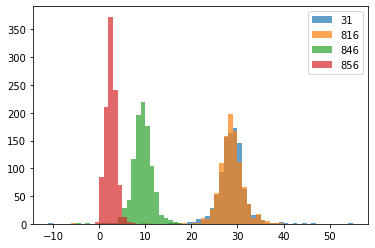

In [17]:
pm, mid = train_model(500,dropout = 0.1,id='sel')
t[mid],s[mid], e[mid] = eval_model(pm, test_ds)
p[mid] = pm

mae = raw_eval(t[mid],s[mid])

run_test(t[mid], s[mid], [31,816,846,856])

idx: 31 t: 31 p: 29
idx: 816 t: 44 p: 29
idx: 846 t: 14 p: 9
idx: 856 t: 4 p: 2


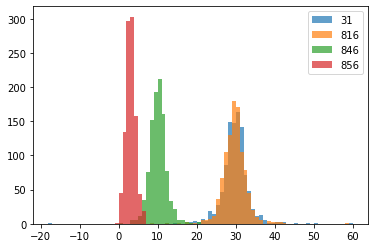

In [21]:
run_test(t[mid], s[mid], [31,816,846,856])

idx: 31 t: 31 p: 28
idx: 816 t: 44 p: 28
idx: 846 t: 14 p: 8
idx: 856 t: 4 p: 1


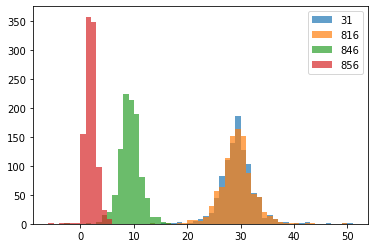

In [31]:
run_test(t[mid], s[mid], [31,816,846,856])

In [18]:
pitmodel = save_full_pitmodel(mid, 'sel', maxgap=65)

make full testdb: 47905 records


Running evaluation: 100%|██████████| 47905/47905 [03:45<00:00, 212.76it/s]


{
    "MSE": 2.170506532513962,
    "abs_error": 65189.56205482768,
    "abs_target_sum": 84410.26006088193,
    "abs_target_mean": 1.7620344444396605,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.307561021850031,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 42642.29159956571,
    "Coverage[0.1]": 0.7902515395052708,
    "QuantileLoss[0.5]": 65189.56205482768,
    "Coverage[0.5]": 0.9017847823817973,
    "QuantileLoss[0.9]": 24779.233726898732,
    "Coverage[0.9]": 0.9175242667779981,
    "RMSE": 1.4732639045717375,
    "NRMSE": 0.8361152696082771,
    "ND": 0.7722942922792668,
    "wQuantileLoss[0.1]": 0.5051790098598137,
    "wQuantileLoss[0.5]": 0.7722942922792668,
    "wQuantileLoss[0.9]": 0.2935571304842137,
    "mean_wQuantileLoss": 0.5236768108744314,
    "MAE_Coverage": 0.36985352955502204
}
save model pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle with 47905 keys.


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 167.80it/s, avg_epoch_loss=1.46]
INFO:root:Epoch[0] Elapsed time 0.598 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.459769
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 175.31it/s, avg_epoch_loss=1.16]
INFO:root:Epoch[1] Elapsed time 0.572 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=1.156980
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 177.78it/s, avg_epoch_loss=1.04]
INFO:root:Epoch[2] Elapsed time 0.564 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=1.044083
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 161.45it/s, avg_epoch_loss=0.999]
INFO:root:Epoch[3] Elapsed time 0.621 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.998903
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 174.63it/s,

100%|██████████| 100/100 [00:00<00:00, 182.49it/s, avg_epoch_loss=0.829]
INFO:root:Epoch[36] Elapsed time 0.549 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=0.829319
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 179.50it/s, avg_epoch_loss=0.873]
INFO:root:Epoch[37] Elapsed time 0.558 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.873202
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 181.24it/s, avg_epoch_loss=0.882]
INFO:root:Epoch[38] Elapsed time 0.553 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=0.882146
INFO:root:Loading parameters from best epoch (28)
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 181.79it/s, avg_epoch_loss=0.885]
INFO:root:Epoch[39] Elapsed time 0.551 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.884538
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 165.71it/s, avg_e

INFO:root:Epoch[72] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 166.29it/s, avg_epoch_loss=0.886]
INFO:root:Epoch[72] Elapsed time 0.603 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=0.886178
INFO:root:Epoch[73] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 176.96it/s, avg_epoch_loss=0.859]
INFO:root:Epoch[73] Elapsed time 0.567 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.858979
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 180.35it/s, avg_epoch_loss=0.842]
INFO:root:Epoch[74] Elapsed time 0.556 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.841856
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 179.64it/s, avg_epoch_loss=0.848]
INFO:root:Epoch[75] Elapsed time 0.558 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.848252
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 160.43it/s,

100%|██████████| 100/100 [00:00<00:00, 182.78it/s, avg_epoch_loss=0.89]
INFO:root:Epoch[108] Elapsed time 0.548 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=0.890202
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 184.66it/s, avg_epoch_loss=0.867]
INFO:root:Epoch[109] Elapsed time 0.543 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=0.867041
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 183.07it/s, avg_epoch_loss=0.885]
INFO:root:Epoch[110] Elapsed time 0.548 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.884679
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.87it/s, avg_epoch_loss=0.881]
INFO:root:Epoch[111] Elapsed time 0.557 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=0.881005
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.42it/s, avg_epoch_loss=0.861]
INFO:root:Epoch[112] Ela

100%|██████████| 100/100 [00:00<00:00, 182.21it/s, avg_epoch_loss=0.846]
INFO:root:Epoch[144] Elapsed time 0.550 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=0.846030
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.43it/s, avg_epoch_loss=0.829]
INFO:root:Epoch[145] Elapsed time 0.565 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.829087
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.57it/s, avg_epoch_loss=0.856]
INFO:root:Epoch[146] Elapsed time 0.558 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.856435
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.09it/s, avg_epoch_loss=0.89]
INFO:root:Epoch[147] Elapsed time 0.563 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.890187
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.51it/s, avg_epoch_loss=0.882]
INFO:root:Epoch[148] Ela

100%|██████████| 100/100 [00:00<00:00, 177.68it/s, avg_epoch_loss=0.872]
INFO:root:Epoch[180] Elapsed time 0.564 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=0.872082
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.19it/s, avg_epoch_loss=0.878]
INFO:root:Epoch[181] Elapsed time 0.576 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.877931
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.93it/s, avg_epoch_loss=0.852]
INFO:root:Epoch[182] Elapsed time 0.612 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=0.851746
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.86it/s, avg_epoch_loss=0.833]
INFO:root:Epoch[183] Elapsed time 0.570 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=0.832812
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.39it/s, avg_epoch_loss=0.836]
INFO:root:Epoch[184] El

100%|██████████| 100/100 [00:00<00:00, 185.29it/s, avg_epoch_loss=0.845]
INFO:root:Epoch[216] Elapsed time 0.541 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=0.844898
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.51it/s, avg_epoch_loss=0.875]
INFO:root:Epoch[217] Elapsed time 0.552 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=0.874910
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 183.61it/s, avg_epoch_loss=0.881]
INFO:root:Epoch[218] Elapsed time 0.546 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=0.880921
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.62it/s, avg_epoch_loss=0.852]
INFO:root:Epoch[219] Elapsed time 0.591 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=0.852101
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 182.42it/s, avg_epoch_loss=0.884]
INFO:root:Epoch[220] El

100%|██████████| 100/100 [00:00<00:00, 178.66it/s, avg_epoch_loss=0.847]
INFO:root:Epoch[252] Elapsed time 0.561 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=0.846695
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.34it/s, avg_epoch_loss=0.845]
INFO:root:Epoch[253] Elapsed time 0.595 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=0.844815
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.90it/s, avg_epoch_loss=0.834]
INFO:root:Epoch[254] Elapsed time 0.573 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=0.833542
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.51it/s, avg_epoch_loss=0.844]
INFO:root:Epoch[255] Elapsed time 0.595 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=0.844465
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 184.15it/s, avg_epoch_loss=0.851]
INFO:root:Epoch[256] El

100%|██████████| 100/100 [00:00<00:00, 181.26it/s, avg_epoch_loss=0.861]
INFO:root:Epoch[288] Elapsed time 0.553 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=0.860981
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.42it/s, avg_epoch_loss=0.89]
INFO:root:Epoch[289] Elapsed time 0.610 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=0.889782
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.86it/s, avg_epoch_loss=0.868]
INFO:root:Epoch[290] Elapsed time 0.612 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=0.867584
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.31it/s, avg_epoch_loss=0.862]
INFO:root:Epoch[291] Elapsed time 0.610 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=0.862231
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.29it/s, avg_epoch_loss=0.822]
INFO:root:Epoch[292] Ela

100%|██████████| 100/100 [00:00<00:00, 183.28it/s, avg_epoch_loss=0.854]
INFO:root:Epoch[324] Elapsed time 0.547 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=0.854415
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.51it/s, avg_epoch_loss=0.824]
INFO:root:Epoch[325] Elapsed time 0.555 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.823940
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.52it/s, avg_epoch_loss=0.851]
INFO:root:Epoch[326] Elapsed time 0.552 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.851120
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.34it/s, avg_epoch_loss=0.864]
INFO:root:Epoch[327] Elapsed time 0.606 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=0.863706
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.91it/s, avg_epoch_loss=0.88]
INFO:root:Epoch[328] Ela

100%|██████████| 100/100 [00:00<00:00, 178.27it/s, avg_epoch_loss=0.847]
INFO:root:Epoch[360] Elapsed time 0.562 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=0.846922
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.71it/s, avg_epoch_loss=0.848]
INFO:root:Epoch[361] Elapsed time 0.558 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=0.848332
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.38it/s, avg_epoch_loss=0.839]
INFO:root:Epoch[362] Elapsed time 0.559 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=0.838736
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.22it/s, avg_epoch_loss=0.832]
INFO:root:Epoch[363] Elapsed time 0.559 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=0.831727
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.27it/s, avg_epoch_loss=0.833]
INFO:root:Epoch[364] El

100%|██████████| 100/100 [00:00<00:00, 184.50it/s, avg_epoch_loss=0.851]
INFO:root:Epoch[396] Elapsed time 0.543 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=0.851123
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.67it/s, avg_epoch_loss=0.881]
INFO:root:Epoch[397] Elapsed time 0.558 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=0.880851
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.69it/s, avg_epoch_loss=0.857]
INFO:root:Epoch[398] Elapsed time 0.564 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=0.856807
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.22it/s, avg_epoch_loss=0.872]
INFO:root:Epoch[399] Elapsed time 0.589 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=0.872327
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.39it/s, avg_epoch_loss=0.827]
INFO:root:Epoch[400] El

100%|██████████| 100/100 [00:00<00:00, 161.93it/s, avg_epoch_loss=0.831]
INFO:root:Epoch[432] Elapsed time 0.619 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=0.830536
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.62it/s, avg_epoch_loss=0.825]
INFO:root:Epoch[433] Elapsed time 0.588 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=0.824616
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.71it/s, avg_epoch_loss=0.82]
INFO:root:Epoch[434] Elapsed time 0.558 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.819503
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.88it/s, avg_epoch_loss=0.865]
INFO:root:Epoch[435] Elapsed time 0.563 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=0.864777
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.26it/s, avg_epoch_loss=0.874]
INFO:root:Epoch[436] Ela

100%|██████████| 100/100 [00:00<00:00, 181.56it/s, avg_epoch_loss=0.849]
INFO:root:Epoch[468] Elapsed time 0.552 seconds
INFO:root:Epoch[468] Evaluation metric 'epoch_loss'=0.849124
INFO:root:Epoch[469] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.57it/s, avg_epoch_loss=0.851]
INFO:root:Epoch[469] Elapsed time 0.555 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=0.851109
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.36it/s, avg_epoch_loss=0.842]
INFO:root:Epoch[470] Elapsed time 0.556 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=0.842053
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.89it/s, avg_epoch_loss=0.837]
INFO:root:Epoch[471] Elapsed time 0.576 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=0.836935
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.50it/s, avg_epoch_loss=0.824]
INFO:root:Epoch[472] El

{
    "MSE": 1.039188971481898,
    "abs_error": 3980.5667862393107,
    "abs_target_sum": 5031.092032168558,
    "abs_target_mean": 1.0225796813350727,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.1213061459566063,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1520.6758291516526,
    "Coverage[0.1]": 0.10752032520325203,
    "QuantileLoss[0.5]": 3980.5667862393107,
    "Coverage[0.5]": 0.2733739837398374,
    "QuantileLoss[0.9]": 1921.0672762691524,
    "Coverage[0.9]": 0.6359756097560976,
    "RMSE": 1.0194061857188714,
    "NRMSE": 0.9968965786489538,
    "ND": 0.7911933951491565,
    "wQuantileLoss[0.1]": 0.30225561755351027,
    "wQuantileLoss[0.5]": 0.7911933951491565,
    "wQuantileLoss[0.9]": 0.38183902500410283,
    "mean_wQuantileLoss": 0.49176267923558986,
    "MAE_Coverage": 0.16605691056910568
}
mae =  7.400609756097561
idx: 31 t: 18 p: 23
idx: 816 t: 20 p: 10
idx: 846 t: 21 p: 16
idx: 856 t: 11 p: 8
make full testdb: 47905 records


Running evaluation: 100%|██████████| 47905/47905 [03:44<00:00, 213.06it/s]


{
    "MSE": 0.37917199785837763,
    "abs_error": 24063.23176426623,
    "abs_target_sum": 77647.07225634674,
    "abs_target_mean": 1.6208552814183643,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.39190953368788845,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 5534.42109281975,
    "Coverage[0.1]": 0.36827053543471455,
    "QuantileLoss[0.5]": 24063.23176426623,
    "Coverage[0.5]": 0.7598998016908465,
    "QuantileLoss[0.9]": 13768.186262890615,
    "Coverage[0.9]": 0.8316459659743242,
    "RMSE": 0.6157694356318586,
    "NRMSE": 0.3799040190022494,
    "ND": 0.3099052039569894,
    "wQuantileLoss[0.1]": 0.07127662295557287,
    "wQuantileLoss[0.5]": 0.3099052039569894,
    "wQuantileLoss[0.9]": 0.17731751967976134,
    "mean_wQuantileLoss": 0.18616644886410785,
    "MAE_Coverage": 0.1988414570504123
}
save model pitmodel-m65-mlp-dall-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle with 47905 keys.


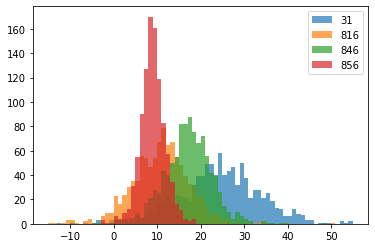

In [32]:
### run train on all data
trainset, testset, train_ds, test_ds, scaler = _data['all']

pm, mid = train_model(500,dropout = 0.1,id='all')
t[mid],s[mid], e[mid] = eval_model(pm, test_ds)
p[mid] = pm

mae = raw_eval(t[mid],s[mid])

run_test(t[mid], s[mid], [31,816,846,856])
pitmodel = save_full_pitmodel(mid, 'all', maxgap=65)

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 151.64it/s, avg_epoch_loss=1.47]
INFO:root:Epoch[0] Elapsed time 0.661 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.469403
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 157.18it/s, avg_epoch_loss=1.14]
INFO:root:Epoch[1] Elapsed time 0.638 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=1.137794
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 154.69it/s, avg_epoch_loss=0.915]
INFO:root:Epoch[2] Elapsed time 0.648 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.914556
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 169.43it/s, avg_epoch_loss=0.871]
INFO:root:Epoch[3] Elapsed time 0.592 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.870562
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 172.33it/s

100%|██████████| 100/100 [00:00<00:00, 174.33it/s, avg_epoch_loss=0.69]
INFO:root:Epoch[36] Elapsed time 0.575 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=0.690088
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 165.49it/s, avg_epoch_loss=0.712]
INFO:root:Epoch[37] Elapsed time 0.606 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.711858
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 170.42it/s, avg_epoch_loss=0.732]
INFO:root:Epoch[38] Elapsed time 0.588 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=0.732464
INFO:root:Loading parameters from best epoch (28)
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 171.69it/s, avg_epoch_loss=0.721]
INFO:root:Epoch[39] Elapsed time 0.585 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.720780
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 176.16it/s, avg_ep

INFO:root:Epoch[72] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 175.61it/s, avg_epoch_loss=0.718]
INFO:root:Epoch[72] Elapsed time 0.571 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=0.718308
INFO:root:Epoch[73] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 177.85it/s, avg_epoch_loss=0.681]
INFO:root:Epoch[73] Elapsed time 0.564 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.681050
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 179.53it/s, avg_epoch_loss=0.733]
INFO:root:Epoch[74] Elapsed time 0.558 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.732549
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 174.43it/s, avg_epoch_loss=0.738]
INFO:root:Epoch[75] Elapsed time 0.575 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.738408
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 178.53it/s,

100%|██████████| 100/100 [00:00<00:00, 181.94it/s, avg_epoch_loss=0.74]
INFO:root:Epoch[108] Elapsed time 0.551 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=0.740352
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.20it/s, avg_epoch_loss=0.705]
INFO:root:Epoch[109] Elapsed time 0.559 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=0.704802
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.39it/s, avg_epoch_loss=0.687]
INFO:root:Epoch[110] Elapsed time 0.553 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.686689
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.09it/s, avg_epoch_loss=0.712]
INFO:root:Epoch[111] Elapsed time 0.570 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=0.712036
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.99it/s, avg_epoch_loss=0.724]
INFO:root:Epoch[112] Ela

100%|██████████| 100/100 [00:00<00:00, 182.15it/s, avg_epoch_loss=0.712]
INFO:root:Epoch[144] Elapsed time 0.550 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=0.712461
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 183.87it/s, avg_epoch_loss=0.748]
INFO:root:Epoch[145] Elapsed time 0.545 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.748055
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 183.76it/s, avg_epoch_loss=0.717]
INFO:root:Epoch[146] Elapsed time 0.545 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.717432
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 183.92it/s, avg_epoch_loss=0.688]
INFO:root:Epoch[147] Elapsed time 0.545 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.688094
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.19it/s, avg_epoch_loss=0.719]
INFO:root:Epoch[148] El

100%|██████████| 100/100 [00:00<00:00, 179.78it/s, avg_epoch_loss=0.728]
INFO:root:Epoch[180] Elapsed time 0.558 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=0.727965
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 184.58it/s, avg_epoch_loss=0.731]
INFO:root:Epoch[181] Elapsed time 0.544 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.730786
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 183.39it/s, avg_epoch_loss=0.735]
INFO:root:Epoch[182] Elapsed time 0.547 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=0.735243
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.64it/s, avg_epoch_loss=0.718]
INFO:root:Epoch[183] Elapsed time 0.610 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=0.718372
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.66it/s, avg_epoch_loss=0.692]
INFO:root:Epoch[184] El

100%|██████████| 100/100 [00:00<00:00, 181.90it/s, avg_epoch_loss=0.704]
INFO:root:Epoch[216] Elapsed time 0.552 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=0.703948
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.98it/s, avg_epoch_loss=0.701]
INFO:root:Epoch[217] Elapsed time 0.558 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=0.701064
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.09it/s, avg_epoch_loss=0.707]
INFO:root:Epoch[218] Elapsed time 0.554 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=0.706632
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.04it/s, avg_epoch_loss=0.747]
INFO:root:Epoch[219] Elapsed time 0.557 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=0.746950
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.94it/s, avg_epoch_loss=0.719]
INFO:root:Epoch[220] El

100%|██████████| 100/100 [00:00<00:00, 179.66it/s, avg_epoch_loss=0.702]
INFO:root:Epoch[252] Elapsed time 0.558 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=0.702363
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 185.64it/s, avg_epoch_loss=0.705]
INFO:root:Epoch[253] Elapsed time 0.540 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=0.705442
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 182.54it/s, avg_epoch_loss=0.706]
INFO:root:Epoch[254] Elapsed time 0.549 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=0.705993
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.40it/s, avg_epoch_loss=0.718]
INFO:root:Epoch[255] Elapsed time 0.614 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=0.717514
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.91it/s, avg_epoch_loss=0.738]
INFO:root:Epoch[256] El

100%|██████████| 100/100 [00:00<00:00, 172.51it/s, avg_epoch_loss=0.685]
INFO:root:Epoch[288] Elapsed time 0.581 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=0.684649
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.21it/s, avg_epoch_loss=0.724]
INFO:root:Epoch[289] Elapsed time 0.553 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=0.723575
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.26it/s, avg_epoch_loss=0.705]
INFO:root:Epoch[290] Elapsed time 0.559 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=0.704936
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 183.17it/s, avg_epoch_loss=0.728]
INFO:root:Epoch[291] Elapsed time 0.547 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=0.727708
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 184.09it/s, avg_epoch_loss=0.693]
INFO:root:Epoch[292] El

100%|██████████| 100/100 [00:00<00:00, 161.74it/s, avg_epoch_loss=0.68]
INFO:root:Epoch[324] Elapsed time 0.620 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=0.679599
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.95it/s, avg_epoch_loss=0.693]
INFO:root:Epoch[325] Elapsed time 0.583 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.692864
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.70it/s, avg_epoch_loss=0.701]
INFO:root:Epoch[326] Elapsed time 0.580 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.701017
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 184.78it/s, avg_epoch_loss=0.712]
INFO:root:Epoch[327] Elapsed time 0.542 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=0.711806
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.88it/s, avg_epoch_loss=0.705]
INFO:root:Epoch[328] Ela

100%|██████████| 100/100 [00:00<00:00, 180.21it/s, avg_epoch_loss=0.73]
INFO:root:Epoch[360] Elapsed time 0.556 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=0.729559
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.66it/s, avg_epoch_loss=0.67]
INFO:root:Epoch[361] Elapsed time 0.552 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=0.670033
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 185.30it/s, avg_epoch_loss=0.677]
INFO:root:Epoch[362] Elapsed time 0.541 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=0.676574
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.31it/s, avg_epoch_loss=0.7]
INFO:root:Epoch[363] Elapsed time 0.535 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=0.699686
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.92it/s, avg_epoch_loss=0.699]
INFO:root:Epoch[364] Elapse

100%|██████████| 100/100 [00:00<00:00, 179.21it/s, avg_epoch_loss=0.72]
INFO:root:Epoch[396] Elapsed time 0.559 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=0.719797
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.72it/s, avg_epoch_loss=0.718]
INFO:root:Epoch[397] Elapsed time 0.587 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=0.717534
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 151.13it/s, avg_epoch_loss=0.688]
INFO:root:Epoch[398] Elapsed time 0.663 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=0.688146
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.50it/s, avg_epoch_loss=0.682]
INFO:root:Epoch[399] Elapsed time 0.578 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=0.681879
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.05it/s, avg_epoch_loss=0.716]
INFO:root:Epoch[400] Ela

100%|██████████| 100/100 [00:00<00:00, 180.46it/s, avg_epoch_loss=0.69]
INFO:root:Epoch[432] Elapsed time 0.555 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=0.690044
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.73it/s, avg_epoch_loss=0.721]
INFO:root:Epoch[433] Elapsed time 0.608 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=0.720548
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 184.27it/s, avg_epoch_loss=0.727]
INFO:root:Epoch[434] Elapsed time 0.544 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.727174
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 185.07it/s, avg_epoch_loss=0.684]
INFO:root:Epoch[435] Elapsed time 0.542 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=0.683758
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.82it/s, avg_epoch_loss=0.675]
INFO:root:Epoch[436] Ela

100%|██████████| 100/100 [00:00<00:00, 193.94it/s, avg_epoch_loss=0.719]
INFO:root:Epoch[468] Elapsed time 0.517 seconds
INFO:root:Epoch[468] Evaluation metric 'epoch_loss'=0.719060
INFO:root:Epoch[469] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 191.86it/s, avg_epoch_loss=0.692]
INFO:root:Epoch[469] Elapsed time 0.523 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=0.692263
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 192.75it/s, avg_epoch_loss=0.707]
INFO:root:Epoch[470] Elapsed time 0.520 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=0.707448
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 191.76it/s, avg_epoch_loss=0.732]
INFO:root:Epoch[471] Elapsed time 0.523 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=0.731722
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 191.99it/s, avg_epoch_loss=0.679]
INFO:root:Epoch[472] El

{
    "MSE": 0.922615022583552,
    "abs_error": 3605.5270269594307,
    "abs_target_sum": 4883.632899466723,
    "abs_target_mean": 1.0253270836587702,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.0353874601944504,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1409.861401869293,
    "Coverage[0.1]": 0.13667856393029604,
    "QuantileLoss[0.5]": 3605.5270269594307,
    "Coverage[0.5]": 0.262019735460844,
    "QuantileLoss[0.9]": 1969.5693903192528,
    "Coverage[0.9]": 0.5903842116313248,
    "RMSE": 0.9605285121138009,
    "NRMSE": 0.9368020482656689,
    "ND": 0.7382878896063508,
    "wQuantileLoss[0.1]": 0.2886911098545604,
    "wQuantileLoss[0.5]": 0.7382878896063508,
    "wQuantileLoss[0.9]": 0.4033000495459688,
    "mean_wQuantileLoss": 0.4767596830022934,
    "MAE_Coverage": 0.19475820561270907
}
mae =  6.912240184757506
idx: 31 t: 18 p: 25
idx: 816 t: 2 p: 2
idx: 846 t: 35 p: 15
idx: 856 t: 25 p: 6
make full testdb: 47905 records


Running evaluation: 100%|██████████| 47905/47905 [03:44<00:00, 213.33it/s]


{
    "MSE": 2.072099756308953,
    "abs_error": 58884.045941364646,
    "abs_target_sum": 80870.58516372032,
    "abs_target_mean": 1.6881449778461604,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.5440069127184829,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 18850.915041648448,
    "Coverage[0.1]": 0.05383571652228369,
    "QuantileLoss[0.5]": 58884.045941364646,
    "Coverage[0.5]": 0.18883206345892914,
    "QuantileLoss[0.9]": 53647.7137817443,
    "Coverage[0.9]": 0.3778519987475211,
    "RMSE": 1.4394789877969574,
    "NRMSE": 0.8526986761726671,
    "ND": 0.7281268686526193,
    "wQuantileLoss[0.1]": 0.2330997729704228,
    "wQuantileLoss[0.5]": 0.7281268686526193,
    "wQuantileLoss[0.9]": 0.6633773413798844,
    "mean_wQuantileLoss": 0.5415346610009756,
    "MAE_Coverage": 0.2931600737570887
}
save model pitmodel-m65-mlp-dnoshort-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle with 47905 keys.


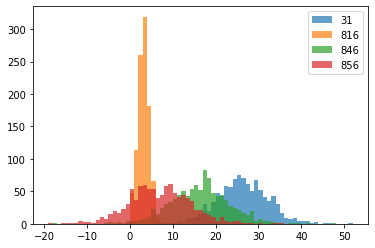

In [40]:
### run train on all data
tid = 'noshort'
trainset, testset, train_ds, test_ds, scaler = _data[tid]

pm, mid = train_model(500,dropout = 0.1,id=tid)
t[mid],s[mid], e[mid] = eval_model(pm, test_ds)
p[mid] = pm

mae = raw_eval(t[mid],s[mid])

run_test(t[mid], s[mid], [31,816,846,856])
pitmodel = save_full_pitmodel(mid, tid, maxgap=65)

In [ ]:
sys.exit(0)

### test and tuning

In [ ]:
s.keys()

In [ ]:
pm, mid = train_model(500,dropout = 0.1)
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
pm, mid = train_model(2000,dropout = 0.1)
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
save_model(p[mid], mid)
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
mid

In [ ]:
t.keys()

In [ ]:
pm, mid = train_model(200,dropout = 0.1, layers=[8,4])
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
e={}

In [ ]:
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
pm, mid = train_model(500, layers=[10,5])
t[mid],s[mid] = eval_model(pm)
p[mid] = pm

In [ ]:
pm, mid = train_model(500, layers=[32,16,8,4])
t[mid],s[mid] = eval_model(pm)
p[mid] = pm

In [ ]:
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
pm, mid = train_model(2000, layers=[32,16,8,4])
t[mid],s[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

### test

In [ ]:
trec = next(iter(train_ds))
trec


In [ ]:
run_test(tss, forecasts, [31,816,846,856])

In [ ]:
test_sel.iloc[816]

In [ ]:
test_sel.iloc[836]

In [ ]:
t[mid],s[mid] = eval_model(pm)

In [ ]:
get_pred(t[mid],s[mid], 816)

In [ ]:
next(iter(test_ds))

In [ ]:
scaler

In [ ]:
pm, mid = train_model(2,dropout = 0.1)
#t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
#run_test(t[mid], s[mid], [31,816,846,856])

#mid = 'mlp-e2000-l10-10-5-student-d0.1'
save_model(p[mid], mid)

### test pitmodel

In [ ]:
_scaler = scaler

In [ ]:
id = 'mlp-e2000-l10-10-5-student-d0.1'
t[id],s[id], e[id] = eval_model(p[id])

In [ ]:
forecasts = s[id]
tss = t[id]

scaler = _scaler
testset = test_sel[['lap2nextpit','caution_laps','pitage']].values

pitmodel = PitModel()

pitmodel.save_model('pitmodel_test', testset, forecasts, scaler)

In [ ]:
newcasts = pitmodel.forecast_ds(testset, forecasts)
scaler = _scaler
run_test(tss, newcasts, [31,816,846,856],raw_forecast=True)

In [ ]:
plt.plot(pitmodel.model['0-0'][0,:], pitmodel.model['0-0'][1,:])

In [ ]:
plt.plot(pitmodel.model['10-13'][0,:], pitmodel.model['10-13'][1,:])

In [ ]:
pitmodel.model['0-0'][0,:]

In [ ]:
scaler = _scaler
test_all = df_test[['lap2nextpit','caution_laps','pitage']].values
test_ds, _, test_set = makedb(test_all, scaler, perm=False)

id = 'mlp-e2000-l10-10-5-student-d0.1'
t[id],s[id], e[id] = eval_model(p[id])
forecasts = s[id]
tss = t[id]

pitmodel = PitModel()

pitmodel.save_model(f'mlp-{id}.pickle', test_all, forecasts, scaler)


In [ ]:
len(forecasts)

In [ ]:
testall_set

In [ ]:
scaler = _scaler
maxgap = 60
test_ds, _, test_set, test_all = make_fulltestdb(scaler, maxgap = maxgap)

id = 'mlp-e2000-l10-10-5-student-d0.1'

t[id],s[id], e[id] = eval_model(p[id])
forecasts = s[id]
tss = t[id]

pitmodel = PitModel()

pitmodel.save_model(f'pitmodel-m{maxgap}-{id}.pickle', test_all, forecasts, scaler)

In [ ]:
pitmodel.model['0-0'][0,:]

In [ ]:
plt.plot(pitmodel.model['0-0'][0,:], pitmodel.model['0-0'][1,:])

In [ ]:
t.keys()

In [ ]:
t['mlp-dsel-e500-l10-10-5-student-d0.1'][0]

### shortterm predictions using pitmodel(plen=2)

convert forecast samples of pitmodel to forecast samples of pit@plen laps

In [18]:
test_car12 = df_test[df_test['carno']==12]

In [19]:
test_ds, _, test_set = makedb(test_car12[['lap2nextpit','caution_laps','pitage']].values, scaler, perm=False)

In [20]:
len(test_set)

170

In [21]:
test

array([[ 1.88149958, -0.70945244, -1.40995345],
       [ 1.76852039, -0.70945244, -1.29736294],
       [ 1.6555412 , -0.70945244, -1.18477243],
       [ 1.54256201, -0.70945244, -1.07218192],
       [ 1.42958282, -0.70945244, -0.95959142],
       [ 1.31660363, -0.70945244, -0.84700091],
       [ 1.20362444, -0.70945244, -0.7344104 ],
       [ 1.09064525, -0.70945244, -0.62181989],
       [ 0.97766607, -0.70945244, -0.50922938],
       [ 0.86468688, -0.70945244, -0.39663887],
       [ 0.75170769, -0.70945244, -0.28404836],
       [ 0.6387285 , -0.70945244, -0.17145786],
       [ 0.52574931, -0.70945244, -0.05886735],
       [ 0.41277012, -0.70945244,  0.05372316],
       [ 0.29979093, -0.70945244,  0.16631367],
       [ 0.18681174, -0.70945244,  0.27890418],
       [ 0.07383255, -0.70945244,  0.39149469],
       [-0.03914664, -0.70945244,  0.5040852 ],
       [-0.15212582, -0.70945244,  0.6166757 ],
       [-0.26510501, -0.70945244,  0.72926621],
       [-0.3780842 , -0.70945244,  0.841

In [23]:
test_car12[test_car12['lap']==31]

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len
1059,18.0,0.0,0.0,1.0,12,5,31,18.0


In [24]:
test_car12[test_car12['lap']==30]

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len
1058,1.0,0.0,31.0,0.0,12,5,30,31.0


In [25]:
test_ds

[{'target': array([1.88149958]),
  'feat': array([-0.70945244, -1.40995345]),
  'start': Timestamp('2019-01-01 00:00:00', freq='T'),
  'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')},
 {'target': array([1.76852039]),
  'feat': array([-0.70945244, -1.29736294]),
  'start': Timestamp('2019-01-01 00:00:00', freq='T'),
  'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')},
 {'target': array([1.6555412]),
  'feat': array([-0.70945244, -1.18477243]),
  'start': Timestamp('2019-01-01 00:00:00', freq='T'),
  'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')},
 {'target': array([1.54256201]),
  'feat': array([-0.70945244, -1.07218192]),
  'start': Timestamp('2019-01-01 00:00:00', freq='T'),
  'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')},
 {'target': array([1.42958282]),
  'feat': array([-0.70945244, -0.95959142]),
  'start': Timestamp('2019-01-01 00:00:00', freq='T'),
  'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')},
 {'target':

In [26]:
len(test_ds)

170

In [28]:
test_set

array([[ 1.88149958, -0.70945244, -1.40995345],
       [ 1.76852039, -0.70945244, -1.29736294],
       [ 1.6555412 , -0.70945244, -1.18477243],
       [ 1.54256201, -0.70945244, -1.07218192],
       [ 1.42958282, -0.70945244, -0.95959142],
       [ 1.31660363, -0.70945244, -0.84700091],
       [ 1.20362444, -0.70945244, -0.7344104 ],
       [ 1.09064525, -0.70945244, -0.62181989],
       [ 0.97766607, -0.70945244, -0.50922938],
       [ 0.86468688, -0.70945244, -0.39663887],
       [ 0.75170769, -0.70945244, -0.28404836],
       [ 0.6387285 , -0.70945244, -0.17145786],
       [ 0.52574931, -0.70945244, -0.05886735],
       [ 0.41277012, -0.70945244,  0.05372316],
       [ 0.29979093, -0.70945244,  0.16631367],
       [ 0.18681174, -0.70945244,  0.27890418],
       [ 0.07383255, -0.70945244,  0.39149469],
       [-0.03914664, -0.70945244,  0.5040852 ],
       [-0.15212582, -0.70945244,  0.6166757 ],
       [-0.26510501, -0.70945244,  0.72926621],
       [-0.3780842 , -0.70945244,  0.841

### test

In [19]:
df12 = df_test[(df_test['eid']==5) & (df_test['carno']==12)]

In [20]:
df12[(df12['lap']>=45) & (df12['lap']<55)]

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len,cur_cautionlaps
1073,4.0,0.0,14.0,1.0,12,5,45,18.0,0.0
1074,3.0,0.0,15.0,1.0,12,5,46,18.0,0.0
1075,2.0,1.0,16.0,1.0,12,5,47,18.0,1.0
1076,1.0,2.0,17.0,1.0,12,5,48,18.0,2.0
1077,44.0,0.0,0.0,0.0,12,5,49,44.0,0.0
1078,43.0,1.0,1.0,0.0,12,5,50,44.0,1.0
1079,42.0,2.0,2.0,0.0,12,5,51,44.0,2.0
1080,41.0,3.0,3.0,0.0,12,5,52,44.0,3.0
1081,40.0,4.0,4.0,0.0,12,5,53,44.0,4.0
1082,39.0,4.0,5.0,0.0,12,5,54,44.0,0.0


In [21]:
df12

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len,cur_cautionlaps
1028,31.0,0.0,1.0,0.0,12,5,0,31.0,0.0
1029,30.0,0.0,2.0,0.0,12,5,1,31.0,0.0
1030,29.0,0.0,3.0,0.0,12,5,2,31.0,0.0
1031,28.0,0.0,4.0,0.0,12,5,3,31.0,0.0
1032,27.0,0.0,5.0,0.0,12,5,4,31.0,0.0
...,...,...,...,...,...,...,...,...,...
1193,5.0,20.0,37.0,0.0,12,5,165,42.0,0.0
1194,4.0,20.0,38.0,0.0,12,5,166,42.0,0.0
1195,3.0,20.0,39.0,0.0,12,5,167,42.0,0.0
1196,2.0,20.0,40.0,0.0,12,5,168,42.0,0.0


In [22]:
df12.cur_cautionlaps.values

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1.,
       2., 3., 4., 0., 0., 0., 1., 2., 3., 4., 5., 0., 0., 0., 0., 0., 1.,
       2., 3., 4., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 2., 3., 4., 5., 6., 0., 1., 2., 3., 4., 5., 6., 7., 0.,
       1., 2., 3., 4., 5., 6., 7., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [23]:
train_set

array([[ 1.56895685, -0.64173227, -1.57348481, -0.21381922],
       [ 1.24715782, -0.64173227, -1.68074602, -0.21381922],
       [ 0.60355976, -0.64173227, -0.60813392, -0.21381922],
       ...,
       [ 0.06722804,  1.35544334,  0.35721696, -0.21381922],
       [-0.89816905,  0.35685554,  0.67900059, -0.21381922],
       [-0.68363636,  3.01975635,  1.53709027, -0.21381922]])

In [33]:
samples = np.zeros((1000))
for i in range(1000):
    samples[i] = pitmodel.predict(1,16,1)
    
samples[samples<5]

array([4., 4., 2., 2., 4., 4., 4., 3., 4., 1., 2., 4., 2., 3., 3., 2., 2.,
       3., 4., 4., 1., 3., 2., 2., 3., 4., 2., 4., 3., 4., 4., 1., 4., 3.,
       1., 4., 1., 1., 2., 1., 3., 1., 4., 2., 4., 3., 4., 2., 3., 4., 4.,
       2., 2., 1., 4., 2., 3., 3., 2., 2., 2., 4., 4., 4., 4., 1., 1., 3.,
       2., 2., 4., 4., 2., 1., 2., 1., 2., 3., 1., 3., 2., 2., 4., 2., 2.,
       1., 2., 4., 4., 2., 1., 4., 4., 2., 2., 1., 4., 4., 2., 3., 4., 4.,
       3., 3., 1., 3., 4., 4., 2., 2., 3., 4., 4., 3., 4.])

In [34]:
np.sum(samples<5)

115

In [35]:
np.min(samples)

1.0

In [36]:
np.max(samples)

39.0

In [34]:
test_all

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len,cur_cautionlaps
0,31.0,0.0,1.0,0.0,1,5,0,31.0,0.0
1,30.0,0.0,2.0,0.0,1,5,1,31.0,0.0
2,29.0,0.0,3.0,0.0,1,5,2,31.0,0.0
3,28.0,0.0,4.0,0.0,1,5,3,31.0,0.0
4,27.0,0.0,5.0,0.0,1,5,4,31.0,0.0
...,...,...,...,...,...,...,...,...,...
5566,999.0,5.0,26.0,0.0,98,5,195,0.0,0.0
5567,999.0,5.0,27.0,0.0,98,5,196,0.0,0.0
5568,999.0,5.0,28.0,0.0,98,5,197,0.0,0.0
5569,999.0,5.0,29.0,0.0,98,5,198,0.0,0.0


In [35]:
df_test

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len,cur_cautionlaps
0,31.0,0.0,1.0,0.0,1,5,0,31.0,0.0
1,30.0,0.0,2.0,0.0,1,5,1,31.0,0.0
2,29.0,0.0,3.0,0.0,1,5,2,31.0,0.0
3,28.0,0.0,4.0,0.0,1,5,3,31.0,0.0
4,27.0,0.0,5.0,0.0,1,5,4,31.0,0.0
...,...,...,...,...,...,...,...,...,...
5566,999.0,5.0,26.0,0.0,98,5,195,0.0,0.0
5567,999.0,5.0,27.0,0.0,98,5,196,0.0,0.0
5568,999.0,5.0,28.0,0.0,98,5,197,0.0,0.0
5569,999.0,5.0,29.0,0.0,98,5,198,0.0,0.0
